In [ ]:
pip install gym-minigrid

In [ ]:
pip install pyglet

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
module_path = module_path + '/marlgrid-master'
print(module_path)

In [ ]:
import copy
import gym
import random
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from marlgrid.envs.doorkey import DoorKeyEnv
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw
import pickle

In [156]:
player_interface_config = {
    "view_size": 6,
    "view_offset": 1,
    "view_tile_size": 10,
    "observation_style": "rich",
    "see_through_walls": False,
    "color": "prestige",
    "observe_position": True,
    "observe_orientation": True,
    "type": "teacher"
}
student_config = copy.deepcopy(player_interface_config)
student_config["color"] = "blue"
student_config["type"] = "student"


def _save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    """Takes a list of frames (each frame can be generated with the `env.render()` function from OpenAI gym)
    and converts it into GIF, and saves it to the specified location.
    Code adapted from this gist: https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
    """
    imageio.mimwrite(os.path.join(path, filename), frames, fps=60)


def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255, 255, 255)
    else:
        text_color = (0, 0, 0)
    drawer.text((im.size[0] / 20, im.size[1] / 18), f'Episode: {episode_num + 1}', fill=text_color)

    return im


def reset(env):
    obs = env.reset()
    # env.agents[0].set_position([1, 1])
    # env.agents[1].set_position([3, 2])
    # next_obs, reward, done, info = env.step([6, 6])
    return obs


# Add the player/agent config to the environment config
agents = [player_interface_config, student_config]


def sample_env():
    i = 2 #orig: 2
    while True:
        env = DoorKeyEnv(
            grid_size=6,
            max_steps=250,
            respawn=True,
            ghost_mode=True,
            reward_decay=False,
            agents=agents,
            seed=i
        )
        i += 1
        teacher_obs = env.agents[0].pos
        student_obs = env.agents[1].pos
        if 0 < teacher_obs[0] < 3 and 0 < teacher_obs[1] < 5 and \
                0 < student_obs[0] < 3 and 0 < student_obs[1] < 5:
            break
    return env


env = sample_env()
teacher_obs = env.agents[0].pos
student_obs = env.agents[1].pos
teacher_dir = env.agents[0].dir
student_dir = env.agents[1].dir
door = env.grid.get(3,1)
print('door', int(door.state))
print('selected', teacher_obs, student_obs, teacher_dir, student_dir)



door 0
selected [2 4] [2 3] 0 0


/home/yseult/anaconda3/lib/python3.9/site-packages/gym/utils/seeding.py:63: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(
/home/yseult/PycharmProjects/BMMproject/marlgrid-master/marlgrid/agents.py:111: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ).astype(np.int)


/home/yseult/anaconda3/lib/python3.9/site-packages/gym/core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/home/yseult/PycharmProjects/BMMproject/marlgrid-master/marlgrid/base.py:742: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  highlight_mask = np.full((self.width, self.height), False, dtype=np.bool)


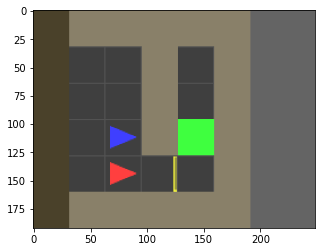

In [130]:
# we can compare the number of episode that first reach the goal
# or after N episodes of training, what’s the accuracy after fixed amount of training
# or compute the number of steps to take in testing
img = env.render('rgb_array')
plt.imshow(img)

In [ ]:
# Hyper parameters
alpha = 0.01
gamma = 0.99
epsilon = 0.1

num_episodes = 2

# For plotting metrics
all_steps = np.zeros(num_episodes)
all_rewards = np.zeros(num_episodes)


In [ ]:
# Train the teacher 

q_table_teacher = np.zeros([36*4*2, 7])
cumcount = 0

for i in range(num_episodes):
    env = sample_env()
    teacher = env.agents[0].pos
    student = env.agents[1].pos
    teacher_dir = env.agents[0].dir
    student_dir = env.agents[1].dir
    #teacher_carrykey = int(env.agents[0].carrying is not None)
    door_state = int(env.grid.get(3,1).state == env.grid.get(3,1).states.open)
    print(env.grid.get(3,1).state == env.grid.get(3,1).states.closed)
    print('ds', door_state)
    state = teacher[1] * 6 * 4 * 2 + teacher[0] * 4 * 2 + teacher_dir * 2 + door_state

    steps_per_episode, reward_per_episode = 0, 0
    done = False
   
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space[0].sample()  # Explore action space

        else:
            action = np.random.choice(
                np.where(q_table_teacher[state] == np.max(q_table_teacher[state]))[0])  # Exploit learned values

        next_obs, reward, done, info = env.step([action, 6])
        #teacher = next_obs[0]
        teacher = env.agents[0].pos
        teacher_dir = env.agents[0].dir
        teacher_carrykey = int(env.agents[0].carrying is not None)
        door_state = int(env.grid.get(3,1).state == env.grid.get(3,1).states.open)
        next_state = teacher[1] * 6 * 4 * 2 + teacher[0] * 4 * 2 + teacher_dir * 2 + door_state       

        old_value = q_table_teacher[state, action]
        next_max = np.max(q_table_teacher[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward[0] + gamma * next_max)
        q_table_teacher[state, action] = new_value
        if reward[0] != 0:
            cumcount += 1
            print('episode:', i)
            print('reward:', reward)
            print('new value: ', new_value)
            print('done', done)
            print('solved episodes', cumcount)
        
        state = next_state
        steps_per_episode += 1
        reward_per_episode += reward[0]
        if reward[0] > 0:
            break

    all_steps[i] = steps_per_episode
    all_rewards[i] = reward_per_episode

print("Training of the teacher finished.\n")




In [ ]:
print(all_rewards)

In [ ]:
np.save(f'/home/yseult/PycharmProjects/BMMproject/marlgrid-master/q_table_teacher_opendoor_seed4_{num_episodes}episodes.npy', q_table_teacher)

#np.save('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_teacher_opendoor.npy', all_rewards)


In [ ]:
#############################################################

# Plot the cumulative reward (the sum of all rewards received so far) as a function of the number of episodes

smoothing_window = 10

figname = f'opendoor_teacher_training_results_seed2_{num_episodes}_episodes.png'

plt.figure(figsize=(10, 5))
rewards_smoothed = pd.Series(all_rewards).rolling(smoothing_window).mean()
#rewards_smoothed = all_rewards
plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time for the Teacher (Smoothed over window size {})".format(smoothing_window))
#plt.savefig(figname)
plt.show(block=False)
plt.close()


In [ ]:
"""Evaluate teacher's performance after Q-learning"""

total_epochs, total_reward = 0, 0
episodes = 100


for _ in range(episodes):
    env = sample_env()
    teacher = env.agents[0].pos
    student = env.agents[1].pos
    teacher_dir = env.agents[0].dir
    student_dir = env.agents[1].dir
    #teacher_carrykey = int(env.agents[0].carrying is not None)
    door_state = int(env.grid.get(3,1).state == env.grid.get(3,1).states.open)
    state = teacher[1] * 6 * 4 * 2 + teacher[0] * 4 * 2 + teacher_dir * 2 + door_state

    epochs, reward = 0, 0

    done = False
    #print(teacher, student)
    #img = env.render('rgb_array')
    #plt.imshow(img)

    while not done:
        action = np.random.choice(
            np.where(q_table_teacher[state] == np.max(q_table_teacher[state]))[0])  # Exploit learned values

        next_obs, reward, done, info = env.step([action, 6])
        teacher = env.agents[0].pos
        teacher_dir = env.agents[0].dir
        #print(teacher)
        teacher_carrykey = int(env.agents[0].carrying is not None)
        door_state = int(env.grid.get(3,1).state == env.grid.get(3,1).states.open)
        state = teacher[1] * 6 * 4 * 2 + teacher[0] * 4 * 2 + teacher_dir * 2 + door_state
        epochs += 1
        
        if reward[0] > 0:
            break

    total_epochs += epochs
    total_reward += reward[0]

print(f"Results after {episodes} episodes:")
print(f"Average time steps per episode: {total_epochs / episodes}")
print(f"Average reward per episode: {total_reward / episodes}")


In [157]:
## STUDENT


# Hyper parameters
alpha = 0.01
gamma = 0.99


num_episodes = 200

# For plotting metrics
all_steps = np.zeros(num_episodes)
all_rewards = np.zeros(num_episodes)
all_env_rewards = np.zeros(num_episodes)

In [164]:

all_epochs = np.zeros(num_episodes)

epsilon = 0.1 #orig: 0.1

In [159]:
q_table_teacher = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/q_table_teacher_opendoor_seed2_200episodes.npy')


In [165]:
""" Train the student """

q_table_student = np.zeros([36*4*2, 7])

reward = 0
reward_BC = 0

for i in range(num_episodes):
    env = sample_env()
    teacher = env.agents[0].pos
    student = env.agents[1].pos
    teacher_dir = env.agents[0].dir
    student_dir = env.agents[1].dir   
    #door_state = int(env.grid.get(3,1).state == env.grid.get(3,1).states.closed) #same door loc
    door_state = int(env.grid.get(3,4).state == env.grid.get(3,4).states.open) #not same door loc
    state = student[1] * 6 * 4 * 2 + student[0] * 4 * 2 + student_dir * 2 + door_state
    
    steps_per_episode, reward_per_episode = 0, 0
    env_reward_per_episode = 0
    done = False    
    
    #t = 0
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action_student = env.action_space[1].sample()  # Explore action space
        else:
            action_student = np.random.choice(
                np.where(q_table_student[state] == np.max(q_table_student[state]))[0])  # Exploit learned values
        
        action_teacher = np.random.choice(
            np.where(q_table_teacher[state] == np.max(q_table_teacher[state]))[0])  # Exploit learned values

        #t += 1
#        print(t)
#        
#        if t % 3 == 0:
#            if action_student != action_teacher:
#                reward_BC = -0.5 #.5 when changing the door location / orig = 1
#            else:
#                reward_BC = 0.5
#                
#        else:
#            reward = 0

               
        
        if action_student != action_teacher:
            reward_BC = -0.5 #.5 when changing the door location / orig = 1
        else:
            reward_BC = 0.5
                


        next_obs, env_reward, done, info = env.step([6, action_student])
        student = env.agents[1].pos
        student_dir = env.agents[1].dir        
        #door_state = int(env.grid.get(3,1).state == env.grid.get(3,1).states.closed) #same door loc
        door_state = int(env.grid.get(3,4).state == env.grid.get(3,4).states.open) #not same door loc
        next_state = student[1] * 6 * 4 * 2 + student[0] * 4 * 2 + student_dir *2 + door_state
                
        old_value = q_table_student[state, action_student]
        next_max = np.max(q_table_student[next_state])
        
        # when changing the door location       
        if env_reward[1] > 0:
            reward = env_reward[1]
            env_reward_per_episode += env_reward[1]
        else:
            reward = reward_BC

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

        q_table_student[state, action_student] = new_value
        if reward != 0:
            print('episode:', i)
            print('reward:', reward)
            print('new value: ', new_value)
            print('done', done)

        state = next_state
        steps_per_episode += 1
        print('stepperep', steps_per_episode)
        reward_per_episode += reward
        
        if env_reward[1] > 0:
            break

    all_steps[i] = steps_per_episode
    all_rewards[i] = reward_per_episode
    all_env_rewards[i] = env_reward_per_episode


print("Training of the student finished.\n")

#img = env.render('rgb_array')
#plt.imshow(img)


episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 1
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 2
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 3
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 4
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 5
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 6
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 7
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 8
episode: 0
reward: 0.5
new value:  0.005
done False
stepperep 9
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 10
episode: 0
reward: -0.5
new value:  -0.0049505
done False
stepperep 11
episode: 0
reward: 0.5
new value:  0.00995
done False
stepperep 12
episode: 0
reward: 0.5
new value:  0.005
done False
stepperep 13
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 14
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 15
epis

episode: 0
reward: 0.5
new value:  0.6803628909670225
done False
stepperep 193
episode: 0
reward: 0.5
new value:  0.6852948546779258
done False
stepperep 194
episode: 0
reward: 0.5
new value:  0.690226325192458
done False
stepperep 195
episode: 0
reward: 0.5
new value:  0.6951573025599388
done False
stepperep 196
episode: 0
reward: 0.5
new value:  0.7000877868296829
done False
stepperep 197
episode: 0
reward: 0.5
new value:  0.7050177780509999
done False
stepperep 198
episode: 0
reward: 0.5
new value:  0.7099472762731948
done False
stepperep 199
episode: 0
reward: 0.5
new value:  0.7148762815455675
done False
stepperep 200
episode: 0
reward: 0.5
new value:  0.7198047939174128
done False
stepperep 201
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 202
episode: 0
reward: -0.5
new value:  -0.005
done False
stepperep 203
episode: 0
reward: -0.5
new value:  -0.0049505
done False
stepperep 204
episode: 0
reward: 0.5
new value:  0.009999500000000001
done False
stepperep 205
e

episode: 1
reward: 0.5
new value:  1.3417367425970959
done False
stepperep 123
episode: 1
reward: 0.5
new value:  1.346602568922836
done False
stepperep 124
episode: 1
reward: 0.5
new value:  1.3514679086659438
done False
stepperep 125
episode: 1
reward: 0.5
new value:  1.3563327618750773
done False
stepperep 126
episode: 1
reward: 0.5
new value:  1.3611971285988897
done False
stepperep 127
episode: 1
reward: 0.5
new value:  1.3660610088860297
done False
stepperep 128
episode: 1
reward: 0.5
new value:  1.370924402785141
done False
stepperep 129
episode: 1
reward: 0.5
new value:  1.3757873103448626
done False
stepperep 130
episode: 1
reward: 0.5
new value:  1.380649731613828
done False
stepperep 131
episode: 1
reward: 0.5
new value:  1.3855116666406666
done False
stepperep 132
episode: 1
reward: 0.5
new value:  1.3903731154740024
done False
stepperep 133
episode: 1
reward: 0.5
new value:  1.395234078162455
done False
stepperep 134
episode: 1
reward: 0.5
new value:  1.4000945547546386
do

episode: 1
reward: 0.5
new value:  0.14250957513420623
done False
stepperep 232
episode: 1
reward: 0.5
new value:  1.8018243716590612
done False
stepperep 233
episode: 1
reward: 0.5
new value:  1.8066441892218954
done False
stepperep 234
episode: 1
reward: 0.5
new value:  1.8114635248029731
done False
stepperep 235
episode: 1
reward: 0.5
new value:  1.816282378450493
done False
stepperep 236
episode: 1
reward: -0.5
new value:  -0.021116372135746523
done False
stepperep 237
episode: 1
reward: 0.5
new value:  0.16406567492952406
done False
stepperep 238
episode: 1
reward: 0.5
new value:  1.821100750212648
done False
stepperep 239
episode: 1
reward: -0.5
new value:  -0.03314749773147174
done False
stepperep 240
episode: 1
reward: 0.5
new value:  0.02959765399995483
done False
stepperep 241
episode: 1
reward: -0.5
new value:  -0.00977896095274525
done False
stepperep 242
episode: 1
reward: 0.5
new value:  0.02372815490727729
done False
stepperep 243
episode: 1
reward: 0.5
new value:  0.185

episode: 2
reward: 0.5
new value:  2.5526637588550765
done False
stepperep 175
episode: 2
reward: 0.5
new value:  2.557408492479191
done False
stepperep 176
episode: 2
reward: 0.5
new value:  2.562152751629943
done False
stepperep 177
episode: 2
reward: 0.5
new value:  2.5668965363547795
done False
stepperep 178
episode: 2
reward: 0.5
new value:  2.571639846701144
done False
stepperep 179
episode: 2
reward: 0.5
new value:  2.5763826827164737
done False
stepperep 180
episode: 2
reward: 0.5
new value:  2.5811250444482017
done False
stepperep 181
episode: 2
reward: 0.5
new value:  2.5858669319437566
done False
stepperep 182
episode: 2
reward: 0.5
new value:  2.5906083452505624
done False
stepperep 183
episode: 2
reward: 0.5
new value:  2.595349284416037
done False
stepperep 184
episode: 2
reward: 0.5
new value:  2.600089749487595
done False
stepperep 185
episode: 2
reward: 0.5
new value:  2.6048297405126464
done False
stepperep 186
episode: 2
reward: 0.5
new value:  2.609569257538595
done

episode: 3
reward: 0.5
new value:  3.3058174990915195
done False
stepperep 125
episode: 3
reward: 0.5
new value:  3.3104869173416103
done False
stepperep 126
episode: 3
reward: 0.5
new value:  3.315155868649876
done False
stepperep 127
episode: 3
reward: 0.5
new value:  3.3198243530630105
done False
stepperep 128
episode: 3
reward: -0.5
new value:  0.11641315233776947
done False
stepperep 129
episode: 3
reward: 0.5
new value:  3.3244923706277043
done False
stepperep 130
episode: 3
reward: 0.5
new value:  3.3291599213906413
done False
stepperep 131
episode: 3
reward: 0.5
new value:  3.3338270053985024
done False
stepperep 132
episode: 3
reward: 0.5
new value:  3.3384936226979627
done False
stepperep 133
episode: 3
reward: 0.5
new value:  3.343159773335693
done False
stepperep 134
episode: 3
reward: 0.5
new value:  3.3478254573583595
done False
stepperep 135
episode: 3
reward: 0.5
new value:  3.3524906748126235
done False
stepperep 136
episode: 3
reward: -0.5
new value:  0.15355904929441

episode: 4
reward: 0.5
new value:  4.0332274252461815
done False
stepperep 56
episode: 4
reward: 0.5
new value:  4.037824102503657
done False
stepperep 57
episode: 4
reward: 0.5
new value:  4.042420320093407
done False
stepperep 58
episode: 4
reward: 0.5
new value:  4.0470160780613975
done False
stepperep 59
episode: 4
reward: 0.5
new value:  4.051611376453591
done False
stepperep 60
episode: 4
reward: 0.5
new value:  4.056206215315946
done False
stepperep 61
episode: 4
reward: 0.5
new value:  4.060800594694414
done False
stepperep 62
episode: 4
reward: 0.5
new value:  4.065394514634945
done False
stepperep 63
episode: 4
reward: 0.5
new value:  4.069987975183482
done False
stepperep 64
episode: 4
reward: 0.5
new value:  4.074580976385963
done False
stepperep 65
episode: 4
reward: -0.5
new value:  0.18736181046769312
done False
stepperep 66
episode: 4
reward: -0.5
new value:  0.22082654402923724
done False
stepperep 67
episode: 4
reward: 0.5
new value:  4.079173518288324
done False
step

episode: 4
reward: 0.5
new value:  4.762879486540456
done False
stepperep 247
episode: 4
reward: 0.5
new value:  4.767403198591802
done False
stepperep 248
episode: 4
reward: 0.5
new value:  4.771926458271944
done False
stepperep 249
episode: 4
reward: 0.5
new value:  4.776449265626117
done True
stepperep 250
episode: 5
reward: 0.5
new value:  0.044217545279016904
done False
stepperep 1
episode: 5
reward: 0.5
new value:  0.030413263028354585
done False
stepperep 2
episode: 5
reward: 0.5
new value:  0.05479420452394469
done False
stepperep 3
episode: 5
reward: 0.5
new value:  1.0090785898485075
done False
stepperep 4
episode: 5
reward: 0.5
new value:  4.780971620699554
done False
stepperep 5
episode: 5
reward: 0.5
new value:  4.785493523537483
done False
stepperep 6
episode: 5
reward: 0.5
new value:  4.79001497418513
done False
stepperep 7
episode: 5
reward: 0.5
new value:  4.7945359726877115
done False
stepperep 8
episode: 5
reward: 0.5
new value:  4.799056519090443
done False
steppere

episode: 5
reward: 0.5
new value:  5.521000562085427
done False
stepperep 198
episode: 5
reward: 0.5
new value:  5.525448462029218
done False
stepperep 199
episode: 5
reward: 0.5
new value:  5.5298959171830155
done False
stepperep 200
episode: 5
reward: 0.5
new value:  5.534342927591297
done False
stepperep 201
episode: 5
reward: 0.5
new value:  5.5387894932985375
done False
stepperep 202
episode: 5
reward: 0.5
new value:  5.543235614349208
done False
stepperep 203
episode: 5
reward: 0.5
new value:  5.547681290787773
done False
stepperep 204
episode: 5
reward: 0.5
new value:  5.552126522658694
done False
stepperep 205
episode: 5
reward: 0.5
new value:  5.5565713100064285
done False
stepperep 206
episode: 5
reward: 0.5
new value:  5.561015652875428
done False
stepperep 207
episode: 5
reward: 0.5
new value:  5.56545955131014
done False
stepperep 208
episode: 5
reward: 0.5
new value:  5.569903005355009
done False
stepperep 209
episode: 5
reward: 0.5
new value:  5.5743460150544735
done Fal

episode: 6
reward: 0.5
new value:  6.275162697079648
done False
stepperep 145
episode: 6
reward: 0.5
new value:  6.27953518080994
done False
stepperep 146
episode: 6
reward: 0.5
new value:  6.283907227291859
done False
stepperep 147
episode: 6
reward: 0.5
new value:  6.2882788365691304
done False
stepperep 148
episode: 6
reward: 0.5
new value:  6.292650008685474
done False
stepperep 149
episode: 6
reward: 0.5
new value:  6.297020743684605
done False
stepperep 150
episode: 6
reward: 0.5
new value:  6.301391041610237
done False
stepperep 151
episode: 6
reward: 0.5
new value:  6.3057609025060755
done False
stepperep 152
episode: 6
reward: 0.5
new value:  6.310130326415824
done False
stepperep 153
episode: 6
reward: 0.5
new value:  6.314499313383182
done False
stepperep 154
episode: 6
reward: 0.5
new value:  6.318867863451844
done False
stepperep 155
episode: 6
reward: 0.5
new value:  6.323235976665499
done False
stepperep 156
episode: 6
reward: 0.5
new value:  6.327603653067833
done False

episode: 7
reward: 0.5
new value:  6.960620026549676
done False
stepperep 85
episode: 7
reward: 0.5
new value:  6.964923964547021
done False
stepperep 86
episode: 7
reward: -0.5
new value:  0.7574917209620031
done False
stepperep 87
episode: 7
reward: 0.5
new value:  6.969227472150566
done False
stepperep 88
episode: 7
reward: 0.5
new value:  6.973530549403351
done False
stepperep 89
episode: 7
reward: 0.5
new value:  6.977833196348411
done False
stepperep 90
episode: 7
reward: 0.5
new value:  6.982135413028775
done False
stepperep 91
episode: 7
reward: 0.5
new value:  6.986437199487472
done False
stepperep 92
episode: 7
reward: 0.5
new value:  6.990738555767524
done False
stepperep 93
episode: 7
reward: 0.5
new value:  6.995039481911947
done False
stepperep 94
episode: 7
reward: 0.5
new value:  6.999339977963756
done False
stepperep 95
episode: 7
reward: 0.5
new value:  7.00364004396596
done False
stepperep 96
episode: 7
reward: 0.5
new value:  7.007939679961563
done False
stepperep 9

episode: 7
reward: 0.5
new value:  7.346255764430647
done False
stepperep 192
episode: 7
reward: 0.5
new value:  7.350521138854203
done False
stepperep 193
episode: 7
reward: 0.5
new value:  7.354786086740318
done False
stepperep 194
episode: 7
reward: 0.5
new value:  7.359050608131644
done False
stepperep 195
episode: 7
reward: 0.5
new value:  7.36331470307083
done False
stepperep 196
episode: 7
reward: 0.5
new value:  7.367578371600523
done False
stepperep 197
episode: 7
reward: 0.5
new value:  7.371841613763363
done False
stepperep 198
episode: 7
reward: 0.5
new value:  7.376104429601986
done False
stepperep 199
episode: 7
reward: 0.5
new value:  7.380366819159026
done False
stepperep 200
episode: 7
reward: 0.5
new value:  7.384628782477111
done False
stepperep 201
episode: 7
reward: 0.5
new value:  7.388890319598864
done False
stepperep 202
episode: 7
reward: 0.5
new value:  7.393151430566904
done False
stepperep 203
episode: 7
reward: 0.5
new value:  7.3974121154238475
done False


episode: 8
reward: 0.5
new value:  7.745342269579067
done False
stepperep 50
episode: 8
reward: 0.5
new value:  7.749567735352109
done False
stepperep 51
episode: 8
reward: 0.5
new value:  7.753792778578573
done False
stepperep 52
episode: 8
reward: 0.5
new value:  7.758017399300716
done False
stepperep 53
episode: 8
reward: 0.5
new value:  7.762241597560786
done False
stepperep 54
episode: 8
reward: 0.5
new value:  7.76646537340103
done False
stepperep 55
episode: 8
reward: -0.5
new value:  -0.10796423504471657
done False
stepperep 56
episode: 8
reward: 0.5
new value:  0.15453273344606216
done False
stepperep 57
episode: 8
reward: 0.5
new value:  0.31889746562596766
done False
stepperep 58
episode: 8
reward: 0.5
new value:  2.0698929264056187
done False
stepperep 59
episode: 8
reward: 0.5
new value:  7.77068872686369
done False
stepperep 60
episode: 8
reward: 0.5
new value:  7.774911657991003
done False
stepperep 61
episode: 8
reward: 0.5
new value:  7.779134166825204
done False
stepp

episode: 8
reward: 0.5
new value:  8.45348076738287
done True
stepperep 250
episode: 9
reward: 0.5
new value:  0.05891196458962423
done False
stepperep 1
episode: 9
reward: 0.5
new value:  0.05216978046908764
done False
stepperep 2
episode: 9
reward: 0.5
new value:  0.1412776976684272
done False
stepperep 3
episode: 9
reward: 0.5
new value:  2.3249727538412497
done False
stepperep 4
episode: 9
reward: 0.5
new value:  8.457635419306131
done False
stepperep 5
episode: 9
reward: 0.5
new value:  8.461789655764202
done False
stepperep 6
episode: 9
reward: 0.5
new value:  8.465943476798625
done False
stepperep 7
episode: 9
reward: 0.5
new value:  8.470096882450944
done False
stepperep 8
episode: 9
reward: 0.5
new value:  8.474249872762698
done False
stepperep 9
episode: 9
reward: 0.5
new value:  8.478402447775423
done False
stepperep 10
episode: 9
reward: 0.5
new value:  8.482554607530645
done False
stepperep 11
episode: 9
reward: 0.5
new value:  8.486706352069891
done False
stepperep 12
epi

episode: 9
reward: 0.5
new value:  9.051588441667265
done False
stepperep 185
episode: 9
reward: -0.5
new value:  1.227225960197664
done False
stepperep 186
episode: 9
reward: 0.5
new value:  9.055683282823098
done False
stepperep 187
episode: 9
reward: 0.5
new value:  9.059777714494816
done False
stepperep 188
episode: 9
reward: 0.5
new value:  9.063871736723366
done False
stepperep 189
episode: 9
reward: 0.5
new value:  9.067965349549693
done False
stepperep 190
episode: 9
reward: 0.5
new value:  9.072058553014738
done False
stepperep 191
episode: 9
reward: -0.5
new value:  0.14446923216748936
done False
stepperep 192
episode: 9
reward: 0.5
new value:  2.916907340592384
done False
stepperep 193
episode: 9
reward: 0.5
new value:  9.076151347159437
done False
stepperep 194
episode: 9
reward: 0.5
new value:  9.080243732024721
done False
stepperep 195
episode: 9
reward: 0.5
new value:  9.084335707651519
done False
stepperep 196
episode: 9
reward: 0.5
new value:  9.088427274080754
done Fa

episode: 10
reward: 0.5
new value:  9.77807983695676
done False
stepperep 150
episode: 10
reward: 0.5
new value:  9.782102028973064
done False
stepperep 151
episode: 10
reward: 0.5
new value:  9.786123818770166
done False
stepperep 152
episode: 10
reward: 0.5
new value:  9.790145206388289
done False
stepperep 153
episode: 10
reward: 0.5
new value:  9.79416619186765
done False
stepperep 154
episode: 10
reward: 0.5
new value:  9.798186775248462
done False
stepperep 155
episode: 10
reward: 0.5
new value:  9.802206956570938
done False
stepperep 156
episode: 10
reward: -0.5
new value:  1.3067992370063055
done False
stepperep 157
episode: 10
reward: 0.5
new value:  9.80622673587528
done False
stepperep 158
episode: 10
reward: 0.5
new value:  9.810246113201693
done False
stepperep 159
episode: 10
reward: 0.5
new value:  9.814265088590373
done False
stepperep 160
episode: 10
reward: -0.5
new value:  1.6744781545202994
done False
stepperep 161
episode: 10
reward: 0.5
new value:  9.8182836620815

episode: 11
reward: 0.5
new value:  10.428415021542023
done False
stepperep 104
episode: 11
reward: 0.5
new value:  10.432372180039868
done False
stepperep 105
episode: 11
reward: 0.5
new value:  10.436328942821865
done False
stepperep 106
episode: 11
reward: 0.5
new value:  10.440285309927582
done False
stepperep 107
episode: 11
reward: 0.5
new value:  10.44424128139659
done False
stepperep 108
episode: 11
reward: 0.5
new value:  10.44819685726845
done False
stepperep 109
episode: 11
reward: 0.5
new value:  10.452152037582723
done False
stepperep 110
episode: 11
reward: 0.5
new value:  10.456106822378963
done False
stepperep 111
episode: 11
reward: 0.5
new value:  10.460061211696726
done False
stepperep 112
episode: 11
reward: 0.5
new value:  10.464015205575556
done False
stepperep 113
episode: 11
reward: 0.5
new value:  10.467968804054998
done False
stepperep 114
episode: 11
reward: 0.5
new value:  10.471922007174593
done False
stepperep 115
episode: 11
reward: 0.5
new value:  10.475

episode: 12
reward: 0.5
new value:  11.060447626328983
done False
stepperep 59
episode: 12
reward: 0.5
new value:  11.06434158156635
done False
stepperep 60
episode: 12
reward: 0.5
new value:  11.068235147408192
done False
stepperep 61
episode: 12
reward: 0.5
new value:  11.07212832389345
done False
stepperep 62
episode: 12
reward: 0.5
new value:  11.076021111061062
done False
stepperep 63
episode: 12
reward: 0.5
new value:  11.079913508949955
done False
stepperep 64
episode: 12
reward: 0.5
new value:  11.08380551759906
done False
stepperep 65
episode: 12
reward: 0.5
new value:  11.0876971370473
done False
stepperep 66
episode: 12
reward: 0.5
new value:  11.091588367333594
done False
stepperep 67
episode: 12
reward: 0.5
new value:  11.095479208496862
done False
stepperep 68
episode: 12
reward: 0.5
new value:  11.099369660576013
done False
stepperep 69
episode: 12
reward: 0.5
new value:  11.103259723609956
done False
stepperep 70
episode: 12
reward: 0.5
new value:  11.107149397637594
do

episode: 12
reward: 0.5
new value:  11.444066330142016
done False
stepperep 175
episode: 12
reward: 0.5
new value:  11.447921923509002
done False
stepperep 176
episode: 12
reward: 0.5
new value:  11.451777131316652
done False
stepperep 177
episode: 12
reward: 0.5
new value:  11.45563195360352
done False
stepperep 178
episode: 12
reward: 0.5
new value:  11.45948639040816
done False
stepperep 179
episode: 12
reward: 0.5
new value:  11.46334044176912
done False
stepperep 180
episode: 12
reward: 0.5
new value:  11.467194107724943
done False
stepperep 181
episode: 12
reward: 0.5
new value:  11.47104738831417
done False
stepperep 182
episode: 12
reward: 0.5
new value:  11.474900283575339
done False
stepperep 183
episode: 12
reward: 0.5
new value:  11.478752793546983
done False
stepperep 184
episode: 12
reward: -0.5
new value:  2.5379141351549763
done False
stepperep 185
episode: 12
reward: -0.5
new value:  2.508622671829187
done False
stepperep 186
episode: 12
reward: 0.5
new value:  11.4826

episode: 13
reward: 0.5
new value:  11.812450638884515
done False
stepperep 38
episode: 13
reward: 0.5
new value:  11.816269393820626
done False
stepperep 39
episode: 13
reward: 0.5
new value:  11.820087766881244
done False
stepperep 40
episode: 13
reward: 0.5
new value:  11.823905758104557
done False
stepperep 41
episode: 13
reward: 0.5
new value:  11.827723367528748
done False
stepperep 42
episode: 13
reward: 0.5
new value:  11.831540595191994
done False
stepperep 43
episode: 13
reward: 0.5
new value:  11.835357441132475
done False
stepperep 44
episode: 13
reward: 0.5
new value:  11.839173905388362
done False
stepperep 45
episode: 13
reward: 0.5
new value:  11.842989987997823
done False
stepperep 46
episode: 13
reward: 0.5
new value:  11.846805688999025
done False
stepperep 47
episode: 13
reward: 0.5
new value:  11.850621008430126
done False
stepperep 48
episode: 13
reward: 0.5
new value:  11.854435946329282
done False
stepperep 49
episode: 13
reward: 0.5
new value:  11.8582505027346

episode: 13
reward: -0.5
new value:  0.4577913032195573
done False
stepperep 154
episode: 13
reward: 0.5
new value:  4.924916127391443
done False
stepperep 155
episode: 13
reward: 0.5
new value:  12.196222764582652
done False
stepperep 156
episode: 13
reward: 0.5
new value:  12.200003142306192
done False
stepperep 157
episode: 13
reward: 0.5
new value:  12.203783141991963
done False
stepperep 158
episode: 13
reward: 0.5
new value:  12.207562763677762
done False
stepperep 159
episode: 13
reward: 0.5
new value:  12.211342007401395
done False
stepperep 160
episode: 13
reward: 0.5
new value:  12.215120873200656
done False
stepperep 161
episode: 13
reward: 0.5
new value:  12.218899361113335
done False
stepperep 162
episode: 13
reward: 0.5
new value:  12.222677471177223
done False
stepperep 163
episode: 13
reward: 0.5
new value:  12.226455203430106
done False
stepperep 164
episode: 13
reward: 0.5
new value:  12.230232557909764
done False
stepperep 165
episode: 13
reward: 0.5
new value:  12.2

episode: 14
reward: 0.5
new value:  12.662118374728726
done False
stepperep 108
episode: 14
reward: 0.5
new value:  12.665852162891252
done False
stepperep 109
episode: 14
reward: 0.5
new value:  12.669585577674962
done False
stepperep 110
episode: 14
reward: 0.5
new value:  12.673318619117193
done False
stepperep 111
episode: 14
reward: 0.5
new value:  12.677051287255281
done False
stepperep 112
episode: 14
reward: 0.5
new value:  12.680783582126555
done False
stepperep 113
episode: 14
reward: 0.5
new value:  12.684515503768342
done False
stepperep 114
episode: 14
reward: 0.5
new value:  12.688247052217966
done False
stepperep 115
episode: 14
reward: 0.5
new value:  12.691978227512744
done False
stepperep 116
episode: 14
reward: 0.5
new value:  12.695709029689992
done False
stepperep 117
episode: 14
reward: 0.5
new value:  12.699439458787023
done False
stepperep 118
episode: 14
reward: -0.5
new value:  2.6885178803686927
done False
stepperep 119
episode: 14
reward: 0.5
new value:  12.

episode: 14
reward: 0.5
new value:  13.01886475338503
done False
stepperep 222
episode: 14
reward: 0.5
new value:  13.022562866909691
done False
stepperep 223
episode: 14
reward: 0.5
new value:  13.026260610623
done False
stepperep 224
episode: 14
reward: 0.5
new value:  13.029957984561937
done False
stepperep 225
episode: 14
reward: 0.5
new value:  13.03365498876348
done False
stepperep 226
episode: 14
reward: 0.5
new value:  13.037351623264604
done False
stepperep 227
episode: 14
reward: 0.5
new value:  13.041047888102277
done False
stepperep 228
episode: 14
reward: 0.5
new value:  13.044743783313466
done False
stepperep 229
episode: 14
reward: 0.5
new value:  13.048439308935134
done False
stepperep 230
episode: 14
reward: 0.5
new value:  13.052134465004238
done False
stepperep 231
episode: 14
reward: 0.5
new value:  13.05582925155774
done False
stepperep 232
episode: 14
reward: 0.5
new value:  13.059523668632584
done False
stepperep 233
episode: 14
reward: -0.5
new value:  2.8993688

episode: 15
reward: 0.5
new value:  13.59496317546002
done False
stepperep 156
episode: 15
reward: 0.5
new value:  13.598603679142473
done False
stepperep 157
episode: 15
reward: 0.5
new value:  13.602243818774559
done False
stepperep 158
episode: 15
reward: 0.5
new value:  13.605883594392681
done False
stepperep 159
episode: 15
reward: -0.5
new value:  -0.13763880028056363
done False
stepperep 160
episode: 15
reward: 0.5
new value:  0.4524851289051832
done False
stepperep 161
episode: 15
reward: 0.5
new value:  1.3363824119366918
done False
stepperep 162
episode: 15
reward: 0.5
new value:  6.323437809366471
done False
stepperep 163
episode: 15
reward: 0.5
new value:  13.60952300603324
done False
stepperep 164
episode: 15
reward: 0.5
new value:  13.613162053732637
done False
stepperep 165
episode: 15
reward: 0.5
new value:  13.616800737527264
done False
stepperep 166
episode: 15
reward: 0.5
new value:  13.62043905745351
done False
stepperep 167
episode: 15
reward: -0.5
new value:  3.29

episode: 16
reward: 0.5
new value:  14.140576762470863
done False
stepperep 96
episode: 16
reward: 0.5
new value:  14.144162704794615
done False
stepperep 97
episode: 16
reward: 0.5
new value:  14.147748288524136
done False
stepperep 98
episode: 16
reward: 0.5
new value:  14.151333513695285
done False
stepperep 99
episode: 16
reward: 0.5
new value:  14.154918380343915
done False
stepperep 100
episode: 16
reward: 0.5
new value:  14.15850288850588
done False
stepperep 101
episode: 16
reward: -0.5
new value:  1.1768376395854885
done False
stepperep 102
episode: 16
reward: 0.5
new value:  7.012570987877034
done False
stepperep 103
episode: 16
reward: 0.5
new value:  14.162087038217031
done False
stepperep 104
episode: 16
reward: 0.5
new value:  14.165670829513209
done False
stepperep 105
episode: 16
reward: 0.5
new value:  14.169254262430258
done False
stepperep 106
episode: 16
reward: 0.5
new value:  14.172837337004015
done False
stepperep 107
episode: 16
reward: 0.5
new value:  14.176420

episode: 17
reward: 0.5
new value:  14.752115112633772
done False
stepperep 51
episode: 17
reward: 0.5
new value:  14.755639901122509
done False
stepperep 52
episode: 17
reward: -0.5
new value:  1.3963248945183921
done False
stepperep 53
episode: 17
reward: 0.5
new value:  7.623133139220451
done False
stepperep 54
episode: 17
reward: 0.5
new value:  14.759164337132395
done False
stepperep 55
episode: 17
reward: 0.5
new value:  14.762688420698682
done False
stepperep 56
episode: 17
reward: 0.5
new value:  14.766212151856612
done False
stepperep 57
episode: 17
reward: 0.5
new value:  14.769735530641427
done False
stepperep 58
episode: 17
reward: 0.5
new value:  14.773258557088361
done False
stepperep 59
episode: 17
reward: 0.5
new value:  14.776781231232652
done False
stepperep 60
episode: 17
reward: 0.5
new value:  14.78030355310953
done False
stepperep 61
episode: 17
reward: 0.5
new value:  14.783825522754219
done False
stepperep 62
episode: 17
reward: 0.5
new value:  14.78734714020194

episode: 18
reward: 0.5
new value:  0.12876507251754837
done False
stepperep 2
episode: 18
reward: 0.5
new value:  0.7559546334254289
done False
stepperep 3
episode: 18
reward: 0.5
new value:  8.151161344845255
done False
stepperep 4
episode: 18
reward: 0.5
new value:  15.346294033874043
done False
stepperep 5
episode: 18
reward: -0.5
new value:  -0.12232775021563247
done False
stepperep 6
episode: 18
reward: 0.5
new value:  0.5919584803977768
done False
stepperep 7
episode: 18
reward: 0.5
new value:  1.8981587349009044
done False
stepperep 8
episode: 18
reward: 0.5
new value:  8.226578042332156
done False
stepperep 9
episode: 18
reward: 0.5
new value:  15.349759404470655
done False
stepperep 10
episode: 18
reward: 0.5
new value:  15.353224428530208
done False
stepperep 11
episode: 18
reward: 0.5
new value:  15.356689106087355
done False
stepperep 12
episode: 18
reward: 0.5
new value:  15.360153437176745
done False
stepperep 13
episode: 18
reward: 0.5
new value:  15.363617421833027
don

episode: 18
reward: 0.5
new value:  15.937270359209249
done False
stepperep 201
episode: 18
reward: 0.5
new value:  15.940676632173329
done False
stepperep 202
episode: 18
reward: 0.5
new value:  15.944082564510111
done False
stepperep 203
episode: 18
reward: 0.5
new value:  15.94748815625366
done False
stepperep 204
episode: 18
reward: 0.5
new value:  15.950893407438036
done False
stepperep 205
episode: 18
reward: 0.5
new value:  15.954298318097292
done False
stepperep 206
episode: 18
reward: 0.5
new value:  15.957702888265482
done False
stepperep 207
episode: 18
reward: 0.5
new value:  15.961107117976654
done False
stepperep 208
episode: 18
reward: 0.5
new value:  15.964511007264857
done False
stepperep 209
episode: 18
reward: 0.5
new value:  15.96791455616413
done False
stepperep 210
episode: 18
reward: 0.5
new value:  15.971317764708514
done False
stepperep 211
episode: 18
reward: 0.5
new value:  15.974720632932044
done False
stepperep 212
episode: 18
reward: 0.5
new value:  15.978

episode: 19
reward: 0.5
new value:  16.262724158877308
done False
stepperep 61
episode: 19
reward: 0.5
new value:  16.26609788646142
done False
stepperep 62
episode: 19
reward: 0.5
new value:  16.269471276672775
done False
stepperep 63
episode: 19
reward: 0.5
new value:  16.272844329545105
done False
stepperep 64
episode: 19
reward: 0.5
new value:  16.27621704511215
done False
stepperep 65
episode: 19
reward: -0.5
new value:  4.478487591082419
done False
stepperep 66
episode: 19
reward: 0.5
new value:  16.27958942340764
done False
stepperep 67
episode: 19
reward: 0.5
new value:  16.2829614644653
done False
stepperep 68
episode: 19
reward: 0.5
new value:  16.28633316831885
done False
stepperep 69
episode: 19
reward: 0.5
new value:  16.28970453500202
done False
stepperep 70
episode: 19
reward: 0.5
new value:  16.29307556454852
done False
stepperep 71
episode: 19
reward: 0.5
new value:  16.296446256992063
done False
stepperep 72
episode: 19
reward: 0.5
new value:  16.299816612366364
done 

episode: 20
reward: 0.5
new value:  16.844703949796145
done False
stepperep 9
episode: 20
reward: 0.5
new value:  16.848019479401163
done False
stepperep 10
episode: 20
reward: 0.5
new value:  16.851334677453224
done False
stepperep 11
episode: 20
reward: 0.5
new value:  16.854649543985477
done False
stepperep 12
episode: 20
reward: 0.5
new value:  16.857964079031078
done False
stepperep 13
episode: 20
reward: 0.5
new value:  16.86127828262317
done False
stepperep 14
episode: 20
reward: 0.5
new value:  16.864592154794906
done False
stepperep 15
episode: 20
reward: 0.5
new value:  16.867905695579427
done False
stepperep 16
episode: 20
reward: 0.5
new value:  16.87121890500987
done False
stepperep 17
episode: 20
reward: 0.5
new value:  16.87453178311937
done False
stepperep 18
episode: 20
reward: 0.5
new value:  16.877844329941055
done False
stepperep 19
episode: 20
reward: 0.5
new value:  16.881156545508063
done False
stepperep 20
episode: 20
reward: 0.5
new value:  16.884468429853513
d

episode: 20
reward: 0.5
new value:  17.439445893631977
done False
stepperep 213
episode: 20
reward: 0.5
new value:  17.442701949042615
done False
stepperep 214
episode: 20
reward: 0.5
new value:  17.44595767884771
done False
stepperep 215
episode: 20
reward: 0.5
new value:  17.449213083079822
done False
stepperep 216
episode: 20
reward: 0.5
new value:  17.452468161771513
done False
stepperep 217
episode: 20
reward: 0.5
new value:  17.455722914955334
done False
stepperep 218
episode: 20
reward: 0.5
new value:  17.45897734266384
done False
stepperep 219
episode: 20
reward: -0.5
new value:  5.300868508041825
done False
stepperep 220
episode: 20
reward: 0.5
new value:  17.46223144492957
done False
stepperep 221
episode: 20
reward: 0.5
new value:  17.46548522178508
done False
stepperep 222
episode: 20
reward: -0.5
new value:  -0.10741436199116648
done False
stepperep 223
episode: 20
reward: 0.5
new value:  0.7070068461095659
done False
stepperep 224
episode: 20
reward: 0.5
new value:  2.333

episode: 21
reward: 0.5
new value:  18.004326710976798
done False
stepperep 164
episode: 21
reward: 0.5
new value:  18.0075262783057
done False
stepperep 165
episode: 21
reward: 0.5
new value:  18.01072552567787
done False
stepperep 166
episode: 21
reward: 0.5
new value:  18.013924453125302
done False
stepperep 167
episode: 21
reward: -0.5
new value:  -0.1010898282399343
done False
stepperep 168
episode: 21
reward: 0.5
new value:  0.7496095061548054
done False
stepperep 169
episode: 21
reward: 0.5
new value:  2.484046960061343
done False
stepperep 170
episode: 21
reward: 0.5
new value:  9.606821198293606
done False
stepperep 171
episode: 21
reward: 0.5
new value:  18.01712306067999
done False
stepperep 172
episode: 21
reward: 0.5
new value:  18.020321348373923
done False
stepperep 173
episode: 21
reward: 0.5
new value:  18.023519316239085
done False
stepperep 174
episode: 21
reward: 0.5
new value:  18.02671696430746
done False
stepperep 175
episode: 21
reward: 0.5
new value:  18.029914

episode: 22
reward: 0.5
new value:  18.51220898463145
done False
stepperep 118
episode: 22
reward: 0.5
new value:  18.515357763732986
done False
stepperep 119
episode: 22
reward: 0.5
new value:  18.518506227956614
done False
stepperep 120
episode: 22
reward: 0.5
new value:  18.52165437733382
done False
stepperep 121
episode: 22
reward: 0.5
new value:  18.524802211896088
done False
stepperep 122
episode: 22
reward: 0.5
new value:  18.527949731674898
done False
stepperep 123
episode: 22
reward: 0.5
new value:  18.53109693670173
done False
stepperep 124
episode: 22
reward: 0.5
new value:  18.53424382700806
done False
stepperep 125
episode: 22
reward: 0.5
new value:  18.53739040262536
done False
stepperep 126
episode: 22
reward: 0.5
new value:  18.540536663585097
done False
stepperep 127
episode: 22
reward: 0.5
new value:  18.54368260991874
done False
stepperep 128
episode: 22
reward: 0.5
new value:  18.546828241657746
done False
stepperep 129
episode: 22
reward: 0.5
new value:  18.5499735

episode: 22
reward: 0.5
new value:  18.82553332838225
done False
stepperep 232
episode: 22
reward: 0.5
new value:  18.82865077504941
done False
stepperep 233
episode: 22
reward: 0.5
new value:  18.831767909971905
done False
stepperep 234
episode: 22
reward: 0.5
new value:  18.83488473318091
done False
stepperep 235
episode: 22
reward: -0.5
new value:  6.010423783766407
done False
stepperep 236
episode: 22
reward: 0.5
new value:  18.83800124470759
done False
stepperep 237
episode: 22
reward: 0.5
new value:  18.84111744458312
done False
stepperep 238
episode: 22
reward: 0.5
new value:  18.84423333283866
done False
stepperep 239
episode: 22
reward: -0.5
new value:  6.380872054491786
done False
stepperep 240
episode: 22
reward: 0.5
new value:  18.847348909505374
done False
stepperep 241
episode: 22
reward: 0.5
new value:  18.850464174614427
done False
stepperep 242
episode: 22
reward: 0.5
new value:  18.853579128196962
done False
stepperep 243
episode: 22
reward: 0.5
new value:  18.8566937

episode: 23
reward: 0.5
new value:  19.298895878922668
done False
stepperep 181
episode: 23
reward: 0.5
new value:  19.301965989334775
done False
stepperep 182
episode: 23
reward: -0.5
new value:  7.177633417090829
done False
stepperep 183
episode: 23
reward: 0.5
new value:  19.30503579273584
done False
stepperep 184
episode: 23
reward: 0.5
new value:  19.308105289156565
done False
stepperep 185
episode: 23
reward: -0.5
new value:  -0.06320754931145368
done False
stepperep 186
episode: 23
reward: 0.5
new value:  0.9714069744347518
done False
stepperep 187
episode: 23
reward: 0.5
new value:  3.2733061944530046
done False
stepperep 188
episode: 23
reward: 0.5
new value:  11.166344588735157
done False
stepperep 189
episode: 23
reward: 0.5
new value:  19.31117447862765
done False
stepperep 190
episode: 23
reward: 0.5
new value:  19.314243361179788
done False
stepperep 191
episode: 23
reward: 0.5
new value:  19.31731193684367
done False
stepperep 192
episode: 23
reward: 0.5
new value:  19.3

episode: 24
reward: 0.5
new value:  19.586148418352963
done False
stepperep 43
episode: 24
reward: 0.5
new value:  19.589189803511125
done False
stepperep 44
episode: 24
reward: 0.5
new value:  19.592230884530775
done False
stepperep 45
episode: 24
reward: 0.5
new value:  19.59527166144232
done False
stepperep 46
episode: 24
reward: 0.5
new value:  19.598312134276174
done False
stepperep 47
episode: 24
reward: 0.5
new value:  19.601352303062743
done False
stepperep 48
episode: 24
reward: 0.5
new value:  19.604392167832437
done False
stepperep 49
episode: 24
reward: 0.5
new value:  19.607431728615655
done False
stepperep 50
episode: 24
reward: 0.5
new value:  19.61047098544279
done False
stepperep 51
episode: 24
reward: 0.5
new value:  19.613509938344247
done False
stepperep 52
episode: 24
reward: 0.5
new value:  19.61654858735041
done False
stepperep 53
episode: 24
reward: 0.5
new value:  19.61958693249168
done False
stepperep 54
episode: 24
reward: 0.5
new value:  19.62262497379843
do

episode: 24
reward: 0.5
new value:  19.852629400447018
done False
stepperep 152
episode: 24
reward: 0.5
new value:  19.855644137506975
done False
stepperep 153
episode: 24
reward: 0.5
new value:  19.858658573093223
done False
stepperep 154
episode: 24
reward: 0.5
new value:  19.86167270723591
done False
stepperep 155
episode: 24
reward: 0.5
new value:  19.864686539965188
done False
stepperep 156
episode: 24
reward: 0.5
new value:  19.86770007131119
done False
stepperep 157
episode: 24
reward: 0.5
new value:  19.87071330130406
done False
stepperep 158
episode: 24
reward: 0.5
new value:  19.87372622997393
done False
stepperep 159
episode: 24
reward: 0.5
new value:  19.87673885735093
done False
stepperep 160
episode: 24
reward: 0.5
new value:  19.879751183465196
done False
stepperep 161
episode: 24
reward: 0.5
new value:  19.882763208346848
done False
stepperep 162
episode: 24
reward: 0.5
new value:  19.885774932026013
done False
stepperep 163
episode: 24
reward: 0.5
new value:  19.888786

episode: 25
reward: 0.5
new value:  20.125739592486806
done False
stepperep 15
episode: 25
reward: 0.5
new value:  20.128727018527556
done False
stepperep 16
episode: 25
reward: 0.5
new value:  20.131714145825704
done False
stepperep 17
episode: 25
reward: 0.5
new value:  20.13470097441112
done False
stepperep 18
episode: 25
reward: 0.5
new value:  20.13768750431368
done False
stepperep 19
episode: 25
reward: 0.5
new value:  20.140673735563247
done False
stepperep 20
episode: 25
reward: 0.5
new value:  20.14365966818969
done False
stepperep 21
episode: 25
reward: -0.5
new value:  7.241046116724205
done False
stepperep 22
episode: 25
reward: -0.5
new value:  2.8550889361031455
done False
stepperep 23
episode: 25
reward: 0.5
new value:  12.183696565545599
done False
stepperep 24
episode: 25
reward: 0.5
new value:  20.146645302222872
done False
stepperep 25
episode: 25
reward: 0.5
new value:  20.14963063769265
done False
stepperep 26
episode: 25
reward: 0.5
new value:  20.15261567462888
d

episode: 25
reward: 0.5
new value:  20.408215306183383
done False
stepperep 122
episode: 25
reward: 0.5
new value:  20.411174484652765
done False
stepperep 123
episode: 25
reward: 0.5
new value:  20.4141333672043
done False
stepperep 124
episode: 25
reward: 0.5
new value:  20.41709195386758
done False
stepperep 125
episode: 25
reward: -0.5
new value:  7.356933844408345
done False
stepperep 126
episode: 25
reward: 0.5
new value:  20.420050244672193
done False
stepperep 127
episode: 25
reward: 0.5
new value:  20.42300823964773
done False
stepperep 128
episode: 25
reward: 0.5
new value:  20.42596593882376
done False
stepperep 129
episode: 25
reward: 0.5
new value:  20.42892334222988
done False
stepperep 130
episode: 25
reward: 0.5
new value:  20.431880449895658
done False
stepperep 131
episode: 25
reward: 0.5
new value:  20.434837261850667
done False
stepperep 132
episode: 25
reward: 0.5
new value:  20.43779377812448
done False
stepperep 133
episode: 25
reward: 0.5
new value:  20.44074999

episode: 25
reward: 0.5
new value:  20.667493478366055
done False
stepperep 231
episode: 25
reward: 0.5
new value:  20.670426729018217
done False
stepperep 232
episode: 25
reward: 0.5
new value:  20.673359686345318
done False
stepperep 233
episode: 25
reward: 0.5
new value:  20.67629235037668
done False
stepperep 234
episode: 25
reward: 0.5
new value:  20.679224721141644
done False
stepperep 235
episode: 25
reward: 0.5
new value:  20.682156798669528
done False
stepperep 236
episode: 25
reward: 0.5
new value:  20.685088582989664
done False
stepperep 237
episode: 25
reward: -0.5
new value:  7.777701577264761
done False
stepperep 238
episode: 25
reward: 0.5
new value:  20.688020074131366
done False
stepperep 239
episode: 25
reward: 0.5
new value:  20.690951272123954
done False
stepperep 240
episode: 25
reward: 0.5
new value:  20.69388217699674
done False
stepperep 241
episode: 25
reward: 0.5
new value:  20.69681278877904
done False
stepperep 242
episode: 25
reward: 0.5
new value:  20.6997

episode: 26
reward: 0.5
new value:  20.941940838726957
done False
stepperep 88
episode: 26
reward: 0.5
new value:  20.944846644643086
done False
stepperep 89
episode: 26
reward: 0.5
new value:  20.94775215997862
done False
stepperep 90
episode: 26
reward: -0.5
new value:  -0.007094263944470981
done False
stepperep 91
episode: 26
reward: 0.5
new value:  1.2412756312826327
done False
stepperep 92
episode: 26
reward: 0.5
new value:  4.050475839417835
done False
stepperep 93
episode: 26
reward: 0.5
new value:  12.697864819822737
done False
stepperep 94
episode: 26
reward: 0.5
new value:  20.95065738476262
done False
stepperep 95
episode: 26
reward: 0.5
new value:  20.953562319024144
done False
stepperep 96
episode: 26
reward: 0.5
new value:  20.95646696279224
done False
stepperep 97
episode: 26
reward: -0.5
new value:  8.025525362322954
done False
stepperep 98
episode: 26
reward: 0.5
new value:  20.95937131609596
done False
stepperep 99
episode: 26
reward: 0.5
new value:  20.96227537896435

episode: 26
reward: 0.5
new value:  21.187899833076113
done False
stepperep 191
episode: 26
reward: -0.5
new value:  3.128858145740844
done False
stepperep 192
episode: 26
reward: 0.5
new value:  13.040802732158971
done False
stepperep 193
episode: 26
reward: -0.5
new value:  0.015737570474171167
done False
stepperep 194
episode: 26
reward: 0.5
new value:  1.3410372211162642
done False
stepperep 195
episode: 26
reward: -0.5
new value:  0.05438014596263191
done False
stepperep 196
episode: 26
reward: 0.5
new value:  4.323472614493389
done False
stepperep 197
episode: 26
reward: 0.5
new value:  13.125154913184835
done False
stepperep 198
episode: 26
reward: 0.5
new value:  21.190781043092805
done False
stepperep 199
episode: 26
reward: 0.5
new value:  21.193661964988493
done False
stepperep 200
episode: 26
reward: 0.5
new value:  21.196542598791993
done False
stepperep 201
episode: 26
reward: 0.5
new value:  21.199422944532113
done False
stepperep 202
episode: 26
reward: 0.5
new value:  

episode: 27
reward: 0.5
new value:  21.414629997698178
done False
stepperep 55
episode: 27
reward: 0.5
new value:  21.417488534698407
done False
stepperep 56
episode: 27
reward: -0.5
new value:  6.9660997036673
done False
stepperep 57
episode: 27
reward: 0.5
new value:  21.420346785844938
done False
stepperep 58
episode: 27
reward: 0.5
new value:  21.423204751166352
done False
stepperep 59
episode: 27
reward: 0.5
new value:  21.426062430691236
done False
stepperep 60
episode: 27
reward: 0.5
new value:  21.428919824448165
done False
stepperep 61
episode: 27
reward: 0.5
new value:  21.43177693246572
done False
stepperep 62
episode: 27
reward: 0.5
new value:  21.434633754772474
done False
stepperep 63
episode: 27
reward: 0.5
new value:  21.437490291396998
done False
stepperep 64
episode: 27
reward: 0.5
new value:  21.44034654236786
done False
stepperep 65
episode: 27
reward: 0.5
new value:  21.44320250771362
done False
stepperep 66
episode: 27
reward: 0.5
new value:  21.44605818746285
don

episode: 27
reward: 0.5
new value:  21.676422399908642
done False
stepperep 163
episode: 27
reward: 0.5
new value:  21.67925475766865
done False
stepperep 164
episode: 27
reward: 0.5
new value:  21.682086832192883
done False
stepperep 165
episode: 27
reward: 0.5
new value:  21.684918623509663
done False
stepperep 166
episode: 27
reward: 0.5
new value:  21.68775013164731
done False
stepperep 167
episode: 27
reward: 0.5
new value:  21.690581356634144
done False
stepperep 168
episode: 27
reward: 0.5
new value:  21.69341229849848
done False
stepperep 169
episode: 27
reward: 0.5
new value:  21.69624295726863
done False
stepperep 170
episode: 27
reward: 0.5
new value:  21.699073332972905
done False
stepperep 171
episode: 27
reward: 0.5
new value:  21.701903425639607
done False
stepperep 172
episode: 27
reward: 0.5
new value:  21.704733235297045
done False
stepperep 173
episode: 27
reward: -0.5
new value:  7.884212805937463
done False
stepperep 174
episode: 27
reward: 0.5
new value:  21.70756

done False
stepperep 20
episode: 28
reward: 0.5
new value:  21.952651538436957
done False
stepperep 21
episode: 28
reward: 0.5
new value:  21.95545627328311
done False
stepperep 22
episode: 28
reward: 0.5
new value:  21.958260727655784
done False
stepperep 23
episode: 28
reward: 0.5
new value:  21.96106490158302
done False
stepperep 24
episode: 28
reward: 0.5
new value:  21.96386879509286
done False
stepperep 25
episode: 28
reward: 0.5
new value:  21.96667240821335
done False
stepperep 26
episode: 28
reward: 0.5
new value:  21.969475740972527
done False
stepperep 27
episode: 28
reward: 0.5
new value:  21.972278793398427
done False
stepperep 28
episode: 28
reward: 0.5
new value:  21.975081565519087
done False
stepperep 29
episode: 28
reward: 0.5
new value:  21.977884057362534
done False
stepperep 30
episode: 28
reward: 0.5
new value:  21.9806862689568
done False
stepperep 31
episode: 28
reward: -0.5
new value:  8.387191307833914
done False
stepperep 32
episode: 28
reward: 0.5
new value:

episode: 28
reward: 0.5
new value:  22.18449265127229
done False
stepperep 127
episode: 28
reward: 0.5
new value:  22.187274202007163
done False
stepperep 128
episode: 28
reward: -0.5
new value:  8.904905662602673
done False
stepperep 129
episode: 28
reward: 0.5
new value:  22.190055474586963
done False
stepperep 130
episode: 28
reward: 0.5
new value:  22.192836469039506
done False
stepperep 131
episode: 28
reward: 0.5
new value:  22.195617185392603
done False
stepperep 132
episode: 28
reward: 0.5
new value:  22.198397623674065
done False
stepperep 133
episode: 28
reward: 0.5
new value:  22.2011777839117
done False
stepperep 134
episode: 28
reward: 0.5
new value:  22.203957666133306
done False
stepperep 135
episode: 28
reward: 0.5
new value:  22.20673727036669
done False
stepperep 136
episode: 28
reward: 0.5
new value:  22.209516596639656
done False
stepperep 137
episode: 28
reward: 0.5
new value:  22.212295644979992
done False
stepperep 138
episode: 28
reward: 0.5
new value:  22.21507

episode: 29
reward: -0.5
new value:  0.13093715642494377
done False
stepperep 49
episode: 29
reward: 0.5
new value:  1.791607387662702
done False
stepperep 50
episode: 29
reward: 0.5
new value:  5.477821083214527
done False
stepperep 51
episode: 29
reward: 0.5
new value:  15.153696082557929
done False
stepperep 52
episode: 29
reward: 0.5
new value:  22.573958590858563
done False
stepperep 53
episode: 29
reward: -0.5
new value:  9.159041862159233
done False
stepperep 54
episode: 29
reward: 0.5
new value:  22.57670119499948
done False
stepperep 55
episode: 29
reward: 0.5
new value:  22.57944352487998
done False
stepperep 56
episode: 29
reward: 0.5
new value:  22.58218558052749
done False
stepperep 57
episode: 29
reward: 0.5
new value:  22.584927361969438
done False
stepperep 58
episode: 29
reward: 0.5
new value:  22.58766886923324
done False
stepperep 59
episode: 29
reward: -0.5
new value:  0.14236469799855508
done False
stepperep 60
episode: 29
reward: 0.5
new value:  1.8329217425098987

episode: 29
reward: 0.5
new value:  22.800663941265476
done False
stepperep 157
episode: 29
reward: 0.5
new value:  22.80338387487135
done False
stepperep 158
episode: 29
reward: 0.5
new value:  22.806103536483864
done False
stepperep 159
episode: 29
reward: 0.5
new value:  22.808822926130215
done False
stepperep 160
episode: 29
reward: 0.5
new value:  22.8115420438376
done False
stepperep 161
episode: 29
reward: 0.5
new value:  22.814260889633218
done False
stepperep 162
episode: 29
reward: 0.5
new value:  22.816979463544257
done False
stepperep 163
episode: 29
reward: 0.5
new value:  22.819697765597905
done False
stepperep 164
episode: 29
reward: 0.5
new value:  22.822415795821342
done False
stepperep 165
episode: 29
reward: 0.5
new value:  22.825133554241763
done False
stepperep 166
episode: 29
reward: 0.5
new value:  22.82785104088634
done False
stepperep 167
episode: 29
reward: 0.5
new value:  22.830568255782254
done False
stepperep 168
episode: 29
reward: 0.5
new value:  22.83328

episode: 30
reward: -0.5
new value:  0.2023099379618694
done False
stepperep 81
episode: 30
reward: -0.5
new value:  0.013016551364482092
done False
stepperep 82
episode: 30
reward: 0.5
new value:  2.0038988487789005
done False
stepperep 83
episode: 30
reward: 0.5
new value:  5.978298491319427
done False
stepperep 84
episode: 30
reward: 0.5
new value:  15.62367629675143
done False
stepperep 85
episode: 30
reward: 0.5
new value:  23.12780904559008
done False
stepperep 86
episode: 30
reward: 0.5
new value:  23.13049626468552
done False
stepperep 87
episode: 30
reward: 0.5
new value:  23.13318321505905
done False
stepperep 88
episode: 30
reward: 0.5
new value:  23.135869896737542
done False
stepperep 89
episode: 30
reward: 0.5
new value:  23.138556309747866
done False
stepperep 90
episode: 30
reward: 0.5
new value:  23.14124245411689
done False
stepperep 91
episode: 30
reward: 0.5
new value:  23.14392832987148
done False
stepperep 92
episode: 30
reward: 0.5
new value:  23.14661393703849
d

episode: 31
reward: 0.5
new value:  23.588722596858982
done False
stepperep 35
episode: 31
reward: 0.5
new value:  23.591363724599297
done False
stepperep 36
episode: 31
reward: 0.5
new value:  23.594004588226838
done False
stepperep 37
episode: 31
reward: 0.5
new value:  23.596645187768015
done False
stepperep 38
episode: 31
reward: -0.5
new value:  10.294886688655422
done False
stepperep 39
episode: 31
reward: 0.5
new value:  23.59928552324924
done False
stepperep 40
episode: 31
reward: 0.5
new value:  23.601925594696915
done False
stepperep 41
episode: 31
reward: 0.5
new value:  23.604565402137442
done False
stepperep 42
episode: 31
reward: 0.5
new value:  23.60720494559723
done False
stepperep 43
episode: 31
reward: 0.5
new value:  23.609844225102666
done False
stepperep 44
episode: 31
reward: 0.5
new value:  23.612483240680156
done False
stepperep 45
episode: 31
reward: 0.5
new value:  23.615121992356087
done False
stepperep 46
episode: 31
reward: 0.5
new value:  23.61776048015685

episode: 32
reward: 0.5
new value:  0.19617136790028208
done False
stepperep 1
episode: 32
reward: -0.5
new value:  -0.01660413584204213
done False
stepperep 2
episode: 32
reward: -0.5
new value:  -0.008007903457787208
done False
stepperep 3
episode: 32
reward: 0.5
new value:  0.2027857647960975
done False
stepperep 4
episode: 32
reward: 0.5
new value:  0.38536325658709675
done False
stepperep 5
episode: 32
reward: -0.5
new value:  0.017752199105271142
done False
stepperep 6
episode: 32
reward: 0.5
new value:  2.4427157478251806
done False
stepperep 7
episode: 32
reward: 0.5
new value:  16.493135995137163
done False
stepperep 8
episode: 32
reward: 0.5
new value:  24.09877879837888
done False
stepperep 9
episode: 32
reward: 0.5
new value:  24.10136892049904
done False
stepperep 10
episode: 32
reward: 0.5
new value:  24.10395878360699
done False
stepperep 11
episode: 32
reward: 0.5
new value:  24.10654838772863
done False
stepperep 12
episode: 32
reward: 0.5
new value:  24.10913773288985

episode: 32
reward: 0.5
new value:  24.30260247360329
done False
stepperep 106
episode: 32
reward: 0.5
new value:  24.30517221335593
done False
stepperep 107
episode: 32
reward: 0.5
new value:  24.307741696134592
done False
stepperep 108
episode: 32
reward: 0.5
new value:  24.31031092196498
done False
stepperep 109
episode: 32
reward: 0.5
new value:  24.312879890872782
done False
stepperep 110
episode: 32
reward: 0.5
new value:  24.315448602883695
done False
stepperep 111
episode: 32
reward: 0.5
new value:  24.318017058023408
done False
stepperep 112
episode: 32
reward: 0.5
new value:  24.320585256317603
done False
stepperep 113
episode: 32
reward: 0.5
new value:  24.32315319779197
done False
stepperep 114
episode: 32
reward: 0.5
new value:  24.325720882472194
done False
stepperep 115
episode: 32
reward: 0.5
new value:  24.328288310383947
done False
stepperep 116
episode: 32
reward: 0.5
new value:  24.330855481552906
done False
stepperep 117
episode: 32
reward: 0.5
new value:  24.33342

episode: 32
reward: 0.5
new value:  24.504822205513282
done False
stepperep 209
episode: 32
reward: 0.5
new value:  24.50737172329273
done False
stepperep 210
episode: 32
reward: 0.5
new value:  24.509920986120402
done False
stepperep 211
episode: 32
reward: 0.5
new value:  24.51246999402179
done False
stepperep 212
episode: 32
reward: 0.5
new value:  24.51501874702239
done False
stepperep 213
episode: 32
reward: 0.5
new value:  24.51756724514769
done False
stepperep 214
episode: 32
reward: 0.5
new value:  24.520115488423173
done False
stepperep 215
episode: 32
reward: 0.5
new value:  24.52266347687433
done False
stepperep 216
episode: 32
reward: 0.5
new value:  24.525211210526642
done False
stepperep 217
episode: 32
reward: 0.5
new value:  24.52775868940559
done False
stepperep 218
episode: 32
reward: 0.5
new value:  24.53030591353665
done False
stepperep 219
episode: 32
reward: 0.5
new value:  24.532852882945296
done False
stepperep 220
episode: 32
reward: 0.5
new value:  24.53539959

episode: 33
reward: 0.5
new value:  24.745891555685656
done False
stepperep 70
episode: 33
reward: 0.5
new value:  24.74841696653009
done False
stepperep 71
episode: 33
reward: 0.5
new value:  24.750942124833436
done False
stepperep 72
episode: 33
reward: 0.5
new value:  24.753467030620953
done False
stepperep 73
episode: 33
reward: -0.5
new value:  11.679039248733126
done False
stepperep 74
episode: 33
reward: 0.5
new value:  24.75599168391789
done False
stepperep 75
episode: 33
reward: 0.5
new value:  24.7585160847495
done False
stepperep 76
episode: 33
reward: -0.5
new value:  0.3606660315156113
done False
stepperep 77
episode: 33
reward: 0.5
new value:  2.5203671193831987
done False
stepperep 78
episode: 33
reward: 0.5
new value:  7.127129490101597
done False
stepperep 79
episode: 33
reward: 0.5
new value:  17.643325376621895
done False
stepperep 80
episode: 33
reward: 0.5
new value:  24.76104023314102
done False
stepperep 81
episode: 33
reward: 0.5
new value:  24.763564129117707
d

episode: 33
reward: 0.5
new value:  25.129357592514747
done False
stepperep 247
episode: 33
reward: 0.5
new value:  25.131844656755497
done False
stepperep 248
episode: 33
reward: 0.5
new value:  25.13433147228982
done False
stepperep 249
episode: 33
reward: 0.5
new value:  25.13681803914259
done True
stepperep 250
episode: 34
reward: 0.5
new value:  0.21654312920271976
done False
stepperep 1
episode: 34
reward: 0.5
new value:  0.43727620714629684
done False
stepperep 2
episode: 34
reward: -0.5
new value:  -0.00985100495
done False
stepperep 3
episode: 34
reward: 0.5
new value:  0.040590127320848685
done False
stepperep 4
episode: 34
reward: -0.5
new value:  0.03826529943506711
done False
stepperep 5
episode: 34
reward: 0.5
new value:  2.750209164499326
done False
stepperep 6
episode: 34
reward: 0.5
new value:  17.868547740033314
done False
stepperep 7
episode: 34
reward: 0.5
new value:  25.139304357338673
done False
stepperep 8
episode: 34
reward: 0.5
new value:  25.14179042690294
don

episode: 34
reward: 0.5
new value:  25.548605769347283
done False
stepperep 188
episode: 34
reward: 0.5
new value:  25.551050908770346
done False
stepperep 189
episode: 34
reward: 0.5
new value:  25.55349580367947
done False
stepperep 190
episode: 34
reward: 0.5
new value:  25.555940454099105
done False
stepperep 191
episode: 34
reward: 0.5
new value:  25.558384860053692
done False
stepperep 192
episode: 34
reward: -0.5
new value:  10.959726942613438
done False
stepperep 193
episode: 34
reward: 0.5
new value:  25.560829021567688
done False
stepperep 194
episode: 34
reward: 0.5
new value:  25.56327293866553
done False
stepperep 195
episode: 34
reward: -0.5
new value:  10.513962969422074
done False
stepperep 196
episode: 34
reward: 0.5
new value:  25.565716611371666
done False
stepperep 197
episode: 34
reward: 0.5
new value:  25.568160039710527
done False
stepperep 198
episode: 34
reward: 0.5
new value:  25.570603223706556
done False
stepperep 199
episode: 34
reward: 0.5
new value:  25.5

episode: 35
reward: -0.5
new value:  9.921758020031092
done False
stepperep 43
episode: 35
reward: 0.5
new value:  25.73859422565921
done False
stepperep 44
episode: 35
reward: 0.5
new value:  25.741020366236643
done False
stepperep 45
episode: 35
reward: 0.5
new value:  25.74344626420002
done False
stepperep 46
episode: 35
reward: 0.5
new value:  25.745871919573602
done False
stepperep 47
episode: 35
reward: -0.5
new value:  0.44524870044541137
done False
stepperep 48
episode: 35
reward: 0.5
new value:  2.725190687761427
done False
stepperep 49
episode: 35
reward: 0.5
new value:  7.567036693594952
done False
stepperep 50
episode: 35
reward: 0.5
new value:  18.55886862742864
done False
stepperep 51
episode: 35
reward: 0.5
new value:  25.748297332381647
done False
stepperep 52
episode: 35
reward: 0.5
new value:  25.750722502648408
done False
stepperep 53
episode: 35
reward: 0.5
new value:  25.753147430398144
done False
stepperep 54
episode: 35
reward: 0.5
new value:  25.755572115655106


episode: 35
reward: 0.5
new value:  25.96078661631765
done False
stepperep 152
episode: 35
reward: 0.5
new value:  25.963190537656022
done False
stepperep 153
episode: 35
reward: 0.5
new value:  25.965594218602256
done False
stepperep 154
episode: 35
reward: 0.5
new value:  25.967997659180394
done False
stepperep 155
episode: 35
reward: 0.5
new value:  25.970400859414475
done False
stepperep 156
episode: 35
reward: 0.5
new value:  25.972803819328533
done False
stepperep 157
episode: 35
reward: 0.5
new value:  25.9752065389466
done False
stepperep 158
episode: 35
reward: 0.5
new value:  25.977609018292707
done False
stepperep 159
episode: 35
reward: 0.5
new value:  25.980011257390878
done False
stepperep 160
episode: 35
reward: 0.5
new value:  25.982413256265136
done False
stepperep 161
episode: 35
reward: 0.5
new value:  25.98481501493951
done False
stepperep 162
episode: 35
reward: 0.5
new value:  25.987216533438016
done False
stepperep 163
episode: 35
reward: 0.5
new value:  25.98961

episode: 36
reward: 0.5
new value:  26.321069769069418
done False
stepperep 93
episode: 36
reward: 0.5
new value:  26.32343766209251
done False
stepperep 94
episode: 36
reward: 0.5
new value:  26.3258053183263
done False
stepperep 95
episode: 36
reward: -0.5
new value:  10.53025571864521
done False
stepperep 96
episode: 36
reward: 0.5
new value:  26.328172737794464
done False
stepperep 97
episode: 36
reward: 0.5
new value:  26.330539920520685
done False
stepperep 98
episode: 36
reward: 0.5
new value:  26.33290686652863
done False
stepperep 99
episode: 36
reward: 0.5
new value:  26.335273575841978
done False
stepperep 100
episode: 36
reward: 0.5
new value:  26.337640048484392
done False
stepperep 101
episode: 36
reward: 0.5
new value:  26.340006284479543
done False
stepperep 102
episode: 36
reward: 0.5
new value:  26.342372283851095
done False
stepperep 103
episode: 36
reward: -0.5
new value:  12.816533811768407
done False
stepperep 104
episode: 36
reward: 0.5
new value:  26.34473804662

episode: 37
reward: 0.5
new value:  26.696936493759367
done False
stepperep 41
episode: 37
reward: 0.5
new value:  26.69926680010999
done False
stepperep 42
episode: 37
reward: -0.5
new value:  11.680151869071379
done False
stepperep 43
episode: 37
reward: 0.5
new value:  26.701596873429978
done False
stepperep 44
episode: 37
reward: 0.5
new value:  26.703926713742636
done False
stepperep 45
episode: 37
reward: 0.5
new value:  26.706256321071262
done False
stepperep 46
episode: 37
reward: 0.5
new value:  26.708585695439155
done False
stepperep 47
episode: 37
reward: 0.5
new value:  26.71091483686961
done False
stepperep 48
episode: 37
reward: 0.5
new value:  26.71324374538592
done False
stepperep 49
episode: 37
reward: 0.5
new value:  26.71557242101138
done False
stepperep 50
episode: 37
reward: 0.5
new value:  26.71790086376928
done False
stepperep 51
episode: 37
reward: 0.5
new value:  26.7202290736829
done False
stepperep 52
episode: 37
reward: 0.5
new value:  26.72255705077553
done

episode: 37
reward: 0.5
new value:  27.048482121123055
done False
stepperep 221
episode: 37
reward: 0.5
new value:  27.050777272910942
done False
stepperep 222
episode: 37
reward: 0.5
new value:  27.05307219518365
done False
stepperep 223
episode: 37
reward: 0.5
new value:  27.05536688796413
done False
stepperep 224
episode: 37
reward: 0.5
new value:  27.057661351275332
done False
stepperep 225
episode: 37
reward: 0.5
new value:  27.059955585140205
done False
stepperep 226
episode: 37
reward: 0.5
new value:  27.062249589581693
done False
stepperep 227
episode: 37
reward: 0.5
new value:  27.064543364622732
done False
stepperep 228
episode: 37
reward: 0.5
new value:  27.06683691028627
done False
stepperep 229
episode: 37
reward: 0.5
new value:  27.069130226595238
done False
stepperep 230
episode: 37
reward: 0.5
new value:  27.07142331357258
done False
stepperep 231
episode: 37
reward: 0.5
new value:  27.073716171241223
done False
stepperep 232
episode: 37
reward: 0.5
new value:  27.07600

episode: 38
reward: 0.5
new value:  27.43763578787877
done False
stepperep 169
episode: 38
reward: 0.5
new value:  27.439892024299983
done False
stepperep 170
episode: 38
reward: -0.5
new value:  0.7683943484206891
done False
stepperep 171
episode: 38
reward: 0.5
new value:  3.6353372374736925
done False
stepperep 172
episode: 38
reward: 0.5
new value:  9.379935306221071
done False
stepperep 173
episode: 38
reward: 0.5
new value:  20.67498677010532
done False
stepperep 174
episode: 38
reward: 0.5
new value:  27.442148035097553
done False
stepperep 175
episode: 38
reward: 0.5
new value:  27.444403820294042
done False
stepperep 176
episode: 38
reward: 0.5
new value:  27.446659379912013
done False
stepperep 177
episode: 38
reward: 0.5
new value:  27.448914713974023
done False
stepperep 178
episode: 38
reward: 0.5
new value:  27.451169822502628
done False
stepperep 179
episode: 38
reward: 0.5
new value:  27.453424705520376
done False
stepperep 180
episode: 38
reward: 0.5
new value:  27.455

episode: 39
reward: 0.5
new value:  27.648738828014526
done False
stepperep 24
episode: 39
reward: 0.5
new value:  27.650973954131725
done False
stepperep 25
episode: 39
reward: 0.5
new value:  27.65320885673631
done False
stepperep 26
episode: 39
reward: 0.5
new value:  27.655443535850633
done False
stepperep 27
episode: 39
reward: 0.5
new value:  27.65767799149705
done False
stepperep 28
episode: 39
reward: 0.5
new value:  27.659912223697898
done False
stepperep 29
episode: 39
reward: 0.5
new value:  27.662146232475525
done False
stepperep 30
episode: 39
reward: 0.5
new value:  27.664380017852277
done False
stepperep 31
episode: 39
reward: 0.5
new value:  27.66661357985049
done False
stepperep 32
episode: 39
reward: 0.5
new value:  27.66884691849251
done False
stepperep 33
episode: 39
reward: 0.5
new value:  27.67108003380066
done False
stepperep 34
episode: 39
reward: -0.5
new value:  7.53933820018445
done False
stepperep 35
episode: 39
reward: 0.5
new value:  20.81806076957856
done

episode: 39
reward: 0.5
new value:  28.047482011405048
done False
stepperep 226
episode: 39
reward: 0.5
new value:  28.049677263203908
done False
stepperep 227
episode: 39
reward: 0.5
new value:  28.051872295477587
done False
stepperep 228
episode: 39
reward: 0.5
new value:  28.054067108248038
done False
stepperep 229
episode: 39
reward: 0.5
new value:  28.056261701537213
done False
stepperep 230
episode: 39
reward: 0.5
new value:  28.058456075367058
done False
stepperep 231
episode: 39
reward: 0.5
new value:  28.06065022975952
done False
stepperep 232
episode: 39
reward: 0.5
new value:  28.062844164736546
done False
stepperep 233
episode: 39
reward: 0.5
new value:  28.065037880320073
done False
stepperep 234
episode: 39
reward: 0.5
new value:  28.06723137653204
done False
stepperep 235
episode: 39
reward: 0.5
new value:  28.069424653394385
done False
stepperep 236
episode: 39
reward: 0.5
new value:  28.071617710929047
done False
stepperep 237
episode: 39
reward: 0.5
new value:  28.073

episode: 40
reward: 0.5
new value:  28.246353630534244
done False
stepperep 85
episode: 40
reward: 0.5
new value:  28.248528995171192
done False
stepperep 86
episode: 40
reward: 0.5
new value:  28.250704142271676
done False
stepperep 87
episode: 40
reward: 0.5
new value:  28.252879071857446
done False
stepperep 88
episode: 40
reward: 0.5
new value:  28.25505378395026
done False
stepperep 89
episode: 40
reward: 0.5
new value:  28.257228278571866
done False
stepperep 90
episode: 40
reward: 0.5
new value:  28.259402555744007
done False
stepperep 91
episode: 40
reward: 0.5
new value:  28.261576615488433
done False
stepperep 92
episode: 40
reward: 0.5
new value:  28.263750457826884
done False
stepperep 93
episode: 40
reward: 0.5
new value:  28.2659240827811
done False
stepperep 94
episode: 40
reward: 0.5
new value:  28.26809749037282
done False
stepperep 95
episode: 40
reward: 0.5
new value:  28.27027068062378
done False
stepperep 96
episode: 40
reward: 0.5
new value:  28.27244365355572
don

episode: 40
reward: 0.5
new value:  28.458508714942333
done False
stepperep 198
episode: 40
reward: 0.5
new value:  28.460662864070837
done False
stepperep 199
episode: 40
reward: 0.5
new value:  28.46281679778443
done False
stepperep 200
episode: 40
reward: 0.5
new value:  28.464970516104653
done False
stepperep 201
episode: 40
reward: 0.5
new value:  28.467124019053042
done False
stepperep 202
episode: 40
reward: 0.5
new value:  28.469277306651136
done False
stepperep 203
episode: 40
reward: 0.5
new value:  28.471430378920473
done False
stepperep 204
episode: 40
reward: 0.5
new value:  28.473583235882582
done False
stepperep 205
episode: 40
reward: 0.5
new value:  28.475735877558993
done False
stepperep 206
episode: 40
reward: 0.5
new value:  28.477888303971238
done False
stepperep 207
episode: 40
reward: 0.5
new value:  28.48004051514084
done False
stepperep 208
episode: 40
reward: 0.5
new value:  28.482192511089327
done False
stepperep 209
episode: 40
reward: 0.5
new value:  28.484

episode: 41
reward: 0.5
new value:  28.78347959553605
done False
stepperep 121
episode: 41
reward: 0.5
new value:  28.785601247576494
done False
stepperep 122
episode: 41
reward: 0.5
new value:  28.787722687451737
done False
stepperep 123
episode: 41
reward: 0.5
new value:  28.789843915182992
done False
stepperep 124
episode: 41
reward: 0.5
new value:  28.791964930791472
done False
stepperep 125
episode: 41
reward: 0.5
new value:  28.794085734298392
done False
stepperep 126
episode: 41
reward: 0.5
new value:  28.79620632572496
done False
stepperep 127
episode: 41
reward: 0.5
new value:  28.798326705092386
done False
stepperep 128
episode: 41
reward: 0.5
new value:  28.80044687242188
done False
stepperep 129
episode: 41
reward: 0.5
new value:  28.802566827734637
done False
stepperep 130
episode: 41
reward: 0.5
new value:  28.804686571051864
done False
stepperep 131
episode: 41
reward: 0.5
new value:  28.80680610239476
done False
stepperep 132
episode: 41
reward: 0.5
new value:  28.80892

episode: 42
reward: 0.5
new value:  29.082640077006594
done False
stepperep 48
episode: 42
reward: -0.5
new value:  1.0421037523453174
done False
stepperep 49
episode: 42
reward: 0.5
new value:  4.282026430040053
done False
stepperep 50
episode: 42
reward: 0.5
new value:  10.692371837098733
done False
stepperep 51
episode: 42
reward: -0.5
new value:  0.2486836136422899
done False
stepperep 52
episode: 42
reward: 0.5
new value:  10.810763104089379
done False
stepperep 53
episode: 42
reward: 0.5
new value:  22.324416672925693
done False
stepperep 54
episode: 42
reward: 0.5
new value:  29.084731812998896
done False
stepperep 55
episode: 42
reward: 0.5
new value:  29.0868233398176
done False
stepperep 56
episode: 42
reward: 0.5
new value:  29.088914657483617
done False
stepperep 57
episode: 42
reward: 0.5
new value:  29.09100576601787
done False
stepperep 58
episode: 42
reward: 0.5
new value:  29.09309666544127
done False
stepperep 59
episode: 42
reward: -0.5
new value:  13.411725226348334

episode: 42
reward: 0.5
new value:  29.265914418308945
done False
stepperep 157
episode: 42
reward: -0.5
new value:  15.225887904989662
done False
stepperep 158
episode: 42
reward: 0.5
new value:  29.267987826867113
done False
stepperep 159
episode: 42
reward: 0.5
new value:  29.270061028084427
done False
stepperep 160
episode: 42
reward: 0.5
new value:  29.272134021981618
done False
stepperep 161
episode: 42
reward: 0.5
new value:  29.274206808579418
done False
stepperep 162
episode: 42
reward: -0.5
new value:  13.562422621489787
done False
stepperep 163
episode: 42
reward: 0.5
new value:  29.276279387898562
done False
stepperep 164
episode: 42
reward: 0.5
new value:  29.278351759959772
done False
stepperep 165
episode: 42
reward: 0.5
new value:  29.280423924783776
done False
stepperep 166
episode: 42
reward: 0.5
new value:  29.282495882391295
done False
stepperep 167
episode: 42
reward: 0.5
new value:  29.284567632803054
done False
stepperep 168
episode: 42
reward: 0.5
new value:  29

episode: 43
reward: 0.5
new value:  29.429076513747624
done False
stepperep 17
episode: 43
reward: 0.5
new value:  29.43113360609625
done False
stepperep 18
episode: 43
reward: -0.5
new value:  8.95025944639688
done False
stepperep 19
episode: 43
reward: 0.5
new value:  22.947662296534485
done False
stepperep 20
episode: 43
reward: 0.5
new value:  29.433190492735637
done False
stepperep 21
episode: 43
reward: 0.5
new value:  29.435247173686363
done False
stepperep 22
episode: 43
reward: 0.5
new value:  29.437303648968992
done False
stepperep 23
episode: 43
reward: 0.5
new value:  29.439359918604094
done False
stepperep 24
episode: 43
reward: 0.5
new value:  29.441415982612234
done False
stepperep 25
episode: 43
reward: 0.5
new value:  29.443471841013974
done False
stepperep 26
episode: 43
reward: 0.5
new value:  29.44552749382987
done False
stepperep 27
episode: 43
reward: 0.5
new value:  29.447582941080487
done False
stepperep 28
episode: 43
reward: 0.5
new value:  29.44963818278638
d

episode: 43
reward: 0.5
new value:  29.773821061175415
done False
stepperep 210
episode: 43
reward: 0.5
new value:  29.775843679069297
done False
stepperep 211
episode: 43
reward: 0.5
new value:  29.777866094701388
done False
stepperep 212
episode: 43
reward: 0.5
new value:  29.779888308091916
done False
stepperep 213
episode: 43
reward: 0.5
new value:  29.781910319261108
done False
stepperep 214
episode: 43
reward: 0.5
new value:  29.783932128229182
done False
stepperep 215
episode: 43
reward: 0.5
new value:  29.785953735016356
done False
stepperep 216
episode: 43
reward: 0.5
new value:  29.787975139642853
done False
stepperep 217
episode: 43
reward: -0.5
new value:  14.595536352756993
done False
stepperep 218
episode: 43
reward: 0.5
new value:  29.789996342128887
done False
stepperep 219
episode: 43
reward: 0.5
new value:  29.792017342494674
done False
stepperep 220
episode: 43
reward: 0.5
new value:  29.794038140760424
done False
stepperep 221
episode: 43
reward: 0.5
new value:  29.

episode: 44
reward: 0.5
new value:  30.070978974679484
done False
stepperep 131
episode: 44
reward: 0.5
new value:  30.072971876782017
done False
stepperep 132
episode: 44
reward: 0.5
new value:  30.07496457959434
done False
stepperep 133
episode: 44
reward: 0.5
new value:  30.07695708313638
done False
stepperep 134
episode: 44
reward: 0.5
new value:  30.078949387428068
done False
stepperep 135
episode: 44
reward: 0.5
new value:  30.080941492489327
done False
stepperep 136
episode: 44
reward: 0.5
new value:  30.082933398340078
done False
stepperep 137
episode: 44
reward: 0.5
new value:  30.084925105000245
done False
stepperep 138
episode: 44
reward: 0.5
new value:  30.086916612489745
done False
stepperep 139
episode: 44
reward: 0.5
new value:  30.088907920828497
done False
stepperep 140
episode: 44
reward: 0.5
new value:  30.090899030036415
done False
stepperep 141
episode: 44
reward: 0.5
new value:  30.09288994013341
done False
stepperep 142
episode: 44
reward: 0.5
new value:  30.0948

episode: 45
reward: 0.5
new value:  30.377512356451685
done False
stepperep 77
episode: 45
reward: -0.5
new value:  15.032476831482795
done False
stepperep 78
episode: 45
reward: 0.5
new value:  30.37947460521604
done False
stepperep 79
episode: 45
reward: 0.5
new value:  30.381436657755515
done False
stepperep 80
episode: 45
reward: 0.5
new value:  30.38339851408974
done False
stepperep 81
episode: 45
reward: 0.5
new value:  30.385360174238333
done False
stepperep 82
episode: 45
reward: 0.5
new value:  30.38732163822091
done False
stepperep 83
episode: 45
reward: 0.5
new value:  30.389282906057087
done False
stepperep 84
episode: 45
reward: 0.5
new value:  30.39124397776648
done False
stepperep 85
episode: 45
reward: 0.5
new value:  30.3932048533687
done False
stepperep 86
episode: 45
reward: 0.5
new value:  30.39516553288336
done False
stepperep 87
episode: 45
reward: 0.5
new value:  30.397126016330073
done False
stepperep 88
episode: 45
reward: 0.5
new value:  30.39908630372844
done

episode: 45
reward: 0.5
new value:  30.563052554803154
done False
stepperep 192
episode: 45
reward: 0.5
new value:  30.564996249547672
done False
stepperep 193
episode: 45
reward: 0.5
new value:  30.566939749922717
done False
stepperep 194
episode: 45
reward: 0.5
new value:  30.568883055947726
done False
stepperep 195
episode: 45
reward: 0.5
new value:  30.570826167642128
done False
stepperep 196
episode: 45
reward: 0.5
new value:  30.572769085025364
done False
stepperep 197
episode: 45
reward: 0.5
new value:  30.57471180811686
done False
stepperep 198
episode: 45
reward: -0.5
new value:  17.051514691984714
done False
stepperep 199
episode: 45
reward: 0.5
new value:  30.57665433693605
done False
stepperep 200
episode: 45
reward: 0.5
new value:  30.578596671502353
done False
stepperep 201
episode: 45
reward: 0.5
new value:  30.5805388118352
done False
stepperep 202
episode: 45
reward: 0.5
new value:  30.582480757954016
done False
stepperep 203
episode: 45
reward: 0.5
new value:  30.5844

episode: 46
reward: -0.5
new value:  15.359060278693155
done False
stepperep 54
episode: 46
reward: 0.5
new value:  30.768006271736756
done False
stepperep 55
episode: 46
reward: 0.5
new value:  30.76992947110958
done False
stepperep 56
episode: 46
reward: 0.5
new value:  30.77185247816247
done False
stepperep 57
episode: 46
reward: 0.5
new value:  30.773775292914653
done False
stepperep 58
episode: 46
reward: 0.5
new value:  30.77569791538536
done False
stepperep 59
episode: 46
reward: 0.5
new value:  30.77762034559382
done False
stepperep 60
episode: 46
reward: 0.5
new value:  30.779542583559262
done False
stepperep 61
episode: 46
reward: 0.5
new value:  30.781464629300906
done False
stepperep 62
episode: 46
reward: 0.5
new value:  30.783386482837976
done False
stepperep 63
episode: 46
reward: 0.5
new value:  30.785308144189695
done False
stepperep 64
episode: 46
reward: 0.5
new value:  30.787229613375274
done False
stepperep 65
episode: 46
reward: 0.5
new value:  30.789150890413936


episode: 46
reward: 0.5
new value:  30.95556863178703
done False
stepperep 162
episode: 46
reward: 0.5
new value:  30.95747307492385
done False
stepperep 163
episode: 46
reward: 0.5
new value:  30.959377327616355
done False
stepperep 164
episode: 46
reward: 0.5
new value:  30.961281389883595
done False
stepperep 165
episode: 46
reward: 0.5
new value:  30.963185261744606
done False
stepperep 166
episode: 46
reward: 0.5
new value:  30.96508894321843
done False
stepperep 167
episode: 46
reward: 0.5
new value:  30.96699243432411
done False
stepperep 168
episode: 46
reward: 0.5
new value:  30.96889573508068
done False
stepperep 169
episode: 46
reward: 0.5
new value:  30.97079884550717
done False
stepperep 170
episode: 46
reward: 0.5
new value:  30.97270176562262
done False
stepperep 171
episode: 46
reward: 0.5
new value:  30.97460449544606
done False
stepperep 172
episode: 46
reward: 0.5
new value:  30.976507034996512
done False
stepperep 173
episode: 46
reward: 0.5
new value:  30.978409384

episode: 47
reward: 0.5
new value:  31.12998258676523
done False
stepperep 24
episode: 47
reward: 0.5
new value:  31.131869588506554
done False
stepperep 25
episode: 47
reward: 0.5
new value:  31.1337564015477
done False
stepperep 26
episode: 47
reward: 0.5
new value:  31.135643025907545
done False
stepperep 27
episode: 47
reward: 0.5
new value:  31.137529461604956
done False
stepperep 28
episode: 47
reward: 0.5
new value:  31.139415708658795
done False
stepperep 29
episode: 47
reward: 0.5
new value:  31.141301767087928
done False
stepperep 30
episode: 47
reward: 0.5
new value:  31.143187636911218
done False
stepperep 31
episode: 47
reward: 0.5
new value:  31.145073318147528
done False
stepperep 32
episode: 47
reward: 0.5
new value:  31.14695881081571
done False
stepperep 33
episode: 47
reward: 0.5
new value:  31.14884411493463
done False
stepperep 34
episode: 47
reward: 0.5
new value:  31.150729230523137
done False
stepperep 35
episode: 47
reward: -0.5
new value:  15.94542043792108
do

episode: 47
reward: 0.5
new value:  31.31588332726498
done False
stepperep 139
episode: 47
reward: 0.5
new value:  31.317751738932255
done False
stepperep 140
episode: 47
reward: 0.5
new value:  31.31961996375836
done False
stepperep 141
episode: 47
reward: 0.5
new value:  31.321488001761985
done False
stepperep 142
episode: 47
reward: 0.5
new value:  31.323355852961807
done False
stepperep 143
episode: 47
reward: 0.5
new value:  31.32522351737651
done False
stepperep 144
episode: 47
reward: 0.5
new value:  31.327090995024772
done False
stepperep 145
episode: 47
reward: 0.5
new value:  31.32895828592527
done False
stepperep 146
episode: 47
reward: 0.5
new value:  31.33082539009668
done False
stepperep 147
episode: 47
reward: 0.5
new value:  31.33269230755767
done False
stepperep 148
episode: 47
reward: 0.5
new value:  31.334559038326915
done False
stepperep 149
episode: 47
reward: 0.5
new value:  31.336425582423082
done False
stepperep 150
episode: 47
reward: 0.5
new value:  31.3382919

episode: 48
reward: 0.5
new value:  0.9539488538764404
done False
stepperep 2
episode: 48
reward: 0.5
new value:  5.304723211257757
done False
stepperep 3
episode: 48
reward: 0.5
new value:  25.047854019491897
done False
stepperep 4
episode: 48
reward: 0.5
new value:  31.51104989316946
done False
stepperep 5
episode: 48
reward: 0.5
new value:  31.51289878818014
done False
stepperep 6
episode: 48
reward: 0.5
new value:  31.514747498301322
done False
stepperep 7
episode: 48
reward: 0.5
new value:  31.51659602355149
done False
stepperep 8
episode: 48
reward: 0.5
new value:  31.518444363949136
done False
stepperep 9
episode: 48
reward: 0.5
new value:  31.52029251951274
done False
stepperep 10
episode: 48
reward: 0.5
new value:  31.52214049026079
done False
stepperep 11
episode: 48
reward: 0.5
new value:  31.52398827621176
done False
stepperep 12
episode: 48
reward: 0.5
new value:  31.52583587738414
done False
stepperep 13
episode: 48
reward: 0.5
new value:  31.5276832937964
done False
step

episode: 48
reward: 0.5
new value:  31.696857670917268
done False
stepperep 114
episode: 48
reward: 0.5
new value:  31.698687985150176
done False
stepperep 115
episode: 48
reward: 0.5
new value:  31.70051811635166
done False
stepperep 116
episode: 48
reward: 0.5
new value:  31.702348064540026
done False
stepperep 117
episode: 48
reward: 0.5
new value:  31.70417782973357
done False
stepperep 118
episode: 48
reward: 0.5
new value:  31.706007411950594
done False
stepperep 119
episode: 48
reward: 0.5
new value:  31.707836811209397
done False
stepperep 120
episode: 48
reward: 0.5
new value:  31.709666027528275
done False
stepperep 121
episode: 48
reward: 0.5
new value:  31.71149506092552
done False
stepperep 122
episode: 48
reward: 0.5
new value:  31.71332391141943
done False
stepperep 123
episode: 48
reward: 0.5
new value:  31.715152579028288
done False
stepperep 124
episode: 48
reward: 0.5
new value:  31.716981063770383
done False
stepperep 125
episode: 48
reward: 0.5
new value:  31.71880

episode: 48
reward: 0.5
new value:  31.880798142513452
done False
stepperep 225
episode: 48
reward: 0.5
new value:  31.8826100626992
done False
stepperep 226
episode: 48
reward: 0.5
new value:  31.88442180169293
done False
stepperep 227
episode: 48
reward: 0.5
new value:  31.886233359512758
done False
stepperep 228
episode: 48
reward: -0.5
new value:  16.217080195160328
done False
stepperep 229
episode: 48
reward: 0.5
new value:  31.888044736176806
done False
stepperep 230
episode: 48
reward: 0.5
new value:  31.889855931703188
done False
stepperep 231
episode: 48
reward: 0.5
new value:  31.891666946110018
done False
stepperep 232
episode: 48
reward: 0.5
new value:  31.893477779415406
done False
stepperep 233
episode: 48
reward: 0.5
new value:  31.895288431637464
done False
stepperep 234
episode: 48
reward: 0.5
new value:  31.8970989027943
done False
stepperep 235
episode: 48
reward: 0.5
new value:  31.89890919290402
done False
stepperep 236
episode: 48
reward: 0.5
new value:  31.900719

episode: 49
reward: 0.5
new value:  32.04853392630802
done False
stepperep 85
episode: 49
reward: -0.5
new value:  18.13906381724302
done False
stepperep 86
episode: 49
reward: 0.5
new value:  32.05032907291539
done False
stepperep 87
episode: 49
reward: 0.5
new value:  32.052124040008096
done False
stepperep 88
episode: 49
reward: 0.5
new value:  32.05391882760409
done False
stepperep 89
episode: 49
reward: 0.5
new value:  32.05571343572133
done False
stepperep 90
episode: 49
reward: -0.5
new value:  11.138663001214296
done False
stepperep 91
episode: 49
reward: 0.5
new value:  25.590501193807256
done False
stepperep 92
episode: 49
reward: 0.5
new value:  32.05750786437776
done False
stepperep 93
episode: 49
reward: 0.5
new value:  32.05930211359132
done False
stepperep 94
episode: 49
reward: 0.5
new value:  32.06109618337996
done False
stepperep 95
episode: 49
reward: 0.5
new value:  32.06289007376162
done False
stepperep 96
episode: 49
reward: 0.5
new value:  32.064683784754244
done

episode: 49
reward: 0.5
new value:  32.216495449640455
done False
stepperep 198
episode: 49
reward: 0.5
new value:  32.21827380009549
done False
stepperep 199
episode: 49
reward: 0.5
new value:  32.22005197271548
done False
stepperep 200
episode: 49
reward: 0.5
new value:  32.22182996751821
done False
stepperep 201
episode: 49
reward: 0.5
new value:  32.22360778452146
done False
stepperep 202
episode: 49
reward: 0.5
new value:  32.22538542374301
done False
stepperep 203
episode: 49
reward: 0.5
new value:  32.22716288520064
done False
stepperep 204
episode: 49
reward: 0.5
new value:  32.22894016891212
done False
stepperep 205
episode: 49
reward: 0.5
new value:  32.23071727489523
done False
stepperep 206
episode: 49
reward: 0.5
new value:  32.23249420316774
done False
stepperep 207
episode: 49
reward: 0.5
new value:  32.23427095374742
done False
stepperep 208
episode: 49
reward: 0.5
new value:  32.236047526652044
done False
stepperep 209
episode: 49
reward: 0.5
new value:  32.23782392189

episode: 50
reward: 0.5
new value:  32.38640870052672
done False
stepperep 59
episode: 50
reward: 0.5
new value:  32.388170059656666
done False
stepperep 60
episode: 50
reward: 0.5
new value:  32.389931242650704
done False
stepperep 61
episode: 50
reward: 0.5
new value:  32.39169224952644
done False
stepperep 62
episode: 50
reward: -0.5
new value:  16.956073422387597
done False
stepperep 63
episode: 50
reward: 0.5
new value:  32.39345308030149
done False
stepperep 64
episode: 50
reward: 0.5
new value:  32.39521373499346
done False
stepperep 65
episode: 50
reward: 0.5
new value:  32.39697421361996
done False
stepperep 66
episode: 50
reward: 0.5
new value:  32.3987345161986
done False
stepperep 67
episode: 50
reward: 0.5
new value:  32.40049464274698
done False
stepperep 68
episode: 50
reward: 0.5
new value:  32.4022545932827
done False
stepperep 69
episode: 50
reward: 0.5
new value:  32.40401436782337
done False
stepperep 70
episode: 50
reward: -0.5
new value:  11.958899122763638
done F

episode: 51
reward: 0.5
new value:  32.652124021683626
done False
stepperep 7
episode: 51
reward: 0.5
new value:  32.65385880928146
done False
stepperep 8
episode: 51
reward: -0.5
new value:  18.665839952419635
done False
stepperep 9
episode: 51
reward: -0.5
new value:  18.797454755107324
done False
stepperep 10
episode: 51
reward: 0.5
new value:  32.65559342340053
done False
stepperep 11
episode: 51
reward: 0.5
new value:  32.65732786405819
done False
stepperep 12
episode: 51
reward: 0.5
new value:  32.65906213127178
done False
stepperep 13
episode: 51
reward: 0.5
new value:  32.660796225058654
done False
stepperep 14
episode: 51
reward: 0.5
new value:  32.66253014543615
done False
stepperep 15
episode: 51
reward: 0.5
new value:  32.6642638924216
done False
stepperep 16
episode: 51
reward: 0.5
new value:  32.66599746603236
done False
stepperep 17
episode: 51
reward: 0.5
new value:  32.66773086628576
done False
stepperep 18
episode: 51
reward: -0.5
new value:  18.927890743132483
done F

episode: 51
reward: 0.5
new value:  32.94455978818543
done False
stepperep 206
episode: 51
reward: 0.5
new value:  32.94626533220661
done False
stepperep 207
episode: 51
reward: 0.5
new value:  32.947970705673384
done False
stepperep 208
episode: 51
reward: 0.5
new value:  32.94967590860281
done False
stepperep 209
episode: 51
reward: 0.5
new value:  32.951380941011955
done False
stepperep 210
episode: 51
reward: 0.5
new value:  32.95308580291785
done False
stepperep 211
episode: 51
reward: 0.5
new value:  32.95479049433755
done False
stepperep 212
episode: 51
reward: 0.5
new value:  32.95649501528812
done False
stepperep 213
episode: 51
reward: -0.5
new value:  17.685980584336697
done False
stepperep 214
episode: 51
reward: 0.5
new value:  32.95819936578659
done False
stepperep 215
episode: 51
reward: -0.5
new value:  17.830406952214616
done False
stepperep 216
episode: 51
reward: 0.5
new value:  32.95990354585001
done False
stepperep 217
episode: 51
reward: 0.5
new value:  32.9616075

episode: 52
reward: 0.5
new value:  33.09399664742333
done False
stepperep 63
episode: 52
reward: 0.5
new value:  33.09568724775859
done False
stepperep 64
episode: 52
reward: 0.5
new value:  33.09737767903381
done False
stepperep 65
episode: 52
reward: 0.5
new value:  33.09906794126591
done False
stepperep 66
episode: 52
reward: 0.5
new value:  33.10075803447178
done False
stepperep 67
episode: 52
reward: 0.5
new value:  33.102447958668336
done False
stepperep 68
episode: 52
reward: 0.5
new value:  33.10413771387247
done False
stepperep 69
episode: 52
reward: 0.5
new value:  33.10582730010108
done False
stepperep 70
episode: 52
reward: 0.5
new value:  33.10751671737107
done False
stepperep 71
episode: 52
reward: 0.5
new value:  33.10920596569934
done False
stepperep 72
episode: 52
reward: 0.5
new value:  33.110895045102765
done False
stepperep 73
episode: 52
reward: 0.5
new value:  33.11258395559826
done False
stepperep 74
episode: 52
reward: 0.5
new value:  33.1142726972027
done Fals

episode: 52
reward: 0.5
new value:  33.247151026409746
done False
stepperep 170
episode: 52
reward: -0.5
new value:  2.2336494529107114
done False
stepperep 171
episode: 52
reward: 0.5
new value:  6.986075414140918
done False
stepperep 172
episode: 52
reward: 0.5
new value:  15.267762051225118
done False
stepperep 173
episode: 52
reward: 0.5
new value:  27.425328589904666
done False
stepperep 174
episode: 52
reward: -0.5
new value:  19.8222993683056
done False
stepperep 175
episode: 52
reward: 0.5
new value:  33.248826311307106
done False
stepperep 176
episode: 52
reward: 0.5
new value:  33.250501428675975
done False
stepperep 177
episode: 52
reward: 0.5
new value:  33.25217637853311
done False
stepperep 178
episode: 52
reward: 0.5
new value:  33.25385116089525
done False
stepperep 179
episode: 52
reward: 0.5
new value:  33.25552577577916
done False
stepperep 180
episode: 52
reward: 0.5
new value:  33.257200223201586
done False
stepperep 181
episode: 52
reward: 0.5
new value:  33.25887

episode: 53
reward: 0.5
new value:  33.410535225440256
done False
stepperep 31
episode: 53
reward: 0.5
new value:  33.41219417191771
done False
stepperep 32
episode: 53
reward: 0.5
new value:  33.41385295250052
done False
stepperep 33
episode: 53
reward: -0.5
new value:  18.947533980875342
done False
stepperep 34
episode: 53
reward: 0.5
new value:  33.41551156720527
done False
stepperep 35
episode: 53
reward: 0.5
new value:  33.41717001604855
done False
stepperep 36
episode: 53
reward: 0.5
new value:  33.41882829904694
done False
stepperep 37
episode: 53
reward: 0.5
new value:  33.42048641621704
done False
stepperep 38
episode: 53
reward: 0.5
new value:  33.42214436757542
done False
stepperep 39
episode: 53
reward: 0.5
new value:  33.423802153138666
done False
stepperep 40
episode: 53
reward: 0.5
new value:  33.425459772923354
done False
stepperep 41
episode: 53
reward: 0.5
new value:  33.42711722694606
done False
stepperep 42
episode: 53
reward: 0.5
new value:  33.42877451522337
done 

episode: 53
reward: 0.5
new value:  33.56575328748413
done False
stepperep 141
episode: 53
reward: 0.5
new value:  33.56739671215538
done False
stepperep 142
episode: 53
reward: 0.5
new value:  33.56903997248417
done False
stepperep 143
episode: 53
reward: 0.5
new value:  33.57068306848692
done False
stepperep 144
episode: 53
reward: 0.5
new value:  33.57232600018007
done False
stepperep 145
episode: 53
reward: 0.5
new value:  33.573968767580055
done False
stepperep 146
episode: 53
reward: 0.5
new value:  33.5756113707033
done False
stepperep 147
episode: 53
reward: 0.5
new value:  33.57725380956623
done False
stepperep 148
episode: 53
reward: 0.5
new value:  33.578896084185274
done False
stepperep 149
episode: 53
reward: 0.5
new value:  33.58053819457685
done False
stepperep 150
episode: 53
reward: 0.5
new value:  33.582180140757394
done False
stepperep 151
episode: 53
reward: 0.5
new value:  33.58382192274332
done False
stepperep 152
episode: 53
reward: 0.5
new value:  33.58546354055

episode: 54
reward: -0.5
new value:  0.09578794277944569
done False
stepperep 3
episode: 54
reward: -0.5
new value:  0.1527353596903805
done False
stepperep 4
episode: 54
reward: 0.5
new value:  6.572443889026155
done False
stepperep 5
episode: 54
reward: 0.5
new value:  28.03020039135172
done False
stepperep 6
episode: 54
reward: 0.5
new value:  33.7162624789006
done False
stepperep 7
episode: 54
reward: -0.5
new value:  2.447130697620533
done False
stepperep 8
episode: 54
reward: -0.5
new value:  0.12583312665227803
done False
stepperep 9
episode: 54
reward: 0.5
new value:  7.421193903619943
done False
stepperep 10
episode: 54
reward: -0.5
new value:  -0.01485050495
done False
stepperep 11
episode: 54
reward: -0.5
new value:  -0.00500049995
done False
stepperep 12
episode: 54
reward: -0.5
new value:  -0.009999500000000001
done False
stepperep 13
episode: 54
reward: -0.5
new value:  -0.00995
done False
stepperep 14
episode: 54
reward: -0.5
new value:  -0.005
done False
stepperep 15
ep

episode: 54
reward: 0.5
new value:  33.82500426568125
done False
stepperep 120
episode: 54
reward: 0.5
new value:  33.826621765254686
done False
stepperep 121
episode: 54
reward: 0.5
new value:  33.82823910307816
done False
stepperep 122
episode: 54
reward: 0.5
new value:  33.829856279167856
done False
stepperep 123
episode: 54
reward: 0.5
new value:  33.83147329353994
done False
stepperep 124
episode: 54
reward: 0.5
new value:  33.83309014621059
done False
stepperep 125
episode: 54
reward: 0.5
new value:  33.83470683719597
done False
stepperep 126
episode: 54
reward: 0.5
new value:  33.83632336651225
done False
stepperep 127
episode: 54
reward: 0.5
new value:  33.8379397341756
done False
stepperep 128
episode: 54
reward: 0.5
new value:  33.83955594020218
done False
stepperep 129
episode: 54
reward: 0.5
new value:  33.84117198460816
done False
stepperep 130
episode: 54
reward: 0.5
new value:  33.842787867409704
done False
stepperep 131
episode: 54
reward: 0.5
new value:  33.84440358862

episode: 54
reward: 0.5
new value:  28.381683043802028
done False
stepperep 234
episode: 54
reward: 0.5
new value:  33.98595616990204
done False
stepperep 235
episode: 54
reward: 0.5
new value:  33.98755757428505
done False
stepperep 236
episode: 54
reward: 0.5
new value:  33.98915881852762
done False
stepperep 237
episode: 54
reward: 0.5
new value:  33.99075990264577
done False
stepperep 238
episode: 54
reward: 0.5
new value:  33.9923608266555
done False
stepperep 239
episode: 54
reward: 0.5
new value:  33.99396159057284
done False
stepperep 240
episode: 54
reward: 0.5
new value:  33.99556219441378
done False
stepperep 241
episode: 54
reward: 0.5
new value:  33.99716263819434
done False
stepperep 242
episode: 54
reward: 0.5
new value:  33.99876292193052
done False
stepperep 243
episode: 54
reward: 0.5
new value:  34.00036304563832
done False
stepperep 244
episode: 54
reward: 0.5
new value:  34.00196300933376
done False
stepperep 245
episode: 54
reward: 0.5
new value:  34.0035628130328

episode: 55
reward: 0.5
new value:  34.12944307916244
done False
stepperep 96
episode: 55
reward: 0.5
new value:  34.13103013485452
done False
stepperep 97
episode: 55
reward: 0.5
new value:  34.132617031841036
done False
stepperep 98
episode: 55
reward: -0.5
new value:  18.897015788772116
done False
stepperep 99
episode: 55
reward: 0.5
new value:  34.13420377013785
done False
stepperep 100
episode: 55
reward: 0.5
new value:  34.13579034976084
done False
stepperep 101
episode: 55
reward: 0.5
new value:  34.137376770725865
done False
stepperep 102
episode: 55
reward: 0.5
new value:  34.13896303304879
done False
stepperep 103
episode: 55
reward: -0.5
new value:  19.04102136491158
done False
stepperep 104
episode: 55
reward: 0.5
new value:  34.140549136745484
done False
stepperep 105
episode: 55
reward: 0.5
new value:  34.14213508183181
done False
stepperep 106
episode: 55
reward: 0.5
new value:  34.14372086832363
done False
stepperep 107
episode: 55
reward: 0.5
new value:  34.14530649623

episode: 55
reward: 0.5
new value:  34.28265088263056
done False
stepperep 208
episode: 55
reward: 0.5
new value:  34.2842226175423
done False
stepperep 209
episode: 55
reward: 0.5
new value:  34.285794195280545
done False
stepperep 210
episode: 55
reward: 0.5
new value:  34.28736561586101
done False
stepperep 211
episode: 55
reward: 0.5
new value:  34.28893687929943
done False
stepperep 212
episode: 55
reward: 0.5
new value:  34.2905079856115
done False
stepperep 213
episode: 55
reward: 0.5
new value:  34.292078934812935
done False
stepperep 214
episode: 55
reward: 0.5
new value:  34.293649726919455
done False
stepperep 215
episode: 55
reward: 0.5
new value:  34.29522036194676
done False
stepperep 216
episode: 55
reward: 0.5
new value:  34.296790839910564
done False
stepperep 217
episode: 55
reward: 0.5
new value:  34.29836116082657
done False
stepperep 218
episode: 55
reward: 0.5
new value:  34.299931324710485
done False
stepperep 219
episode: 55
reward: 0.5
new value:  34.3015013315

episode: 56
reward: -0.5
new value:  19.611002486853412
done False
stepperep 67
episode: 56
reward: 0.5
new value:  34.42815187622343
done False
stepperep 68
episode: 56
reward: 0.5
new value:  34.42970906103581
done False
stepperep 69
episode: 56
reward: 0.5
new value:  34.431266090129704
done False
stepperep 70
episode: 56
reward: 0.5
new value:  34.43282296352069
done False
stepperep 71
episode: 56
reward: 0.5
new value:  34.434379681224335
done False
stepperep 72
episode: 56
reward: -0.5
new value:  19.910717137289545
done False
stepperep 73
episode: 56
reward: 0.5
new value:  34.43593624325621
done False
stepperep 74
episode: 56
reward: 0.5
new value:  34.437492649631885
done False
stepperep 75
episode: 56
reward: 0.5
new value:  34.43904890036692
done False
stepperep 76
episode: 56
reward: 0.5
new value:  34.44060499547688
done False
stepperep 77
episode: 56
reward: 0.5
new value:  34.44216093497733
done False
stepperep 78
episode: 56
reward: 0.5
new value:  34.443716718883834
do

episode: 56
reward: 0.5
new value:  34.57693376167948
done False
stepperep 179
episode: 56
reward: 0.5
new value:  34.57847606830331
done False
stepperep 180
episode: 56
reward: 0.5
new value:  34.58001822069648
done False
stepperep 181
episode: 56
reward: 0.5
new value:  34.58156021887441
done False
stepperep 182
episode: 56
reward: 0.5
new value:  34.58310206285252
done False
stepperep 183
episode: 56
reward: 0.5
new value:  34.58464375264624
done False
stepperep 184
episode: 56
reward: 0.5
new value:  34.586185288270975
done False
stepperep 185
episode: 56
reward: 0.5
new value:  34.587726669742146
done False
stepperep 186
episode: 56
reward: 0.5
new value:  34.589267897075175
done False
stepperep 187
episode: 56
reward: 0.5
new value:  34.59080897028547
done False
stepperep 188
episode: 56
reward: -0.5
new value:  20.58664949186607
done False
stepperep 189
episode: 56
reward: 0.5
new value:  34.592349889388444
done False
stepperep 190
episode: 56
reward: 0.5
new value:  34.59389065

episode: 57
reward: -0.5
new value:  21.927481477216148
done False
stepperep 34
episode: 57
reward: 0.5
new value:  34.71359683167234
done False
stepperep 35
episode: 57
reward: 0.5
new value:  34.715125471989175
done False
stepperep 36
episode: 57
reward: 0.5
new value:  34.71665395944198
done False
stepperep 37
episode: 57
reward: 0.5
new value:  34.71818229404604
done False
stepperep 38
episode: 57
reward: 0.5
new value:  34.71971047581663
done False
stepperep 39
episode: 57
reward: 0.5
new value:  34.721238504769055
done False
stepperep 40
episode: 57
reward: 0.5
new value:  34.72276638091858
done False
stepperep 41
episode: 57
reward: 0.5
new value:  34.72429410428049
done False
stepperep 42
episode: 57
reward: 0.5
new value:  34.725821674870055
done False
stepperep 43
episode: 57
reward: 0.5
new value:  34.72734909270257
done False
stepperep 44
episode: 57
reward: 0.5
new value:  34.7288763577933
done False
stepperep 45
episode: 57
reward: 0.5
new value:  34.73040347015751
done F

episode: 57
reward: 0.5
new value:  34.86873335955409
done False
stepperep 146
episode: 57
reward: 0.5
new value:  34.870246486218136
done False
stepperep 147
episode: 57
reward: 0.5
new value:  34.87175946156952
done False
stepperep 148
episode: 57
reward: 0.5
new value:  34.873272285623365
done False
stepperep 149
episode: 57
reward: 0.5
new value:  34.874784958394805
done False
stepperep 150
episode: 57
reward: 0.5
new value:  34.876297479898966
done False
stepperep 151
episode: 57
reward: 0.5
new value:  34.87780985015098
done False
stepperep 152
episode: 57
reward: 0.5
new value:  34.879322069165966
done False
stepperep 153
episode: 57
reward: 0.5
new value:  34.880834136959045
done False
stepperep 154
episode: 57
reward: 0.5
new value:  34.88234605354535
done False
stepperep 155
episode: 57
reward: 0.5
new value:  34.88385781893999
done False
stepperep 156
episode: 57
reward: 0.5
new value:  34.88536943315809
done False
stepperep 157
episode: 57
reward: 0.5
new value:  34.8868808

episode: 58
reward: 0.5
new value:  34.9998109191171
done False
stepperep 6
episode: 58
reward: -0.5
new value:  15.494886719220071
done False
stepperep 7
episode: 58
reward: 0.5
new value:  29.683295746891325
done False
stepperep 8
episode: 58
reward: 0.5
new value:  35.00131093802519
done False
stepperep 9
episode: 58
reward: 0.5
new value:  35.00281080693139
done False
stepperep 10
episode: 58
reward: 0.5
new value:  35.0043105258507
done False
stepperep 11
episode: 58
reward: 0.5
new value:  35.005810094798115
done False
stepperep 12
episode: 58
reward: 0.5
new value:  35.007309513788634
done False
stepperep 13
episode: 58
reward: 0.5
new value:  35.00880878283726
done False
stepperep 14
episode: 58
reward: 0.5
new value:  35.01030790195897
done False
stepperep 15
episode: 58
reward: 0.5
new value:  35.01180687116877
done False
stepperep 16
episode: 58
reward: 0.5
new value:  35.01330569048166
done False
stepperep 17
episode: 58
reward: 0.5
new value:  35.01480435991261
done False


episode: 58
reward: 0.5
new value:  35.13124001835956
done False
stepperep 119
episode: 58
reward: 0.5
new value:  35.13272689435773
done False
stepperep 120
episode: 58
reward: 0.5
new value:  35.134213621668295
done False
stepperep 121
episode: 58
reward: 0.5
new value:  35.135700200306125
done False
stepperep 122
episode: 58
reward: 0.5
new value:  35.137186630286095
done False
stepperep 123
episode: 58
reward: 0.5
new value:  35.13867291162307
done False
stepperep 124
episode: 58
reward: 0.5
new value:  35.14015904433191
done False
stepperep 125
episode: 58
reward: 0.5
new value:  35.141645028427476
done False
stepperep 126
episode: 58
reward: 0.5
new value:  35.14313086392463
done False
stepperep 127
episode: 58
reward: 0.5
new value:  35.144616550838236
done False
stepperep 128
episode: 58
reward: 0.5
new value:  35.14610208918315
done False
stepperep 129
episode: 58
reward: 0.5
new value:  35.14758747897423
done False
stepperep 130
episode: 58
reward: 0.5
new value:  35.14907272

episode: 58
reward: 0.5
new value:  35.28066609361488
done False
stepperep 232
episode: 58
reward: 0.5
new value:  35.28213802700552
done False
stepperep 233
episode: 58
reward: 0.5
new value:  35.28360981320282
done False
stepperep 234
episode: 58
reward: 0.5
new value:  35.2850814522215
done False
stepperep 235
episode: 58
reward: 0.5
new value:  35.28655294407628
done False
stepperep 236
episode: 58
reward: 0.5
new value:  35.28802428878187
done False
stepperep 237
episode: 58
reward: 0.5
new value:  35.28949548635299
done False
stepperep 238
episode: 58
reward: 0.5
new value:  35.290966536804355
done False
stepperep 239
episode: 58
reward: -0.5
new value:  3.1509746938291965
done False
stepperep 240
episode: 58
reward: 0.5
new value:  8.76505279538475
done False
stepperep 241
episode: 58
reward: 0.5
new value:  17.78874685482717
done False
stepperep 242
episode: 58
reward: 0.5
new value:  30.064107017659488
done False
stepperep 243
episode: 58
reward: 0.5
new value:  35.29243744015

episode: 59
reward: 0.5
new value:  35.54036504442562
done False
stepperep 199
episode: 59
reward: -0.5
new value:  3.4065105667229725
done False
stepperep 200
episode: 59
reward: 0.5
new value:  9.235400115837738
done False
stepperep 201
episode: 59
reward: 0.5
new value:  18.41306216690474
done False
stepperep 202
episode: 59
reward: 0.5
new value:  30.48694706439515
done False
stepperep 203
episode: 59
reward: 0.5
new value:  35.541811007921176
done False
stepperep 204
episode: 59
reward: 0.5
new value:  35.54325682682038
done False
stepperep 205
episode: 59
reward: 0.5
new value:  35.5447025011377
done False
stepperep 206
episode: 59
reward: 0.5
new value:  35.546148030887586
done False
stepperep 207
episode: 59
reward: 0.5
new value:  35.547593416084496
done False
stepperep 208
episode: 59
reward: 0.5
new value:  35.54903865674289
done False
stepperep 209
episode: 59
reward: 0.5
new value:  35.55048375287721
done False
stepperep 210
episode: 59
reward: 0.5
new value:  35.551928704

episode: 60
reward: 0.5
new value:  35.67995238981897
done False
stepperep 60
episode: 60
reward: 0.5
new value:  35.68138439457999
done False
stepperep 61
episode: 60
reward: 0.5
new value:  35.68281625614053
done False
stepperep 62
episode: 60
reward: 0.5
new value:  35.68424797451492
done False
stepperep 63
episode: 60
reward: 0.5
new value:  35.68567954971747
done False
stepperep 64
episode: 60
reward: 0.5
new value:  35.6871109817625
done False
stepperep 65
episode: 60
reward: 0.5
new value:  35.68854227066433
done False
stepperep 66
episode: 60
reward: 0.5
new value:  35.68997341643726
done False
stepperep 67
episode: 60
reward: 0.5
new value:  35.69140441909562
done False
stepperep 68
episode: 60
reward: 0.5
new value:  35.69283527865371
done False
stepperep 69
episode: 60
reward: 0.5
new value:  35.69426599512584
done False
stepperep 70
episode: 60
reward: 0.5
new value:  35.69569656852633
done False
stepperep 71
episode: 60
reward: 0.5
new value:  35.69712699886948
done False


episode: 60
reward: 0.5
new value:  35.80116298030211
done False
stepperep 171
episode: 60
reward: 0.5
new value:  35.80258286400408
done False
stepperep 172
episode: 60
reward: 0.5
new value:  35.804002605717685
done False
stepperep 173
episode: 60
reward: 0.5
new value:  35.80542220545711
done False
stepperep 174
episode: 60
reward: 0.5
new value:  35.80684166323657
done False
stepperep 175
episode: 60
reward: 0.5
new value:  35.80826097907025
done False
stepperep 176
episode: 60
reward: 0.5
new value:  35.80968015297234
done False
stepperep 177
episode: 60
reward: 0.5
new value:  35.811099184957044
done False
stepperep 178
episode: 60
reward: 0.5
new value:  35.81251807503855
done False
stepperep 179
episode: 60
reward: -0.5
new value:  21.565797411451822
done False
stepperep 180
episode: 60
reward: 0.5
new value:  35.813936823231046
done False
stepperep 181
episode: 60
reward: -0.5
new value:  22.656155109475147
done False
stepperep 182
episode: 60
reward: 0.5
new value:  35.815355

episode: 61
reward: 0.5
new value:  36.027945100639
done False
stepperep 116
episode: 61
reward: 0.5
new value:  36.02934230612894
done False
stepperep 117
episode: 61
reward: 0.5
new value:  36.03073937189832
done False
stepperep 118
episode: 61
reward: 0.5
new value:  36.03213629796113
done False
stepperep 119
episode: 61
reward: 0.5
new value:  36.03353308433133
done False
stepperep 120
episode: 61
reward: 0.5
new value:  36.0349297310229
done False
stepperep 121
episode: 61
reward: 0.5
new value:  36.036326238049796
done False
stepperep 122
episode: 61
reward: 0.5
new value:  36.03772260542599
done False
stepperep 123
episode: 61
reward: 0.5
new value:  36.039118833165446
done False
stepperep 124
episode: 61
reward: 0.5
new value:  36.04051492128213
done False
stepperep 125
episode: 61
reward: 0.5
new value:  36.04191086979
done False
stepperep 126
episode: 61
reward: 0.5
new value:  36.043306678703026
done False
stepperep 127
episode: 61
reward: 0.5
new value:  36.04470234803515
d

episode: 62
reward: 0.5
new value:  19.27299981834772
done False
stepperep 51
episode: 62
reward: 0.5
new value:  31.3187854358483
done False
stepperep 52
episode: 62
reward: 0.5
new value:  36.253854725668724
done False
stepperep 53
episode: 62
reward: 0.5
new value:  36.25522934019615
done False
stepperep 54
episode: 62
reward: 0.5
new value:  36.25660381726213
done False
stepperep 55
episode: 62
reward: 0.5
new value:  36.257978156880405
done False
stepperep 56
episode: 62
reward: 0.5
new value:  36.259352359064714
done False
stepperep 57
episode: 62
reward: 0.5
new value:  36.26072642382881
done False
stepperep 58
episode: 62
reward: 0.5
new value:  36.262100351186426
done False
stepperep 59
episode: 62
reward: 0.5
new value:  36.26347414115131
done False
stepperep 60
episode: 62
reward: 0.5
new value:  36.2648477937372
done False
stepperep 61
episode: 62
reward: 0.5
new value:  36.266221308957824
done False
stepperep 62
episode: 62
reward: 0.5
new value:  36.26759468682693
done Fa

episode: 62
reward: 0.5
new value:  36.374296106888586
done False
stepperep 161
episode: 62
reward: -0.5
new value:  22.72683757415466
done False
stepperep 162
episode: 62
reward: 0.5
new value:  36.3756586772779
done False
stepperep 163
episode: 62
reward: 0.5
new value:  36.377021111410166
done False
stepperep 164
episode: 62
reward: 0.5
new value:  36.378383409299026
done False
stepperep 165
episode: 62
reward: 0.5
new value:  36.37974557095809
done False
stepperep 166
episode: 62
reward: 0.5
new value:  36.381107596400994
done False
stepperep 167
episode: 62
reward: 0.5
new value:  36.38246948564136
done False
stepperep 168
episode: 62
reward: 0.5
new value:  36.3838312386928
done False
stepperep 169
episode: 62
reward: 0.5
new value:  36.385192855568924
done False
stepperep 170
episode: 62
reward: 0.5
new value:  36.38655433628337
done False
stepperep 171
episode: 62
reward: 0.5
new value:  36.38791568084974
done False
stepperep 172
episode: 62
reward: 0.5
new value:  36.389276889

episode: 63
reward: 0.5
new value:  36.50043400966378
done False
stepperep 21
episode: 63
reward: 0.5
new value:  36.501783966262806
done False
stepperep 22
episode: 63
reward: -0.5
new value:  23.992907623810932
done False
stepperep 23
episode: 63
reward: 0.5
new value:  36.50313378786618
done False
stepperep 24
episode: 63
reward: 0.5
new value:  36.504483474487394
done False
stepperep 25
episode: 63
reward: 0.5
new value:  36.505833026139946
done False
stepperep 26
episode: 63
reward: 0.5
new value:  36.50718244283733
done False
stepperep 27
episode: 63
reward: 0.5
new value:  36.50853172459305
done False
stepperep 28
episode: 63
reward: 0.5
new value:  36.50988087142059
done False
stepperep 29
episode: 63
reward: 0.5
new value:  36.51122988333345
done False
stepperep 30
episode: 63
reward: 0.5
new value:  36.51257876034512
done False
stepperep 31
episode: 63
reward: 0.5
new value:  36.51392750246909
done False
stepperep 32
episode: 63
reward: 0.5
new value:  36.51527610971884
done 

episode: 63
reward: 0.5
new value:  36.689451635210524
done False
stepperep 197
episode: 63
reward: 0.5
new value:  36.690782690047
done False
stepperep 198
episode: 63
reward: 0.5
new value:  36.69211361177799
done False
stepperep 199
episode: 63
reward: 0.5
new value:  36.69344440041681
done False
stepperep 200
episode: 63
reward: 0.5
new value:  36.69477505597677
done False
stepperep 201
episode: 63
reward: 0.5
new value:  36.696105578471176
done False
stepperep 202
episode: 63
reward: 0.5
new value:  36.69743596791333
done False
stepperep 203
episode: 63
reward: 0.5
new value:  36.698766224316536
done False
stepperep 204
episode: 63
reward: 0.5
new value:  36.7000963476941
done False
stepperep 205
episode: 63
reward: 0.5
new value:  36.70142633805933
done False
stepperep 206
episode: 63
reward: 0.5
new value:  36.70275619542552
done False
stepperep 207
episode: 63
reward: 0.5
new value:  36.70408591980598
done False
stepperep 208
episode: 63
reward: 0.5
new value:  36.705415511214


episode: 64
reward: 0.5
new value:  11.084608986786591
done False
stepperep 143
episode: 64
reward: 0.5
new value:  20.719794892522604
done False
stepperep 144
episode: 64
reward: 0.5
new value:  32.4439175153118
done False
stepperep 145
episode: 64
reward: 0.5
new value:  36.902046115788444
done False
stepperep 146
episode: 64
reward: 0.5
new value:  36.90335591117686
done False
stepperep 147
episode: 64
reward: 0.5
new value:  36.90466557558574
done False
stepperep 148
episode: 64
reward: 0.5
new value:  36.90597510902818
done False
stepperep 149
episode: 64
reward: 0.5
new value:  36.907284511517275
done False
stepperep 150
episode: 64
reward: 0.5
new value:  36.908593783066124
done False
stepperep 151
episode: 64
reward: 0.5
new value:  36.90990292368782
done False
stepperep 152
episode: 64
reward: 0.5
new value:  36.91121193339545
done False
stepperep 153
episode: 64
reward: 0.5
new value:  36.91252081220211
done False
stepperep 154
episode: 64
reward: 0.5
new value:  36.913829560

episode: 65
reward: 0.5
new value:  32.80823724771806
done False
stepperep 93
episode: 65
reward: 0.5
new value:  37.107377662908725
done False
stepperep 94
episode: 65
reward: 0.5
new value:  37.10866692514243
done False
stepperep 95
episode: 65
reward: 0.5
new value:  37.10995605844992
done False
stepperep 96
episode: 65
reward: 0.5
new value:  37.11124506284408
done False
stepperep 97
episode: 65
reward: 0.5
new value:  37.1125339383378
done False
stepperep 98
episode: 65
reward: 0.5
new value:  37.11382268494397
done False
stepperep 99
episode: 65
reward: 0.5
new value:  37.11511130267547
done False
stepperep 100
episode: 65
reward: 0.5
new value:  37.116399791545206
done False
stepperep 101
episode: 65
reward: 0.5
new value:  37.11768815156605
done False
stepperep 102
episode: 65
reward: 0.5
new value:  37.118976382750894
done False
stepperep 103
episode: 65
reward: 0.5
new value:  37.12026448511262
done False
stepperep 104
episode: 65
reward: 0.5
new value:  37.12155245866411
don

episode: 66
reward: 0.5
new value:  37.30314314807082
done False
stepperep 18
episode: 66
reward: 0.5
new value:  37.30441283375601
done False
stepperep 19
episode: 66
reward: 0.5
new value:  37.30568239247263
done False
stepperep 20
episode: 66
reward: 0.5
new value:  37.30695182423339
done False
stepperep 21
episode: 66
reward: 0.5
new value:  37.30822112905096
done False
stepperep 22
episode: 66
reward: -0.5
new value:  24.90115637874466
done False
stepperep 23
episode: 66
reward: 0.5
new value:  37.30949030693806
done False
stepperep 24
episode: 66
reward: 0.5
new value:  37.310759357907365
done False
stepperep 25
episode: 66
reward: 0.5
new value:  37.31202828197158
done False
stepperep 26
episode: 66
reward: 0.5
new value:  37.31329707914338
done False
stepperep 27
episode: 66
reward: -0.5
new value:  4.837069060178219
done False
stepperep 28
episode: 66
reward: 0.5
new value:  11.683015056142832
done False
stepperep 29
episode: 66
reward: 0.5
new value:  21.431739830622373
done 

episode: 66
reward: 0.5
new value:  37.52092045515773
done False
stepperep 215
episode: 66
reward: 0.5
new value:  37.52216836311221
done False
stepperep 216
episode: 66
reward: 0.5
new value:  37.52341614627589
done False
stepperep 217
episode: 66
reward: 0.5
new value:  37.524663804661266
done False
stepperep 218
episode: 66
reward: 0.5
new value:  37.5259113382808
done False
stepperep 219
episode: 66
reward: 0.5
new value:  37.52715874714697
done False
stepperep 220
episode: 66
reward: 0.5
new value:  37.52840603127226
done False
stepperep 221
episode: 66
reward: 0.5
new value:  37.52965319066914
done False
stepperep 222
episode: 66
reward: 0.5
new value:  37.53090022535007
done False
stepperep 223
episode: 66
reward: 0.5
new value:  37.53214713532753
done False
stepperep 224
episode: 66
reward: -0.5
new value:  24.647205133692438
done False
stepperep 225
episode: 66
reward: 0.5
new value:  37.533393920613996
done False
stepperep 226
episode: 66
reward: -0.5
new value:  25.249144243

episode: 67
reward: 0.5
new value:  37.63026002248648
done False
stepperep 73
episode: 67
reward: 0.5
new value:  37.63149699648423
done False
stepperep 74
episode: 67
reward: 0.5
new value:  37.63273384678458
done False
stepperep 75
episode: 67
reward: 0.5
new value:  37.63397057339991
done False
stepperep 76
episode: 67
reward: 0.5
new value:  37.63520717634257
done False
stepperep 77
episode: 67
reward: 0.5
new value:  37.63644365562493
done False
stepperep 78
episode: 67
reward: 0.5
new value:  37.63768001125936
done False
stepperep 79
episode: 67
reward: 0.5
new value:  37.63891624325824
done False
stepperep 80
episode: 67
reward: -0.5
new value:  19.394265045932126
done False
stepperep 81
episode: 67
reward: 0.5
new value:  33.3483686599591
done False
stepperep 82
episode: 67
reward: 0.5
new value:  37.640152351633915
done False
stepperep 83
episode: 67
reward: 0.5
new value:  37.64138833639875
done False
stepperep 84
episode: 67
reward: 0.5
new value:  37.642624197565105
done Fa

episode: 67
reward: 0.5
new value:  37.75089741745301
done False
stepperep 180
episode: 67
reward: 0.5
new value:  37.75212232771126
done False
stepperep 181
episode: 67
reward: 0.5
new value:  37.75334711547849
done False
stepperep 182
episode: 67
reward: 0.5
new value:  37.754571780766945
done False
stepperep 183
episode: 67
reward: 0.5
new value:  37.75579632358887
done False
stepperep 184
episode: 67
reward: 0.5
new value:  37.75702074395651
done False
stepperep 185
episode: 67
reward: 0.5
new value:  37.75824504188211
done False
stepperep 186
episode: 67
reward: 0.5
new value:  37.75946921737793
done False
stepperep 187
episode: 67
reward: 0.5
new value:  37.76069327045619
done False
stepperep 188
episode: 67
reward: 0.5
new value:  37.761917201129144
done False
stepperep 189
episode: 67
reward: 0.5
new value:  37.763141009409026
done False
stepperep 190
episode: 67
reward: 0.5
new value:  37.76436469530809
done False
stepperep 191
episode: 67
reward: 0.5
new value:  37.7655882588

episode: 68
reward: 0.5
new value:  37.86793198925785
done False
stepperep 37
episode: 68
reward: 0.5
new value:  37.86914519605892
done False
stepperep 38
episode: 68
reward: 0.5
new value:  37.87035828153932
done False
stepperep 39
episode: 68
reward: 0.5
new value:  37.871571245711166
done False
stepperep 40
episode: 68
reward: 0.5
new value:  37.87278408858659
done False
stepperep 41
episode: 68
reward: 0.5
new value:  37.87399681017774
done False
stepperep 42
episode: 68
reward: 0.5
new value:  37.87520941049672
done False
stepperep 43
episode: 68
reward: 0.5
new value:  37.87642188955567
done False
stepperep 44
episode: 68
reward: 0.5
new value:  37.87763424736672
done False
stepperep 45
episode: 68
reward: 0.5
new value:  37.87884648394198
done False
stepperep 46
episode: 68
reward: 0.5
new value:  37.880058599293584
done False
stepperep 47
episode: 68
reward: 0.5
new value:  37.881270593433655
done False
stepperep 48
episode: 68
reward: 0.5
new value:  37.88248246637431
done Fa

episode: 68
reward: -0.5
new value:  19.786171362575242
done False
stepperep 147
episode: 68
reward: 0.5
new value:  33.57342893687664
done False
stepperep 148
episode: 68
reward: 0.5
new value:  37.983848349266715
done False
stepperep 149
episode: 68
reward: 0.5
new value:  37.98504996443179
done False
stepperep 150
episode: 68
reward: 0.5
new value:  37.986251459435344
done False
stepperep 151
episode: 68
reward: 0.5
new value:  37.98745283428941
done False
stepperep 152
episode: 68
reward: 0.5
new value:  37.988654089005976
done False
stepperep 153
episode: 68
reward: 0.5
new value:  37.989855223597075
done False
stepperep 154
episode: 68
reward: 0.5
new value:  37.99105623807471
done False
stepperep 155
episode: 68
reward: 0.5
new value:  37.9922571324509
done False
stepperep 156
episode: 68
reward: 0.5
new value:  37.99345790673766
done False
stepperep 157
episode: 68
reward: 0.5
new value:  37.99465856094699
done False
stepperep 158
episode: 68
reward: 0.5
new value:  37.99585909

episode: 69
reward: -0.5
new value:  26.264720074449993
done False
stepperep 7
episode: 69
reward: 0.5
new value:  38.089131821315
done False
stepperep 8
episode: 69
reward: 0.5
new value:  38.09032290813287
done False
stepperep 9
episode: 69
reward: -0.5
new value:  25.72156056309117
done False
stepperep 10
episode: 69
reward: 0.5
new value:  38.09151387584206
done False
stepperep 11
episode: 69
reward: 0.5
new value:  38.09270472445448
done False
stepperep 12
episode: 69
reward: 0.5
new value:  38.09389545398203
done False
stepperep 13
episode: 69
reward: 0.5
new value:  38.09508606443663
done False
stepperep 14
episode: 69
reward: 0.5
new value:  38.09627655583018
done False
stepperep 15
episode: 69
reward: 0.5
new value:  38.0974669281746
done False
stepperep 16
episode: 69
reward: 0.5
new value:  38.09865718148178
done False
stepperep 17
episode: 69
reward: 0.5
new value:  38.09984731576363
done False
stepperep 18
episode: 69
reward: 0.5
new value:  38.10103733103205
done False
st

episode: 69
reward: 0.5
new value:  38.28405832648711
done False
stepperep 204
episode: 69
reward: 0.5
new value:  38.285229920654466
done False
stepperep 205
episode: 69
reward: -0.5
new value:  20.30626976942798
done False
stepperep 206
episode: 69
reward: 0.5
new value:  34.023482547597716
done False
stepperep 207
episode: 69
reward: 0.5
new value:  38.286401397662395
done False
stepperep 208
episode: 69
reward: 0.5
new value:  38.28757275752263
done False
stepperep 209
episode: 69
reward: 0.5
new value:  38.28874400024688
done False
stepperep 210
episode: 69
reward: 0.5
new value:  38.28991512584685
done False
stepperep 211
episode: 69
reward: 0.5
new value:  38.291086134334265
done False
stepperep 212
episode: 69
reward: 0.5
new value:  38.292257025720836
done False
stepperep 213
episode: 69
reward: 0.5
new value:  38.293427800018264
done False
stepperep 214
episode: 69
reward: 0.5
new value:  38.29459845723826
done False
stepperep 215
episode: 69
reward: 0.5
new value:  38.295768

episode: 70
reward: 0.5
new value:  38.48731379587741
done False
stepperep 142
episode: 70
reward: 0.5
new value:  38.488465064497824
done False
stepperep 143
episode: 70
reward: 0.5
new value:  38.489616217991376
done False
stepperep 144
episode: 70
reward: 0.5
new value:  38.49076725636958
done False
stepperep 145
episode: 70
reward: 0.5
new value:  38.49191817964394
done False
stepperep 146
episode: 70
reward: 0.5
new value:  38.49306898782597
done False
stepperep 147
episode: 70
reward: 0.5
new value:  38.49421968092719
done False
stepperep 148
episode: 70
reward: 0.5
new value:  38.4953702589591
done False
stepperep 149
episode: 70
reward: 0.5
new value:  38.4965207219332
done False
stepperep 150
episode: 70
reward: 0.5
new value:  38.497671069861006
done False
stepperep 151
episode: 70
reward: 0.5
new value:  38.498821302754024
done False
stepperep 152
episode: 70
reward: -0.5
new value:  26.59812770526924
done False
stepperep 153
episode: 70
reward: 0.5
new value:  38.4999714206

episode: 71
reward: 0.5
new value:  38.670060043859245
done False
stepperep 75
episode: 71
reward: 0.5
new value:  38.671193037854856
done False
stepperep 76
episode: 71
reward: 0.5
new value:  38.672325918551074
done False
stepperep 77
episode: 71
reward: 0.5
new value:  38.67345868595922
done False
stepperep 78
episode: 71
reward: 0.5
new value:  38.67459134009063
done False
stepperep 79
episode: 71
reward: 0.5
new value:  38.67572388095662
done False
stepperep 80
episode: 71
reward: -0.5
new value:  26.92937807834782
done False
stepperep 81
episode: 71
reward: 0.5
new value:  38.676856308568524
done False
stepperep 82
episode: 71
reward: 0.5
new value:  38.67798862293766
done False
stepperep 83
episode: 71
reward: -0.5
new value:  20.819863050944264
done False
stepperep 84
episode: 71
reward: 0.5
new value:  34.339185799669536
done False
stepperep 85
episode: 71
reward: 0.5
new value:  38.67912082407537
done False
stepperep 86
episode: 71
reward: 0.5
new value:  38.680252911992966
d

episode: 71
reward: 0.5
new value:  38.77831243724114
done False
stepperep 188
episode: 71
reward: 0.5
new value:  38.779434605997416
done False
stepperep 189
episode: 71
reward: 0.5
new value:  38.78055666253682
done False
stepperep 190
episode: 71
reward: 0.5
new value:  38.781678606870564
done False
stepperep 191
episode: 71
reward: 0.5
new value:  38.782800439009876
done False
stepperep 192
episode: 71
reward: -0.5
new value:  27.146798943315424
done False
stepperep 193
episode: 71
reward: 0.5
new value:  38.78392215896597
done False
stepperep 194
episode: 71
reward: 0.5
new value:  38.78504376675008
done False
stepperep 195
episode: 71
reward: 0.5
new value:  38.7861652623734
done False
stepperep 196
episode: 71
reward: 0.5
new value:  38.78728664584717
done False
stepperep 197
episode: 71
reward: -0.5
new value:  21.19898904530199
done False
stepperep 198
episode: 71
reward: 0.5
new value:  34.51733176396306
done False
stepperep 199
episode: 71
reward: 0.5
new value:  38.78840791

episode: 72
reward: -0.5
new value:  5.675153766132018
done False
stepperep 49
episode: 72
reward: 0.5
new value:  12.999652173050224
done False
stepperep 50
episode: 72
reward: 0.5
new value:  22.963303634899923
done False
stepperep 51
episode: 72
reward: 0.5
new value:  34.64960211478409
done False
stepperep 52
episode: 72
reward: 0.5
new value:  38.88219552070382
done False
stepperep 53
episode: 72
reward: 0.5
new value:  38.88330730115175
done False
stepperep 54
episode: 72
reward: 0.5
new value:  38.884418970421635
done False
stepperep 55
episode: 72
reward: 0.5
new value:  38.88553052852459
done False
stepperep 56
episode: 72
reward: -0.5
new value:  27.185155600777595
done False
stepperep 57
episode: 72
reward: 0.5
new value:  38.88664197547174
done False
stepperep 58
episode: 72
reward: 0.5
new value:  38.88775331127419
done False
stepperep 59
episode: 72
reward: 0.5
new value:  38.888864535943064
done False
stepperep 60
episode: 72
reward: 0.5
new value:  38.88997564948947
don

stepperep 227
episode: 72
reward: 0.5
new value:  39.05101163358764
done False
stepperep 228
episode: 72
reward: 0.5
new value:  39.05210653242428
done False
stepperep 229
episode: 72
reward: 0.5
new value:  39.05320132177104
done False
stepperep 230
episode: 72
reward: 0.5
new value:  39.05429600163887
done False
stepperep 231
episode: 72
reward: 0.5
new value:  39.055390572038704
done False
stepperep 232
episode: 72
reward: 0.5
new value:  39.0564850329815
done False
stepperep 233
episode: 72
reward: 0.5
new value:  39.057579384478196
done False
stepperep 234
episode: 72
reward: 0.5
new value:  39.05867362653975
done False
stepperep 235
episode: 72
reward: 0.5
new value:  39.0597677591771
done False
stepperep 236
episode: 72
reward: 0.5
new value:  39.06086178240118
done False
stepperep 237
episode: 72
reward: -0.5
new value:  27.61588840503685
done False
stepperep 238
episode: 72
reward: 0.5
new value:  39.06195569622294
done False
stepperep 239
episode: 72
reward: 0.5
new value:  3

episode: 73
reward: 0.5
new value:  39.25601438532907
done False
stepperep 193
episode: 73
reward: -0.5
new value:  6.0171895324618845
done False
stepperep 194
episode: 73
reward: -0.5
new value:  0.3040780381344465
done False
stepperep 195
episode: 73
reward: 0.5
new value:  13.61014430285786
done False
stepperep 196
episode: 73
reward: 0.5
new value:  23.552987175044816
done False
stepperep 197
episode: 73
reward: 0.5
new value:  35.04237332948845
done False
stepperep 198
episode: 73
reward: 0.5
new value:  39.25708878389054
done False
stepperep 199
episode: 73
reward: 0.5
new value:  39.25816307501215
done False
stepperep 200
episode: 73
reward: 0.5
new value:  39.259237258704644
done False
stepperep 201
episode: 73
reward: 0.5
new value:  39.26031133497877
done False
stepperep 202
episode: 73
reward: 0.5
new value:  39.26138530384528
done False
stepperep 203
episode: 73
reward: -0.5
new value:  27.912971903743504
done False
stepperep 204
episode: 73
reward: 0.5
new value:  39.26245

episode: 74
reward: 0.5
new value:  39.35547521491358
done False
stepperep 56
episode: 74
reward: 0.5
new value:  39.35653966739209
done False
stepperep 57
episode: 74
reward: 0.5
new value:  39.35760401342535
done False
stepperep 58
episode: 74
reward: 0.5
new value:  39.35866825302401
done False
stepperep 59
episode: 74
reward: 0.5
new value:  39.3597323861987
done False
stepperep 60
episode: 74
reward: 0.5
new value:  39.36079641296008
done False
stepperep 61
episode: 74
reward: 0.5
new value:  39.36186033331878
done False
stepperep 62
episode: 74
reward: 0.5
new value:  39.36292414728545
done False
stepperep 63
episode: 74
reward: 0.5
new value:  39.36398785487072
done False
stepperep 64
episode: 74
reward: 0.5
new value:  39.36505145608524
done False
stepperep 65
episode: 74
reward: 0.5
new value:  39.36611495093963
done False
stepperep 66
episode: 74
reward: 0.5
new value:  39.367178339444536
done False
stepperep 67
episode: 74
reward: 0.5
new value:  39.36824162161059
done False

episode: 74
reward: 0.5
new value:  39.46139527584125
done False
stepperep 170
episode: 74
reward: -0.5
new value:  28.331395686782088
done False
stepperep 171
episode: 74
reward: 0.5
new value:  39.462449136313666
done False
stepperep 172
episode: 74
reward: 0.5
new value:  39.46350289140003
done False
stepperep 173
episode: 74
reward: 0.5
new value:  39.46455654111089
done False
stepperep 174
episode: 74
reward: 0.5
new value:  39.465610085456774
done False
stepperep 175
episode: 74
reward: 0.5
new value:  39.46666352444823
done False
stepperep 176
episode: 74
reward: 0.5
new value:  39.467716858095784
done False
stepperep 177
episode: 74
reward: 0.5
new value:  39.468770086409975
done False
stepperep 178
episode: 74
reward: 0.5
new value:  39.46982320940134
done False
stepperep 179
episode: 74
reward: 0.5
new value:  39.470876227080396
done False
stepperep 180
episode: 74
reward: 0.5
new value:  39.47192913945769
done False
stepperep 181
episode: 74
reward: 0.5
new value:  39.472981

episode: 75
reward: 0.5
new value:  39.550598226575495
done False
stepperep 34
episode: 75
reward: 0.5
new value:  39.55164316675284
done False
stepperep 35
episode: 75
reward: 0.5
new value:  39.55268800243616
done False
stepperep 36
episode: 75
reward: 0.5
new value:  39.55373273363592
done False
stepperep 37
episode: 75
reward: 0.5
new value:  39.55477736036256
done False
stepperep 38
episode: 75
reward: 0.5
new value:  39.555821882626525
done False
stepperep 39
episode: 75
reward: 0.5
new value:  39.55686630043826
done False
stepperep 40
episode: 75
reward: 0.5
new value:  39.55791061380821
done False
stepperep 41
episode: 75
reward: 0.5
new value:  39.558954822746834
done False
stepperep 42
episode: 75
reward: 0.5
new value:  39.55999892726456
done False
stepperep 43
episode: 75
reward: 0.5
new value:  39.56104292737183
done False
stepperep 44
episode: 75
reward: 0.5
new value:  39.56208682307909
done False
stepperep 45
episode: 75
reward: 0.5
new value:  39.56313061439678
done Fa

episode: 75
reward: 0.5
new value:  39.656645665709426
done False
stepperep 149
episode: 75
reward: 0.5
new value:  39.65768000114285
done False
stepperep 150
episode: 75
reward: 0.5
new value:  39.65871423314273
done False
stepperep 151
episode: 75
reward: 0.5
new value:  39.659748361719416
done False
stepperep 152
episode: 75
reward: -0.5
new value:  28.63158979908455
done False
stepperep 153
episode: 75
reward: 0.5
new value:  39.66078238688325
done False
stepperep 154
episode: 75
reward: 0.5
new value:  39.66181630864456
done False
stepperep 155
episode: 75
reward: 0.5
new value:  39.6628501270137
done False
stepperep 156
episode: 75
reward: 0.5
new value:  39.663883842001
done False
stepperep 157
episode: 75
reward: -0.5
new value:  27.44168281526935
done False
stepperep 158
episode: 75
reward: 0.5
new value:  39.6649174536168
done False
stepperep 159
episode: 75
reward: -0.5
new value:  23.050593351527063
done False
stepperep 160
episode: 75
reward: 0.5
new value:  35.75796617640

episode: 76
reward: 0.5
new value:  39.75034788359423
done False
stepperep 13
episode: 76
reward: 0.5
new value:  39.75137284880587
done False
stepperep 14
episode: 76
reward: 0.5
new value:  39.75239771152099
done False
stepperep 15
episode: 76
reward: 0.5
new value:  39.753422471749836
done False
stepperep 16
episode: 76
reward: 0.5
new value:  39.754447129502665
done False
stepperep 17
episode: 76
reward: 0.5
new value:  39.75547168478971
done False
stepperep 18
episode: 76
reward: 0.5
new value:  39.75649613762123
done False
stepperep 19
episode: 76
reward: 0.5
new value:  39.757520488007465
done False
stepperep 20
episode: 76
reward: 0.5
new value:  39.758544735958665
done False
stepperep 21
episode: 76
reward: 0.5
new value:  39.759568881485066
done False
stepperep 22
episode: 76
reward: 0.5
new value:  39.760592924596914
done False
stepperep 23
episode: 76
reward: 0.5
new value:  39.761616865304454
done False
stepperep 24
episode: 76
reward: 0.5
new value:  39.762640703617926
do

episode: 76
reward: 0.5
new value:  39.85233870033585
done False
stepperep 127
episode: 76
reward: 0.5
new value:  39.85335346646582
done False
stepperep 128
episode: 76
reward: 0.5
new value:  39.85436813111917
done False
stepperep 129
episode: 76
reward: 0.5
new value:  39.855382694306066
done False
stepperep 130
episode: 76
reward: 0.5
new value:  39.856397156036635
done False
stepperep 131
episode: 76
reward: 0.5
new value:  39.85741151632104
done False
stepperep 132
episode: 76
reward: 0.5
new value:  39.8584257751694
done False
stepperep 133
episode: 76
reward: 0.5
new value:  39.85943993259188
done False
stepperep 134
episode: 76
reward: 0.5
new value:  39.86045398859862
done False
stepperep 135
episode: 76
reward: 0.5
new value:  39.86146794319976
done False
stepperep 136
episode: 76
reward: 0.5
new value:  39.86248179640544
done False
stepperep 137
episode: 76
reward: 0.5
new value:  39.8634955482258
done False
stepperep 138
episode: 76
reward: 0.5
new value:  39.8645091986709

episode: 76
reward: 0.5
new value:  39.954319309539386
done False
stepperep 239
episode: 76
reward: 0.5
new value:  39.95532387760843
done False
stepperep 240
episode: 76
reward: -0.5
new value:  29.14594824747147
done False
stepperep 241
episode: 76
reward: 0.5
new value:  39.95632834522067
done False
stepperep 242
episode: 76
reward: 0.5
new value:  39.95733271238614
done False
stepperep 243
episode: 76
reward: 0.5
new value:  39.958336979114904
done False
stepperep 244
episode: 76
reward: 0.5
new value:  39.95934114541699
done False
stepperep 245
episode: 76
reward: 0.5
new value:  39.96034521130245
done False
stepperep 246
episode: 76
reward: 0.5
new value:  39.96134917678132
done False
stepperep 247
episode: 76
reward: 0.5
new value:  39.962353041863636
done False
stepperep 248
episode: 76
reward: 0.5
new value:  39.963356806559446
done False
stepperep 249
episode: 76
reward: 0.5
new value:  39.96436047087879
done True
stepperep 250
episode: 77
reward: 0.5
new value:  0.8554950498

episode: 77
reward: 0.5
new value:  40.0503011931241
done False
stepperep 98
episode: 77
reward: 0.5
new value:  40.051296163004785
done False
stepperep 99
episode: 77
reward: 0.5
new value:  40.052291033388485
done False
stepperep 100
episode: 77
reward: 0.5
new value:  40.053285804285146
done False
stepperep 101
episode: 77
reward: 0.5
new value:  40.054280475704715
done False
stepperep 102
episode: 77
reward: -0.5
new value:  28.973791806515827
done False
stepperep 103
episode: 77
reward: 0.5
new value:  40.05527504765715
done False
stepperep 104
episode: 77
reward: -0.5
new value:  29.539042630692595
done False
stepperep 105
episode: 77
reward: 0.5
new value:  40.056269520152384
done False
stepperep 106
episode: 77
reward: 0.5
new value:  40.05726389320037
done False
stepperep 107
episode: 77
reward: 0.5
new value:  40.05825816681105
done False
stepperep 108
episode: 77
reward: 0.5
new value:  40.05925234099437
done False
stepperep 109
episode: 77
reward: 0.5
new value:  40.0602464

episode: 77
reward: 0.5
new value:  40.13550595751459
done False
stepperep 211
episode: 77
reward: 0.5
new value:  40.13649240691884
done False
stepperep 212
episode: 77
reward: 0.5
new value:  40.137478757678146
done False
stepperep 213
episode: 77
reward: 0.5
new value:  40.138465009802374
done False
stepperep 214
episode: 77
reward: 0.5
new value:  40.139451163301395
done False
stepperep 215
episode: 77
reward: 0.5
new value:  40.14043721818506
done False
stepperep 216
episode: 77
reward: 0.5
new value:  40.14142317446324
done False
stepperep 217
episode: 77
reward: 0.5
new value:  40.1424090321458
done False
stepperep 218
episode: 77
reward: 0.5
new value:  40.143394791242585
done False
stepperep 219
episode: 77
reward: 0.5
new value:  40.14438045176346
done False
stepperep 220
episode: 77
reward: 0.5
new value:  40.14536601371829
done False
stepperep 221
episode: 77
reward: 0.5
new value:  40.146351477116916
done False
stepperep 222
episode: 77
reward: 0.5
new value:  40.147336841

episode: 78
reward: 0.5
new value:  40.21802476923722
done False
stepperep 73
episode: 78
reward: 0.5
new value:  40.21900296676029
done False
stepperep 74
episode: 78
reward: 0.5
new value:  40.21998106646362
done False
stepperep 75
episode: 78
reward: 0.5
new value:  40.220959068356976
done False
stepperep 76
episode: 78
reward: 0.5
new value:  40.22193697245014
done False
stepperep 77
episode: 78
reward: 0.5
new value:  40.222914778752894
done False
stepperep 78
episode: 78
reward: 0.5
new value:  40.223892487275016
done False
stepperep 79
episode: 78
reward: 0.5
new value:  40.224870098026294
done False
stepperep 80
episode: 78
reward: 0.5
new value:  40.22584761101649
done False
stepperep 81
episode: 78
reward: 0.5
new value:  40.22682502625539
done False
stepperep 82
episode: 78
reward: 0.5
new value:  40.22780234375277
done False
stepperep 83
episode: 78
reward: 0.5
new value:  40.2287795635184
done False
stepperep 84
episode: 78
reward: 0.5
new value:  40.22975668556205
done Fa

episode: 78
reward: 0.5
new value:  40.32504217287105
done False
stepperep 186
episode: 78
reward: -0.5
new value:  29.925315946796893
done False
stepperep 187
episode: 78
reward: 0.5
new value:  40.32600966865376
done False
stepperep 188
episode: 78
reward: 0.5
new value:  40.3269770676869
done False
stepperep 189
episode: 78
reward: 0.5
new value:  40.32794436998012
done False
stepperep 190
episode: 78
reward: -0.5
new value:  28.971920813117798
done False
stepperep 191
episode: 78
reward: 0.5
new value:  40.328911575543124
done False
stepperep 192
episode: 78
reward: 0.5
new value:  40.32987868438557
done False
stepperep 193
episode: 78
reward: 0.5
new value:  40.33084569651713
done False
stepperep 194
episode: 78
reward: 0.5
new value:  40.33181261194748
done False
stepperep 195
episode: 78
reward: 0.5
new value:  40.33277943068629
done False
stepperep 196
episode: 78
reward: 0.5
new value:  40.33374615274322
done False
stepperep 197
episode: 78
reward: 0.5
new value:  40.334712778

episode: 79
reward: 0.5
new value:  40.40405637682869
done False
stepperep 50
episode: 79
reward: 0.5
new value:  40.40501597119101
done False
stepperep 51
episode: 79
reward: 0.5
new value:  40.4059754695939
done False
stepperep 52
episode: 79
reward: 0.5
new value:  40.40693487204694
done False
stepperep 53
episode: 79
reward: 0.5
new value:  40.40789417855974
done False
stepperep 54
episode: 79
reward: 0.5
new value:  40.40885338914188
done False
stepperep 55
episode: 79
reward: -0.5
new value:  7.315972300970173
done False
stepperep 56
episode: 79
reward: 0.5
new value:  15.460763859858918
done False
stepperep 57
episode: 79
reward: 0.5
new value:  25.550141737469758
done False
stepperep 58
episode: 79
reward: 0.5
new value:  36.8130939974354
done False
stepperep 59
episode: 79
reward: 0.5
new value:  40.40981250380297
done False
stepperep 60
episode: 79
reward: 0.5
new value:  40.41077152255259
done False
stepperep 61
episode: 79
reward: 0.5
new value:  40.41173044540033
done Fals

episode: 79
reward: 0.5
new value:  40.49288938048642
done False
stepperep 162
episode: 79
reward: 0.5
new value:  40.49384009154837
done False
stepperep 163
episode: 79
reward: 0.5
new value:  40.49479070753922
done False
stepperep 164
episode: 79
reward: -0.5
new value:  7.4660500147535105
done False
stepperep 165
episode: 79
reward: 0.5
new value:  15.667546908151204
done False
stepperep 166
episode: 79
reward: 0.5
new value:  25.779433758737714
done False
stepperep 167
episode: 79
reward: 0.5
new value:  36.99617495640685
done False
stepperep 168
episode: 79
reward: 0.5
new value:  40.49574122846846
done False
stepperep 169
episode: 79
reward: 0.5
new value:  40.49669165434561
done False
stepperep 170
episode: 79
reward: 0.5
new value:  40.497641985180174
done False
stepperep 171
episode: 79
reward: 0.5
new value:  40.49859222098166
done False
stepperep 172
episode: 79
reward: -0.5
new value:  7.541498228996672
done False
stepperep 173
episode: 79
reward: 0.5
new value:  15.7710878

episode: 80
reward: 0.5
new value:  40.579958021786524
done False
stepperep 25
episode: 80
reward: 0.5
new value:  40.58090002598434
done False
stepperep 26
episode: 80
reward: 0.5
new value:  40.58184193598174
done False
stepperep 27
episode: 80
reward: 0.5
new value:  40.58278375178814
done False
stepperep 28
episode: 80
reward: 0.5
new value:  40.58372547341296
done False
stepperep 29
episode: 80
reward: 0.5
new value:  40.584667100865616
done False
stepperep 30
episode: 80
reward: 0.5
new value:  40.585608634155534
done False
stepperep 31
episode: 80
reward: 0.5
new value:  40.586550073292116
done False
stepperep 32
episode: 80
reward: 0.5
new value:  40.587491418284785
done False
stepperep 33
episode: 80
reward: 0.5
new value:  40.58843266914296
done False
stepperep 34
episode: 80
reward: 0.5
new value:  40.589373825876045
done False
stepperep 35
episode: 80
reward: 0.5
new value:  40.59031488849346
done False
stepperep 36
episode: 80
reward: 0.5
new value:  40.591255857004604
don

episode: 80
reward: 0.5
new value:  37.21187950069528
done False
stepperep 140
episode: 80
reward: 0.5
new value:  40.674626299657874
done False
stepperep 141
episode: 80
reward: 0.5
new value:  40.67555883702791
done False
stepperep 142
episode: 80
reward: 0.5
new value:  40.6764912811442
done False
stepperep 143
episode: 80
reward: 0.5
new value:  40.67742363201609
done False
stepperep 144
episode: 80
reward: 0.5
new value:  40.678355889652885
done False
stepperep 145
episode: 80
reward: 0.5
new value:  40.67928805406392
done False
stepperep 146
episode: 80
reward: 0.5
new value:  40.68022012525851
done False
stepperep 147
episode: 80
reward: 0.5
new value:  40.68115210324598
done False
stepperep 148
episode: 80
reward: 0.5
new value:  40.68208398803566
done False
stepperep 149
episode: 80
reward: 0.5
new value:  40.683015779636854
done False
stepperep 150
episode: 80
reward: 0.5
new value:  40.68394747805889
done False
stepperep 151
episode: 80
reward: 0.5
new value:  40.68487908331

episode: 81
reward: 0.5
new value:  37.38819865163348
done False
stepperep 4
episode: 81
reward: 0.5
new value:  40.75818227491036
done False
stepperep 5
episode: 81
reward: 0.5
new value:  40.75910645668287
done False
stepperep 6
episode: 81
reward: 0.5
new value:  40.7600305460372
done False
stepperep 7
episode: 81
reward: -0.5
new value:  29.59586725345854
done False
stepperep 8
episode: 81
reward: 0.5
new value:  40.760954542982596
done False
stepperep 9
episode: 81
reward: 0.5
new value:  40.7618784475283
done False
stepperep 10
episode: 81
reward: 0.5
new value:  40.762802259683546
done False
stepperep 11
episode: 81
reward: 0.5
new value:  40.763725979457575
done False
stepperep 12
episode: 81
reward: 0.5
new value:  40.76464960685963
done False
stepperep 13
episode: 81
reward: 0.5
new value:  40.76557314189895
done False
stepperep 14
episode: 81
reward: 0.5
new value:  40.76649658458476
done False
stepperep 15
episode: 81
reward: 0.5
new value:  40.7674199349263
done False
step

episode: 81
reward: 0.5
new value:  40.85288915514034
done False
stepperep 120
episode: 81
reward: 0.5
new value:  40.85380386622482
done False
stepperep 121
episode: 81
reward: 0.5
new value:  40.8547184858382
done False
stepperep 122
episode: 81
reward: 0.5
new value:  40.85563301398961
done False
stepperep 123
episode: 81
reward: 0.5
new value:  40.85654745068821
done False
stepperep 124
episode: 81
reward: 0.5
new value:  40.857461795943145
done False
stepperep 125
episode: 81
reward: 0.5
new value:  40.85837604976355
done False
stepperep 126
episode: 81
reward: 0.5
new value:  40.85929021215858
done False
stepperep 127
episode: 81
reward: 0.5
new value:  40.860204283137364
done False
stepperep 128
episode: 81
reward: 0.5
new value:  40.86111826270905
done False
stepperep 129
episode: 81
reward: 0.5
new value:  40.862032150882776
done False
stepperep 130
episode: 81
reward: 0.5
new value:  40.86294594766769
done False
stepperep 131
episode: 81
reward: -0.5
new value:  25.0404951452

episode: 81
reward: 0.5
new value:  40.93756715691353
done False
stepperep 235
episode: 81
reward: 0.5
new value:  40.938473400197836
done False
stepperep 236
episode: 81
reward: 0.5
new value:  40.939379552857815
done False
stepperep 237
episode: 81
reward: 0.5
new value:  40.94028561490253
done False
stepperep 238
episode: 81
reward: 0.5
new value:  40.941191586341034
done False
stepperep 239
episode: 81
reward: 0.5
new value:  40.9420974671824
done False
stepperep 240
episode: 81
reward: 0.5
new value:  40.94300325743568
done False
stepperep 241
episode: 81
reward: -0.5
new value:  31.37958724478319
done False
stepperep 242
episode: 81
reward: 0.5
new value:  40.94390895710993
done False
stepperep 243
episode: 81
reward: 0.5
new value:  40.94481456621422
done False
stepperep 244
episode: 81
reward: 0.5
new value:  40.9457200847576
done False
stepperep 245
episode: 81
reward: 0.5
new value:  40.94662551274913
done False
stepperep 246
episode: 81
reward: 0.5
new value:  40.94753085019

episode: 82
reward: 0.5
new value:  41.025949636434994
done False
stepperep 95
episode: 82
reward: 0.5
new value:  41.026847041471356
done False
stepperep 96
episode: 82
reward: 0.5
new value:  41.02774435676721
done False
stepperep 97
episode: 82
reward: 0.5
new value:  41.02864158233153
done False
stepperep 98
episode: 82
reward: 0.5
new value:  41.0295387181733
done False
stepperep 99
episode: 82
reward: 0.5
new value:  41.03043576430148
done False
stepperep 100
episode: 82
reward: 0.5
new value:  41.031332720725054
done False
stepperep 101
episode: 82
reward: 0.5
new value:  41.03222958745298
done False
stepperep 102
episode: 82
reward: 0.5
new value:  41.03312636449424
done False
stepperep 103
episode: 82
reward: 0.5
new value:  41.03402305185779
done False
stepperep 104
episode: 82
reward: 0.5
new value:  41.0349196495526
done False
stepperep 105
episode: 82
reward: 0.5
new value:  41.03581615758765
done False
stepperep 106
episode: 82
reward: 0.5
new value:  41.03671257597188
do

episode: 82
reward: 0.5
new value:  41.11080366283154
done False
stepperep 205
episode: 82
reward: 0.5
new value:  41.11169258246526
done False
stepperep 206
episode: 82
reward: 0.5
new value:  41.11258141320702
done False
stepperep 207
episode: 82
reward: 0.5
new value:  41.1134701550657
done False
stepperep 208
episode: 82
reward: 0.5
new value:  41.11435880805019
done False
stepperep 209
episode: 82
reward: 0.5
new value:  41.11524737216939
done False
stepperep 210
episode: 82
reward: 0.5
new value:  41.116135847432176
done False
stepperep 211
episode: 82
reward: 0.5
new value:  41.11702423384743
done False
stepperep 212
episode: 82
reward: 0.5
new value:  41.11791253142405
done False
stepperep 213
episode: 82
reward: -0.5
new value:  30.376856578103325
done False
stepperep 214
episode: 82
reward: 0.5
new value:  41.118800740170904
done False
stepperep 215
episode: 82
reward: 0.5
new value:  41.119688860096886
done False
stepperep 216
episode: 82
reward: 0.5
new value:  41.120576891

episode: 83
reward: 0.5
new value:  41.20189700376157
done False
stepperep 68
episode: 83
reward: 0.5
new value:  41.202776814061195
done False
stepperep 69
episode: 83
reward: 0.5
new value:  41.20365653637979
done False
stepperep 70
episode: 83
reward: 0.5
new value:  41.20453617072615
done False
stepperep 71
episode: 83
reward: 0.5
new value:  41.20541571710908
done False
stepperep 72
episode: 83
reward: 0.5
new value:  41.20629517553736
done False
stepperep 73
episode: 83
reward: 0.5
new value:  41.20717454601981
done False
stepperep 74
episode: 83
reward: 0.5
new value:  41.208053828565205
done False
stepperep 75
episode: 83
reward: 0.5
new value:  41.208933023182354
done False
stepperep 76
episode: 83
reward: -0.5
new value:  31.733755818784754
done False
stepperep 77
episode: 83
reward: 0.5
new value:  41.209812129880035
done False
stepperep 78
episode: 83
reward: 0.5
new value:  41.210691148667046
done False
stepperep 79
episode: 83
reward: 0.5
new value:  41.211570079552175
do

episode: 83
reward: 0.5
new value:  41.29379835389357
done False
stepperep 183
episode: 83
reward: 0.5
new value:  41.294668974058176
done False
stepperep 184
episode: 83
reward: 0.5
new value:  41.295539507160775
done False
stepperep 185
episode: 83
reward: 0.5
new value:  41.29640995321006
done False
stepperep 186
episode: 83
reward: 0.5
new value:  41.29728031221473
done False
stepperep 187
episode: 83
reward: 0.5
new value:  41.29815058418351
done False
stepperep 188
episode: 83
reward: 0.5
new value:  41.29902076912509
done False
stepperep 189
episode: 83
reward: 0.5
new value:  41.29989086704818
done False
stepperep 190
episode: 83
reward: -0.5
new value:  8.38885736235075
done False
stepperep 191
episode: 83
reward: 0.5
new value:  16.914418174687274
done False
stepperep 192
episode: 83
reward: 0.5
new value:  27.11028640492887
done False
stepperep 193
episode: 83
reward: 0.5
new value:  37.912899928021844
done False
stepperep 194
episode: 83
reward: 0.5
new value:  41.300760877

episode: 84
reward: 0.5
new value:  41.37094360027639
done False
stepperep 46
episode: 84
reward: 0.5
new value:  41.37180650591637
done False
stepperep 47
episode: 84
reward: 0.5
new value:  41.372669325265775
done False
stepperep 48
episode: 84
reward: 0.5
new value:  41.373532058333254
done False
stepperep 49
episode: 84
reward: 0.5
new value:  41.374394705127415
done False
stepperep 50
episode: 84
reward: 0.5
new value:  41.375257265656906
done False
stepperep 51
episode: 84
reward: 0.5
new value:  41.37611973993034
done False
stepperep 52
episode: 84
reward: 0.5
new value:  41.376982127956346
done False
stepperep 53
episode: 84
reward: 0.5
new value:  41.37784442974355
done False
stepperep 54
episode: 84
reward: 0.5
new value:  41.378706645300575
done False
stepperep 55
episode: 84
reward: 0.5
new value:  41.37956877463605
done False
stepperep 56
episode: 84
reward: -0.5
new value:  26.065445883237558
done False
stepperep 57
episode: 84
reward: 0.5
new value:  38.08561291806265
do

episode: 84
reward: 0.5
new value:  41.45680841792304
done False
stepperep 161
episode: 84
reward: 0.5
new value:  41.45766273708125
done False
stepperep 162
episode: 84
reward: 0.5
new value:  41.458516970807544
done False
stepperep 163
episode: 84
reward: 0.5
new value:  41.459371119110465
done False
stepperep 164
episode: 84
reward: 0.5
new value:  41.46022518199855
done False
stepperep 165
episode: 84
reward: -0.5
new value:  8.704584552018424
done False
stepperep 166
episode: 84
reward: 0.5
new value:  17.33168171886506
done False
stepperep 167
episode: 84
reward: 0.5
new value:  27.54780548315313
done False
stepperep 168
episode: 84
reward: 0.5
new value:  38.18775372831848
done False
stepperep 169
episode: 84
reward: 0.5
new value:  41.461079159480356
done False
stepperep 170
episode: 84
reward: 0.5
new value:  41.46193305156441
done False
stepperep 171
episode: 84
reward: 0.5
new value:  41.46278685825926
done False
stepperep 172
episode: 84
reward: 0.5
new value:  41.463640579

episode: 85
reward: 0.5
new value:  41.52742696663428
done False
stepperep 24
episode: 85
reward: 0.5
new value:  41.52827422393762
done False
stepperep 25
episode: 85
reward: 0.5
new value:  41.52912139651523
done False
stepperep 26
episode: 85
reward: 0.5
new value:  41.52996848437557
done False
stepperep 27
episode: 85
reward: 0.5
new value:  41.53081548752713
done False
stepperep 28
episode: 85
reward: 0.5
new value:  41.53166240597838
done False
stepperep 29
episode: 85
reward: -0.5
new value:  32.25085084709193
done False
stepperep 30
episode: 85
reward: 0.5
new value:  41.532509239737784
done False
stepperep 31
episode: 85
reward: 0.5
new value:  41.53335598881381
done False
stepperep 32
episode: 85
reward: 0.5
new value:  41.534202653214926
done False
stepperep 33
episode: 85
reward: 0.5
new value:  41.5350492329496
done False
stepperep 34
episode: 85
reward: 0.5
new value:  41.53589572802631
done False
stepperep 35
episode: 85
reward: -0.5
new value:  32.33454770632847
done Fa

episode: 85
reward: 0.5
new value:  41.605021038256474
done False
stepperep 136
episode: 85
reward: 0.5
new value:  41.60586053615265
done False
stepperep 137
episode: 85
reward: 0.5
new value:  41.60669995009903
done False
stepperep 138
episode: 85
reward: -0.5
new value:  32.48020867705569
done False
stepperep 139
episode: 85
reward: 0.5
new value:  41.607539280104014
done False
stepperep 140
episode: 85
reward: 0.5
new value:  41.608378526176004
done False
stepperep 141
episode: 85
reward: 0.5
new value:  41.60921768832338
done False
stepperep 142
episode: 85
reward: 0.5
new value:  41.61005676655455
done False
stepperep 143
episode: 85
reward: 0.5
new value:  41.610895760877895
done False
stepperep 144
episode: 85
reward: -0.5
new value:  26.83971560867884
done False
stepperep 145
episode: 85
reward: 0.5
new value:  38.5168025565985
done False
stepperep 146
episode: 85
reward: 0.5
new value:  41.61173467130181
done False
stepperep 147
episode: 85
reward: 0.5
new value:  41.61257349

episode: 85
reward: 0.5
new value:  41.690218836157264
done False
stepperep 249
episode: 85
reward: 0.5
new value:  41.69104981427365
done True
stepperep 250
episode: 86
reward: 0.5
new value:  1.114778046377392
done False
stepperep 1
episode: 86
reward: 0.5
new value:  3.8889785283524856
done False
stepperep 2
episode: 86
reward: 0.5
new value:  14.213573564596686
done False
stepperep 3
episode: 86
reward: 0.5
new value:  38.58138703903992
done False
stepperep 4
episode: 86
reward: 0.5
new value:  41.69188070929222
done False
stepperep 5
episode: 86
reward: 0.5
new value:  41.69271152122129
done False
stepperep 6
episode: 86
reward: 0.5
new value:  41.69354225006917
done False
stepperep 7
episode: 86
reward: 0.5
new value:  41.69437289584416
done False
stepperep 8
episode: 86
reward: 0.5
new value:  41.69520345855457
done False
stepperep 9
episode: 86
reward: 0.5
new value:  41.696033938208714
done False
stepperep 10
episode: 86
reward: -0.5
new value:  8.943910623017922
done False
st

episode: 86
reward: 0.5
new value:  41.76385141915156
done False
stepperep 110
episode: 86
reward: 0.5
new value:  41.76467503400964
done False
stepperep 111
episode: 86
reward: 0.5
new value:  41.76549856650624
done False
stepperep 112
episode: 86
reward: 0.5
new value:  41.76632201664959
done False
stepperep 113
episode: 86
reward: -0.5
new value:  32.358981813212225
done False
stepperep 114
episode: 86
reward: 0.5
new value:  41.76714538444792
done False
stepperep 115
episode: 86
reward: 0.5
new value:  41.76796866990948
done False
stepperep 116
episode: 86
reward: 0.5
new value:  41.76879187304249
done False
stepperep 117
episode: 86
reward: 0.5
new value:  41.769614993855186
done False
stepperep 118
episode: 86
reward: 0.5
new value:  41.7704380323558
done False
stepperep 119
episode: 86
reward: 0.5
new value:  41.77126098855256
done False
stepperep 120
episode: 86
reward: -0.5
new value:  32.728271585670036
done False
stepperep 121
episode: 86
reward: 0.5
new value:  41.772083862

episode: 86
reward: 0.5
new value:  41.84172822402469
done False
stepperep 220
episode: 86
reward: 0.5
new value:  41.84254405120229
done False
stepperep 221
episode: 86
reward: 0.5
new value:  41.843359796797166
done False
stepperep 222
episode: 86
reward: 0.5
new value:  41.84417546081749
done False
stepperep 223
episode: 86
reward: 0.5
new value:  41.844991043271406
done False
stepperep 224
episode: 86
reward: 0.5
new value:  41.84580654416708
done False
stepperep 225
episode: 86
reward: 0.5
new value:  41.84662196351267
done False
stepperep 226
episode: 86
reward: 0.5
new value:  41.84743730131631
done False
stepperep 227
episode: 86
reward: 0.5
new value:  41.84825255758618
done False
stepperep 228
episode: 86
reward: 0.5
new value:  41.84906773233042
done False
stepperep 229
episode: 86
reward: -0.5
new value:  32.444697765630174
done False
stepperep 230
episode: 86
reward: 0.5
new value:  41.84988282555718
done False
stepperep 231
episode: 86
reward: 0.5
new value:  41.850697837

episode: 87
reward: 0.5
new value:  41.91806047174352
done False
stepperep 84
episode: 87
reward: 0.5
new value:  41.91886866569635
done False
stepperep 85
episode: 87
reward: 0.5
new value:  41.91967677882978
done False
stepperep 86
episode: 87
reward: 0.5
new value:  41.920484811151894
done False
stepperep 87
episode: 87
reward: 0.5
new value:  41.92129276267078
done False
stepperep 88
episode: 87
reward: 0.5
new value:  41.922100633394514
done False
stepperep 89
episode: 87
reward: 0.5
new value:  41.92290842333117
done False
stepperep 90
episode: 87
reward: 0.5
new value:  41.923716132488835
done False
stepperep 91
episode: 87
reward: 0.5
new value:  41.92452376087559
done False
stepperep 92
episode: 87
reward: 0.5
new value:  41.9253313084995
done False
stepperep 93
episode: 87
reward: 0.5
new value:  41.92613877536865
done False
stepperep 94
episode: 87
reward: 0.5
new value:  41.92694616149112
done False
stepperep 95
episode: 87
reward: 0.5
new value:  41.92775346687497
done Fal

episode: 87
reward: 0.5
new value:  42.000881330334
done False
stepperep 198
episode: 87
reward: 0.5
new value:  42.001681242200966
done False
stepperep 199
episode: 87
reward: 0.5
new value:  42.00248107407674
done False
stepperep 200
episode: 87
reward: 0.5
new value:  42.00328082596933
done False
stepperep 201
episode: 87
reward: 0.5
new value:  42.00408049788673
done False
stepperep 202
episode: 87
reward: 0.5
new value:  42.004880089836945
done False
stepperep 203
episode: 87
reward: 0.5
new value:  42.00567960182796
done False
stepperep 204
episode: 87
reward: 0.5
new value:  42.00647903386778
done False
stepperep 205
episode: 87
reward: 0.5
new value:  42.00727838596439
done False
stepperep 206
episode: 87
reward: 0.5
new value:  42.00807765812579
done False
stepperep 207
episode: 87
reward: 0.5
new value:  42.00887685035998
done False
stepperep 208
episode: 87
reward: -0.5
new value:  33.21055244917238
done False
stepperep 209
episode: 87
reward: 0.5
new value:  42.009675962674

episode: 88
reward: 0.5
new value:  42.08047785098332
done False
stepperep 62
episode: 88
reward: 0.5
new value:  42.081269803198225
done False
stepperep 63
episode: 88
reward: 0.5
new value:  42.082061676217904
done False
stepperep 64
episode: 88
reward: 0.5
new value:  42.08285347005028
done False
stepperep 65
episode: 88
reward: -0.5
new value:  33.08045151654322
done False
stepperep 66
episode: 88
reward: 0.5
new value:  42.08364518470327
done False
stepperep 67
episode: 88
reward: 0.5
new value:  42.084436820184806
done False
stepperep 68
episode: 88
reward: 0.5
new value:  42.08522837650278
done False
stepperep 69
episode: 88
reward: 0.5
new value:  42.086019853665135
done False
stepperep 70
episode: 88
reward: 0.5
new value:  42.08681125167977
done False
stepperep 71
episode: 88
reward: 0.5
new value:  42.0876025705546
done False
stepperep 72
episode: 88
reward: 0.5
new value:  42.088393810297546
done False
stepperep 73
episode: 88
reward: 0.5
new value:  42.08918497091652
done 

episode: 88
reward: -0.5
new value:  9.428830871321463
done False
stepperep 176
episode: 88
reward: 0.5
new value:  18.272472789313397
done False
stepperep 177
episode: 88
reward: 0.5
new value:  28.524317472079144
done False
stepperep 178
episode: 88
reward: 0.5
new value:  39.11438081697539
done False
stepperep 179
episode: 88
reward: 0.5
new value:  42.163985588263344
done False
stepperep 180
episode: 88
reward: 0.5
new value:  42.16476918970452
done False
stepperep 181
episode: 88
reward: 0.5
new value:  42.165552712785555
done False
stepperep 182
episode: 88
reward: 0.5
new value:  42.16633615751428
done False
stepperep 183
episode: 88
reward: 0.5
new value:  42.16711952389853
done False
stepperep 184
episode: 88
reward: 0.5
new value:  42.167902811946135
done False
stepperep 185
episode: 88
reward: 0.5
new value:  42.16868602166494
done False
stepperep 186
episode: 88
reward: 0.5
new value:  42.16946915306277
done False
stepperep 187
episode: 88
reward: 0.5
new value:  42.1702522

episode: 89
reward: -0.5
new value:  28.00567760873077
done False
stepperep 36
episode: 89
reward: 0.5
new value:  39.269423846574306
done False
stepperep 37
episode: 89
reward: 0.5
new value:  42.23186659718329
done False
stepperep 38
episode: 89
reward: 0.5
new value:  42.23264341052357
done False
stepperep 39
episode: 89
reward: 0.5
new value:  42.23342014618252
done False
stepperep 40
episode: 89
reward: 0.5
new value:  42.2341968041679
done False
stepperep 41
episode: 89
reward: 0.5
new value:  42.23497338448748
done False
stepperep 42
episode: 89
reward: 0.5
new value:  42.235749887149034
done False
stepperep 43
episode: 89
reward: 0.5
new value:  42.236526312160315
done False
stepperep 44
episode: 89
reward: 0.5
new value:  42.2373026595291
done False
stepperep 45
episode: 89
reward: 0.5
new value:  42.238078929263146
done False
stepperep 46
episode: 89
reward: 0.5
new value:  42.23885512137022
done False
stepperep 47
episode: 89
reward: 0.5
new value:  42.239631235858084
done F

episode: 89
reward: -0.5
new value:  28.11030082340905
done False
stepperep 150
episode: 89
reward: -0.5
new value:  2.3272291224591797
done False
stepperep 151
episode: 89
reward: 0.5
new value:  39.39184457657086
done False
stepperep 152
episode: 89
reward: 0.5
new value:  42.308395501225036
done False
stepperep 153
episode: 89
reward: 0.5
new value:  42.30916466167491
done False
stepperep 154
episode: 89
reward: 0.5
new value:  42.309933745208745
done False
stepperep 155
episode: 89
reward: 0.5
new value:  42.31070275183423
done False
stepperep 156
episode: 89
reward: 0.5
new value:  42.31147168155905
done False
stepperep 157
episode: 89
reward: 0.5
new value:  42.312240534390895
done False
stepperep 158
episode: 89
reward: 0.5
new value:  42.313009310337456
done False
stepperep 159
episode: 89
reward: 0.5
new value:  42.31377800940642
done False
stepperep 160
episode: 89
reward: 0.5
new value:  42.314546631605474
done False
stepperep 161
episode: 89
reward: -0.5
new value:  9.92174

episode: 90
reward: 0.5
new value:  42.3681596214833
done False
stepperep 14
episode: 90
reward: 0.5
new value:  42.36892280552115
done False
stepperep 15
episode: 90
reward: -0.5
new value:  33.36048755307059
done False
stepperep 16
episode: 90
reward: 0.5
new value:  42.3696859132406
done False
stepperep 17
episode: 90
reward: 0.5
new value:  42.370448944649276
done False
stepperep 18
episode: 90
reward: 0.5
new value:  42.37121189975481
done False
stepperep 19
episode: 90
reward: 0.5
new value:  42.371974778564834
done False
stepperep 20
episode: 90
reward: 0.5
new value:  42.37273758108698
done False
stepperep 21
episode: 90
reward: 0.5
new value:  42.37350030732887
done False
stepperep 22
episode: 90
reward: 0.5
new value:  42.374262957298136
done False
stepperep 23
episode: 90
reward: 0.5
new value:  42.3750255310024
done False
stepperep 24
episode: 90
reward: 0.5
new value:  42.3757880284493
done False
stepperep 25
episode: 90
reward: 0.5
new value:  42.37655044964646
done False

episode: 90
reward: 0.5
new value:  42.44636802313791
done False
stepperep 129
episode: 90
reward: 0.5
new value:  42.4471233863356
done False
stepperep 130
episode: 90
reward: 0.5
new value:  42.44787867399696
done False
stepperep 131
episode: 90
reward: 0.5
new value:  42.448633886129564
done False
stepperep 132
episode: 90
reward: 0.5
new value:  42.44938902274095
done False
stepperep 133
episode: 90
reward: 0.5
new value:  42.45014408383868
done False
stepperep 134
episode: 90
reward: 0.5
new value:  42.4508990694303
done False
stepperep 135
episode: 90
reward: 0.5
new value:  42.45165397952335
done False
stepperep 136
episode: 90
reward: 0.5
new value:  42.4524088141254
done False
stepperep 137
episode: 90
reward: 0.5
new value:  42.453163573243984
done False
stepperep 138
episode: 90
reward: 0.5
new value:  42.45391825688666
done False
stepperep 139
episode: 90
reward: 0.5
new value:  42.45467286506097
done False
stepperep 140
episode: 90
reward: 0.5
new value:  42.45542739777446

episode: 90
reward: 0.5
new value:  42.52003573853705
done False
stepperep 240
episode: 90
reward: 0.5
new value:  42.52078373496319
done False
stepperep 241
episode: 90
reward: 0.5
new value:  42.521531656589694
done False
stepperep 242
episode: 90
reward: 0.5
new value:  42.52227950342404
done False
stepperep 243
episode: 90
reward: 0.5
new value:  42.5230272754737
done False
stepperep 244
episode: 90
reward: 0.5
new value:  42.52377497274615
done False
stepperep 245
episode: 90
reward: 0.5
new value:  42.524522595248875
done False
stepperep 246
episode: 90
reward: 0.5
new value:  42.52527014298935
done False
stepperep 247
episode: 90
reward: 0.5
new value:  42.52601761597505
done False
stepperep 248
episode: 90
reward: 0.5
new value:  42.52676501421345
done False
stepperep 249
episode: 90
reward: 0.5
new value:  42.52751233771203
done True
stepperep 250
episode: 91
reward: 0.5
new value:  1.283945764608799
done False
stepperep 1
episode: 91
reward: -0.5
new value:  0.043332943838815

episode: 91
reward: 0.5
new value:  42.592985000573805
done False
stepperep 100
episode: 91
reward: 0.5
new value:  42.59372570207375
done False
stepperep 101
episode: 91
reward: 0.5
new value:  42.59446632950354
done False
stepperep 102
episode: 91
reward: 0.5
new value:  42.59520688287059
done False
stepperep 103
episode: 91
reward: 0.5
new value:  42.5959473621823
done False
stepperep 104
episode: 91
reward: 0.5
new value:  42.596687767446085
done False
stepperep 105
episode: 91
reward: 0.5
new value:  42.59742809866934
done False
stepperep 106
episode: 91
reward: 0.5
new value:  42.59816835585947
done False
stepperep 107
episode: 91
reward: 0.5
new value:  42.59890853902388
done False
stepperep 108
episode: 91
reward: 0.5
new value:  42.599648648169975
done False
stepperep 109
episode: 91
reward: -0.5
new value:  33.95390552682411
done False
stepperep 110
episode: 91
reward: 0.5
new value:  42.600388683305155
done False
stepperep 111
episode: 91
reward: 0.5
new value:  42.601128644

episode: 91
reward: 0.5
new value:  42.66522281605196
done False
stepperep 213
episode: 91
reward: 0.5
new value:  42.66595629377035
done False
stepperep 214
episode: 91
reward: 0.5
new value:  42.66668969814098
done False
stepperep 215
episode: 91
reward: 0.5
new value:  42.66742302917116
done False
stepperep 216
episode: 91
reward: 0.5
new value:  42.668156286868246
done False
stepperep 217
episode: 91
reward: 0.5
new value:  42.66888947123956
done False
stepperep 218
episode: 91
reward: 0.5
new value:  42.66962258229243
done False
stepperep 219
episode: 91
reward: 0.5
new value:  42.67035562003421
done False
stepperep 220
episode: 91
reward: 0.5
new value:  42.6710885844722
done False
stepperep 221
episode: 91
reward: 0.5
new value:  42.671821475613754
done False
stepperep 222
episode: 91
reward: -0.5
new value:  34.031817504164444
done False
stepperep 223
episode: 91
reward: 0.5
new value:  42.67255429346619
done False
stepperep 224
episode: 91
reward: 0.5
new value:  42.6732870380

episode: 92
reward: -0.5
new value:  34.22117674804783
done False
stepperep 74
episode: 92
reward: 0.5
new value:  42.739660985225804
done False
stepperep 75
episode: 92
reward: 0.5
new value:  42.74038701912728
done False
stepperep 76
episode: 92
reward: 0.5
new value:  42.74111298042537
done False
stepperep 77
episode: 92
reward: -0.5
new value:  34.10963634762901
done False
stepperep 78
episode: 92
reward: -0.5
new value:  34.07773907486767
done False
stepperep 79
episode: 92
reward: 0.5
new value:  42.74183886912733
done False
stepperep 80
episode: 92
reward: -0.5
new value:  34.29710918537172
done False
stepperep 81
episode: 92
reward: 0.5
new value:  42.74256468524042
done False
stepperep 82
episode: 92
reward: 0.5
new value:  42.74329042877189
done False
stepperep 83
episode: 92
reward: 0.5
new value:  42.744016099729016
done False
stepperep 84
episode: 92
reward: 0.5
new value:  42.74474169811904
done False
stepperep 85
episode: 92
reward: 0.5
new value:  42.745467223949234
don

episode: 92
reward: 0.5
new value:  42.81118727847545
done False
stepperep 188
episode: 92
reward: 0.5
new value:  42.8119061597476
done False
stepperep 189
episode: 92
reward: 0.5
new value:  42.812624969131626
done False
stepperep 190
episode: 92
reward: 0.5
new value:  42.81334370663471
done False
stepperep 191
episode: 92
reward: 0.5
new value:  42.81406237226405
done False
stepperep 192
episode: 92
reward: 0.5
new value:  42.814780966026824
done False
stepperep 193
episode: 92
reward: 0.5
new value:  42.815499487930225
done False
stepperep 194
episode: 92
reward: -0.5
new value:  28.63272044018607
done False
stepperep 195
episode: 92
reward: -0.5
new value:  2.4510290341693763
done False
stepperep 196
episode: 92
reward: 0.5
new value:  39.84006791686023
done False
stepperep 197
episode: 92
reward: 0.5
new value:  42.816217937981435
done False
stepperep 198
episode: 92
reward: 0.5
new value:  42.816936316187636
done False
stepperep 199
episode: 92
reward: 0.5
new value:  42.817654

episode: 93
reward: -0.5
new value:  34.34045177301983
done False
stepperep 47
episode: 93
reward: 0.5
new value:  42.87274905095457
done False
stepperep 48
episode: 93
reward: 0.5
new value:  42.873461776049474
done False
stepperep 49
episode: 93
reward: 0.5
new value:  42.874174429871864
done False
stepperep 50
episode: 93
reward: 0.5
new value:  42.87488701242888
done False
stepperep 51
episode: 93
reward: 0.5
new value:  42.87559952372764
done False
stepperep 52
episode: 93
reward: 0.5
new value:  42.876311963775265
done False
stepperep 53
episode: 93
reward: -0.5
new value:  34.46219558952554
done False
stepperep 54
episode: 93
reward: 0.5
new value:  42.87702433257889
done False
stepperep 55
episode: 93
reward: 0.5
new value:  42.877736630145634
done False
stepperep 56
episode: 93
reward: 0.5
new value:  42.87844885648262
done False
stepperep 57
episode: 93
reward: -0.5
new value:  32.47863642807545
done False
stepperep 58
episode: 93
reward: 0.5
new value:  42.87916101159697
don

episode: 93
reward: 0.5
new value:  19.947601469685647
done False
stepperep 161
episode: 93
reward: 0.5
new value:  30.177816899370377
done False
stepperep 162
episode: 93
reward: 0.5
new value:  40.16678538089166
done False
stepperep 163
episode: 93
reward: 0.5
new value:  42.93166334703314
done False
stepperep 164
episode: 93
reward: 0.5
new value:  42.932370180698435
done False
stepperep 165
episode: 93
reward: 0.5
new value:  42.93307694368036
done False
stepperep 166
episode: 93
reward: 0.5
new value:  42.933783635985996
done False
stepperep 167
episode: 93
reward: 0.5
new value:  42.93449025762239
done False
stepperep 168
episode: 93
reward: 0.5
new value:  42.93519680859663
done False
stepperep 169
episode: 93
reward: 0.5
new value:  42.93590328891577
done False
stepperep 170
episode: 93
reward: 0.5
new value:  42.93660969858687
done False
stepperep 171
episode: 93
reward: 0.5
new value:  42.937316037617016
done False
stepperep 172
episode: 93
reward: 0.5
new value:  42.93802230

episode: 94
reward: 0.5
new value:  42.99919807033037
done False
stepperep 24
episode: 94
reward: 0.5
new value:  42.999898150523336
done False
stepperep 25
episode: 94
reward: 0.5
new value:  43.00059816070828
done False
stepperep 26
episode: 94
reward: 0.5
new value:  43.00129810089221
done False
stepperep 27
episode: 94
reward: 0.5
new value:  43.00199797108212
done False
stepperep 28
episode: 94
reward: 0.5
new value:  43.002697771285014
done False
stepperep 29
episode: 94
reward: 0.5
new value:  43.003397501507884
done False
stepperep 30
episode: 94
reward: 0.5
new value:  43.004097161757734
done False
stepperep 31
episode: 94
reward: 0.5
new value:  43.00479675204156
done False
stepperep 32
episode: 94
reward: 0.5
new value:  43.00549627236635
done False
stepperep 33
episode: 94
reward: 0.5
new value:  43.006195722739115
done False
stepperep 34
episode: 94
reward: 0.5
new value:  43.00689510316684
done False
stepperep 35
episode: 94
reward: 0.5
new value:  43.00759441365652
done 

episode: 94
reward: 0.5
new value:  43.06331327172252
done False
stepperep 137
episode: 94
reward: 0.5
new value:  43.064006940395345
done False
stepperep 138
episode: 94
reward: 0.5
new value:  43.0647005397013
done False
stepperep 139
episode: 94
reward: 0.5
new value:  43.065394069647326
done False
stepperep 140
episode: 94
reward: 0.5
new value:  43.06608753024036
done False
stepperep 141
episode: 94
reward: -0.5
new value:  34.906770300116
done False
stepperep 142
episode: 94
reward: 0.5
new value:  43.066780921487336
done False
stepperep 143
episode: 94
reward: 0.5
new value:  43.06747424339519
done False
stepperep 144
episode: 94
reward: 0.5
new value:  43.068167495970854
done False
stepperep 145
episode: 94
reward: 0.5
new value:  43.06886067922126
done False
stepperep 146
episode: 94
reward: 0.5
new value:  43.06955379315333
done False
stepperep 147
episode: 94
reward: 0.5
new value:  43.070246837774015
done False
stepperep 148
episode: 94
reward: 0.5
new value:  43.0709398130

episode: 94
reward: 0.5
new value:  43.133711355704634
done False
stepperep 249
episode: 94
reward: 0.5
new value:  43.13439798456906
done True
stepperep 250
episode: 95
reward: 0.5
new value:  1.4329049034476493
done False
stepperep 1
episode: 95
reward: 0.5
new value:  4.903235893363247
done False
stepperep 2
episode: 95
reward: 0.5
new value:  16.656576208363674
done False
stepperep 3
episode: 95
reward: 0.5
new value:  40.44755790467673
done False
stepperep 4
episode: 95
reward: 0.5
new value:  43.135084544770606
done False
stepperep 5
episode: 95
reward: 0.5
new value:  43.13577103631613
done False
stepperep 6
episode: 95
reward: 0.5
new value:  43.1364574592125
done False
stepperep 7
episode: 95
reward: 0.5
new value:  43.13714381346658
done False
stepperep 8
episode: 95
reward: 0.5
new value:  43.13783009908523
done False
stepperep 9
episode: 95
reward: 0.5
new value:  43.13851631607532
done False
stepperep 10
episode: 95
reward: 0.5
new value:  43.139202464443706
done False
ste

episode: 95
reward: 0.5
new value:  43.19591424016688
done False
stepperep 108
episode: 95
reward: 0.5
new value:  43.19659464874287
done False
stepperep 109
episode: 95
reward: 0.5
new value:  43.19727498927799
done False
stepperep 110
episode: 95
reward: 0.5
new value:  43.197955261779065
done False
stepperep 111
episode: 95
reward: 0.5
new value:  43.19863546625289
done False
stepperep 112
episode: 95
reward: 0.5
new value:  43.199315602706264
done False
stepperep 113
episode: 95
reward: 0.5
new value:  43.19999567114599
done False
stepperep 114
episode: 95
reward: 0.5
new value:  43.20067567157888
done False
stepperep 115
episode: 95
reward: 0.5
new value:  43.201355604011724
done False
stepperep 116
episode: 95
reward: 0.5
new value:  43.20203546845132
done False
stepperep 117
episode: 95
reward: 0.5
new value:  43.20271526490448
done False
stepperep 118
episode: 95
reward: 0.5
new value:  43.203394993377984
done False
stepperep 119
episode: 95
reward: 0.5
new value:  43.204074653

episode: 95
reward: 0.5
new value:  43.26429303113851
done False
stepperep 220
episode: 95
reward: 0.5
new value:  43.26496660183539
done False
stepperep 221
episode: 95
reward: 0.5
new value:  43.2656401051752
done False
stepperep 222
episode: 95
reward: 0.5
new value:  43.266313541164685
done False
stepperep 223
episode: 95
reward: 0.5
new value:  43.26698690981057
done False
stepperep 224
episode: 95
reward: 0.5
new value:  43.26766021111959
done False
stepperep 225
episode: 95
reward: 0.5
new value:  43.26833344509848
done False
stepperep 226
episode: 95
reward: -0.5
new value:  35.77764464574128
done False
stepperep 227
episode: 95
reward: 0.5
new value:  43.269006611753966
done False
stepperep 228
episode: 95
reward: 0.5
new value:  43.26967971109279
done False
stepperep 229
episode: 95
reward: 0.5
new value:  43.270352743121684
done False
stepperep 230
episode: 95
reward: 0.5
new value:  43.27102570784737
done False
stepperep 231
episode: 95
reward: 0.5
new value:  43.2716986052

episode: 96
reward: 0.5
new value:  43.33198463808281
done False
stepperep 83
episode: 96
reward: -0.5
new value:  30.13094272001896
done False
stepperep 84
episode: 96
reward: 0.5
new value:  40.6686137945541
done False
stepperep 85
episode: 96
reward: 0.5
new value:  43.332651439619
done False
stepperep 86
episode: 96
reward: 0.5
new value:  43.33331817447503
done False
stepperep 87
episode: 96
reward: 0.5
new value:  43.333984842657586
done False
stepperep 88
episode: 96
reward: 0.5
new value:  43.33465144417332
done False
stepperep 89
episode: 96
reward: 0.5
new value:  43.3353179790289
done False
stepperep 90
episode: 96
reward: 0.5
new value:  43.335984447231
done False
stepperep 91
episode: 96
reward: 0.5
new value:  43.33665084878627
done False
stepperep 92
episode: 96
reward: 0.5
new value:  43.33731718370139
done False
stepperep 93
episode: 96
reward: 0.5
new value:  43.33798345198302
done False
stepperep 94
episode: 96
reward: 0.5
new value:  43.33864965363782
done False
ste

episode: 96
reward: -0.5
new value:  30.418346117510584
done False
stepperep 190
episode: 96
reward: 0.5
new value:  40.77789695310123
done False
stepperep 191
episode: 96
reward: 0.5
new value:  43.389086535224784
done False
stepperep 192
episode: 96
reward: 0.5
new value:  43.389747626571264
done False
stepperep 193
episode: 96
reward: 0.5
new value:  43.390408651808606
done False
stepperep 194
episode: 96
reward: 0.5
new value:  43.391069610943426
done False
stepperep 195
episode: 96
reward: 0.5
new value:  43.39173050398233
done False
stepperep 196
episode: 96
reward: 0.5
new value:  43.392391330931936
done False
stepperep 197
episode: 96
reward: 0.5
new value:  43.39305209179884
done False
stepperep 198
episode: 96
reward: 0.5
new value:  43.39371278658966
done False
stepperep 199
episode: 96
reward: 0.5
new value:  43.394373415311
done False
stepperep 200
episode: 96
reward: 0.5
new value:  43.39503397796947
done False
stepperep 201
episode: 96
reward: 0.5
new value:  43.39569447

episode: 97
reward: 0.5
new value:  43.45159594880272
done False
stepperep 46
episode: 97
reward: 0.5
new value:  43.452250789207845
done False
stepperep 47
episode: 97
reward: 0.5
new value:  43.452905564128926
done False
stepperep 48
episode: 97
reward: -0.5
new value:  33.67922715860885
done False
stepperep 49
episode: 97
reward: 0.5
new value:  43.45356027357251
done False
stepperep 50
episode: 97
reward: 0.5
new value:  43.45421491754515
done False
stepperep 51
episode: 97
reward: 0.5
new value:  43.4548694960534
done False
stepperep 52
episode: 97
reward: 0.5
new value:  43.45552400910379
done False
stepperep 53
episode: 97
reward: 0.5
new value:  43.45617845670288
done False
stepperep 54
episode: 97
reward: 0.5
new value:  43.45683283885721
done False
stepperep 55
episode: 97
reward: 0.5
new value:  43.457487155573325
done False
stepperep 56
episode: 97
reward: 0.5
new value:  43.45814140685777
done False
stepperep 57
episode: 97
reward: 0.5
new value:  43.45879559271709
done Fa

episode: 97
reward: 0.5
new value:  43.51416295393405
done False
stepperep 153
episode: 97
reward: 0.5
new value:  43.51481153763866
done False
stepperep 154
episode: 97
reward: 0.5
new value:  43.5154600564849
done False
stepperep 155
episode: 97
reward: -0.5
new value:  11.520379573371201
done False
stepperep 156
episode: 97
reward: 0.5
new value:  20.780676173205144
done False
stepperep 157
episode: 97
reward: 0.5
new value:  30.983340163345456
done False
stepperep 158
episode: 97
reward: 0.5
new value:  40.91278439622667
done False
stepperep 159
episode: 97
reward: 0.5
new value:  43.51610851047925
done False
stepperep 160
episode: 97
reward: 0.5
new value:  43.5167568996282
done False
stepperep 161
episode: 97
reward: -0.5
new value:  36.104974595695914
done False
stepperep 162
episode: 97
reward: 0.5
new value:  43.51740522393823
done False
stepperep 163
episode: 97
reward: 0.5
new value:  43.51805348341584
done False
stepperep 164
episode: 97
reward: 0.5
new value:  43.518701678

episode: 98
reward: -0.5
new value:  35.55853316952161
done False
stepperep 9
episode: 98
reward: -0.5
new value:  36.29868643419815
done False
stepperep 10
episode: 98
reward: 0.5
new value:  43.56777528311699
done False
stepperep 11
episode: 98
reward: 0.5
new value:  43.568418505588674
done False
stepperep 12
episode: 98
reward: 0.5
new value:  43.56906166373812
done False
stepperep 13
episode: 98
reward: 0.5
new value:  43.56970475757174
done False
stepperep 14
episode: 98
reward: 0.5
new value:  43.57034778709599
done False
stepperep 15
episode: 98
reward: -0.5
new value:  35.62929428091864
done False
stepperep 16
episode: 98
reward: 0.5
new value:  43.57099075231728
done False
stepperep 17
episode: 98
reward: 0.5
new value:  43.571633653242046
done False
stepperep 18
episode: 98
reward: 0.5
new value:  43.57227648987672
done False
stepperep 19
episode: 98
reward: 0.5
new value:  43.57291926222773
done False
stepperep 20
episode: 98
reward: 0.5
new value:  43.573561970301505
done 

episode: 98
reward: -0.5
new value:  35.83907723856277
done False
stepperep 191
episode: 98
reward: 0.5
new value:  43.66417703151107
done False
stepperep 192
episode: 98
reward: 0.5
new value:  43.66481061380792
done False
stepperep 193
episode: 98
reward: 0.5
new value:  43.66544413274654
done False
stepperep 194
episode: 98
reward: 0.5
new value:  43.66607758833327
done False
stepperep 195
episode: 98
reward: 0.5
new value:  43.66671098057444
done False
stepperep 196
episode: 98
reward: 0.5
new value:  43.667344309476384
done False
stepperep 197
episode: 98
reward: 0.5
new value:  43.66797757504544
done False
stepperep 198
episode: 98
reward: 0.5
new value:  43.66861077728794
done False
stepperep 199
episode: 98
reward: 0.5
new value:  43.66924391621021
done False
stepperep 200
episode: 98
reward: 0.5
new value:  43.66987699181859
done False
stepperep 201
episode: 98
reward: 0.5
new value:  43.67051000411941
done False
stepperep 202
episode: 98
reward: 0.5
new value:  43.67114295311

episode: 99
reward: 0.5
new value:  43.75913397697892
done False
stepperep 139
episode: 99
reward: 0.5
new value:  43.759758063581224
done False
stepperep 140
episode: 99
reward: 0.5
new value:  43.760382087774865
done False
stepperep 141
episode: 99
reward: 0.5
new value:  43.76100604956609
done False
stepperep 142
episode: 99
reward: 0.5
new value:  43.76162994896113
done False
stepperep 143
episode: 99
reward: 0.5
new value:  43.76225378596623
done False
stepperep 144
episode: 99
reward: 0.5
new value:  43.76287756058763
done False
stepperep 145
episode: 99
reward: 0.5
new value:  43.76350127283157
done False
stepperep 146
episode: 99
reward: 0.5
new value:  43.76412492270428
done False
stepperep 147
episode: 99
reward: 0.5
new value:  43.764748510212016
done False
stepperep 148
episode: 99
reward: 0.5
new value:  43.765372035361
done False
stepperep 149
episode: 99
reward: 0.5
new value:  43.76599549815746
done False
stepperep 150
episode: 99
reward: 0.5
new value:  43.766618898607

episode: 100
reward: 0.5
new value:  43.86740441637337
done False
stepperep 100
episode: 100
reward: 0.5
new value:  43.86801767593173
done False
stepperep 101
episode: 100
reward: 0.5
new value:  43.86863087416414
done False
stepperep 102
episode: 100
reward: 0.5
new value:  43.869244011076724
done False
stepperep 103
episode: 100
reward: 0.5
new value:  43.869857086675616
done False
stepperep 104
episode: 100
reward: 0.5
new value:  43.87047010096695
done False
stepperep 105
episode: 100
reward: 0.5
new value:  43.87108305395685
done False
stepperep 106
episode: 100
reward: 0.5
new value:  43.87169594565145
done False
stepperep 107
episode: 100
reward: 0.5
new value:  43.87230877605689
done False
stepperep 108
episode: 100
reward: 0.5
new value:  43.87292154517928
done False
stepperep 109
episode: 100
reward: 0.5
new value:  43.873534253024765
done False
stepperep 110
episode: 100
reward: 0.5
new value:  43.87414689959946
done False
stepperep 111
episode: 100
reward: 0.5
new value:  

episode: 101
reward: 0.5
new value:  22.224519328798394
done False
stepperep 38
episode: 101
reward: 0.5
new value:  32.2529379878463
done False
stepperep 39
episode: 101
reward: 0.5
new value:  41.69018089145852
done False
stepperep 40
episode: 101
reward: 0.5
new value:  43.96595696147956
done False
stepperep 41
episode: 101
reward: 0.5
new value:  43.966560365783415
done False
stepperep 42
episode: 101
reward: 0.5
new value:  43.967163709746835
done False
stepperep 43
episode: 101
reward: -0.5
new value:  12.820275119736198
done False
stepperep 44
episode: 101
reward: 0.5
new value:  22.326578221590086
done False
stepperep 45
episode: 101
reward: 0.5
new value:  32.348141398793274
done False
stepperep 46
episode: 101
reward: -0.5
new value:  3.678785554791104
done False
stepperep 47
episode: 101
reward: 0.5
new value:  41.713554003270424
done False
stepperep 48
episode: 101
reward: 0.5
new value:  43.96776699337586
done False
stepperep 49
episode: 101
reward: 0.5
new value:  43.9683

episode: 101
reward: 0.5
new value:  44.02480470076961
done False
stepperep 148
episode: 101
reward: -0.5
new value:  36.17323022862335
done False
stepperep 149
episode: 101
reward: 0.5
new value:  44.025402220299526
done False
stepperep 150
episode: 101
reward: 0.5
new value:  44.0259996800775
done False
stepperep 151
episode: 101
reward: 0.5
new value:  44.02659708010949
done False
stepperep 152
episode: 101
reward: 0.5
new value:  44.02719442040148
done False
stepperep 153
episode: 101
reward: 0.5
new value:  44.02779170095944
done False
stepperep 154
episode: 101
reward: 0.5
new value:  44.02838892178934
done False
stepperep 155
episode: 101
reward: 0.5
new value:  44.02898608289716
done False
stepperep 156
episode: 101
reward: -0.5
new value:  37.10789805828277
done False
stepperep 157
episode: 101
reward: -0.5
new value:  32.065743001581275
done False
stepperep 158
episode: 101
reward: 0.5
new value:  41.7373054254584
done False
stepperep 159
episode: 101
reward: 0.5
new value:  

episode: 102
reward: 0.5
new value:  44.077158343229804
done False
stepperep 6
episode: 102
reward: 0.5
new value:  44.07775062739548
done False
stepperep 7
episode: 102
reward: 0.5
new value:  44.078342852332746
done False
stepperep 8
episode: 102
reward: 0.5
new value:  44.07893501804752
done False
stepperep 9
episode: 102
reward: 0.5
new value:  44.07952712454571
done False
stepperep 10
episode: 102
reward: 0.5
new value:  44.08011917183326
done False
stepperep 11
episode: 102
reward: 0.5
new value:  44.08071115991607
done False
stepperep 12
episode: 102
reward: 0.5
new value:  44.08130308880008
done False
stepperep 13
episode: 102
reward: 0.5
new value:  44.0818949584912
done False
stepperep 14
episode: 102
reward: -0.5
new value:  37.168229837789006
done False
stepperep 15
episode: 102
reward: 0.5
new value:  44.082486768995345
done False
stepperep 16
episode: 102
reward: 0.5
new value:  44.083078520318445
done False
stepperep 17
episode: 102
reward: 0.5
new value:  44.08367021246

episode: 102
reward: 0.5
new value:  44.170591435727715
done False
stepperep 184
episode: 102
reward: 0.5
new value:  44.17117437658414
done False
stepperep 185
episode: 102
reward: 0.5
new value:  44.17175725914648
done False
stepperep 186
episode: 102
reward: 0.5
new value:  44.172340083420565
done False
stepperep 187
episode: 102
reward: 0.5
new value:  44.172922849412224
done False
stepperep 188
episode: 102
reward: 0.5
new value:  44.17350555712728
done False
stepperep 189
episode: 102
reward: 0.5
new value:  44.17408820657157
done False
stepperep 190
episode: 102
reward: 0.5
new value:  44.17467079775091
done False
stepperep 191
episode: 102
reward: 0.5
new value:  44.17525333067114
done False
stepperep 192
episode: 102
reward: 0.5
new value:  44.175835805338075
done False
stepperep 193
episode: 102
reward: 0.5
new value:  44.17641822175754
done False
stepperep 194
episode: 102
reward: 0.5
new value:  44.17700057993536
done False
stepperep 195
episode: 102
reward: 0.5
new value: 

episode: 103
reward: 0.5
new value:  44.22628876788707
done False
stepperep 45
episode: 103
reward: 0.5
new value:  44.226866139010276
done False
stepperep 46
episode: 103
reward: 0.5
new value:  44.22744345239638
done False
stepperep 47
episode: 103
reward: 0.5
new value:  44.22802070805114
done False
stepperep 48
episode: 103
reward: 0.5
new value:  44.22859790598033
done False
stepperep 49
episode: 103
reward: 0.5
new value:  44.22917504618973
done False
stepperep 50
episode: 103
reward: 0.5
new value:  44.229752128685114
done False
stepperep 51
episode: 103
reward: 0.5
new value:  44.23032915347224
done False
stepperep 52
episode: 103
reward: 0.5
new value:  44.230906120556895
done False
stepperep 53
episode: 103
reward: 0.5
new value:  44.23148302994484
done False
stepperep 54
episode: 103
reward: 0.5
new value:  44.232059881641845
done False
stepperep 55
episode: 103
reward: 0.5
new value:  44.23263667565369
done False
stepperep 56
episode: 103
reward: 0.5
new value:  44.23321341

episode: 103
reward: -0.5
new value:  35.669600822546
done False
stepperep 244
episode: 103
reward: 0.5
new value:  44.32361709049166
done False
stepperep 245
episode: 103
reward: -0.5
new value:  37.348925435940785
done False
stepperep 246
episode: 103
reward: 0.5
new value:  44.32418472878261
done False
stepperep 247
episode: 103
reward: 0.5
new value:  44.32475231030973
done False
stepperep 248
episode: 103
reward: 0.5
new value:  44.325319835078695
done False
stepperep 249
episode: 103
reward: 0.5
new value:  44.325887303095186
done True
stepperep 250
episode: 104
reward: 0.5
new value:  1.815056683347623
done False
stepperep 1
episode: 104
reward: 0.5
new value:  6.031900113658433
done False
stepperep 2
episode: 104
reward: 0.5
new value:  18.80401370834874
done False
stepperep 3
episode: 104
reward: 0.5
new value:  42.132212990707856
done False
stepperep 4
episode: 104
reward: -0.5
new value:  36.65692654914997
done False
stepperep 5
episode: 104
reward: 0.5
new value:  44.326454

episode: 104
reward: -0.5
new value:  37.470573571097155
done False
stepperep 201
episode: 104
reward: 0.5
new value:  44.4248829194784
done False
stepperep 202
episode: 104
reward: 0.5
new value:  44.42544043118645
done False
stepperep 203
episode: 104
reward: 0.5
new value:  44.42599788714333
done False
stepperep 204
episode: 104
reward: -0.5
new value:  13.704231464412208
done False
stepperep 205
episode: 104
reward: 0.5
new value:  23.34236397406369
done False
stepperep 206
episode: 104
reward: 0.5
new value:  33.27827759030002
done False
stepperep 207
episode: 104
reward: 0.5
new value:  42.246202191400016
done False
stepperep 208
episode: 104
reward: 0.5
new value:  44.42655528735462
done False
stepperep 209
episode: 104
reward: 0.5
new value:  44.427112631825885
done False
stepperep 210
episode: 104
reward: 0.5
new value:  44.42766992056271
done False
stepperep 211
episode: 104
reward: 0.5
new value:  44.428227153570646
done False
stepperep 212
episode: 104
reward: 0.5
new value

episode: 105
reward: 0.5
new value:  44.47594132078636
done False
stepperep 63
episode: 105
reward: -0.5
new value:  37.11065935006134
done False
stepperep 64
episode: 105
reward: 0.5
new value:  44.47649372665428
done False
stepperep 65
episode: 105
reward: 0.5
new value:  44.47704607728162
done False
stepperep 66
episode: 105
reward: 0.5
new value:  44.477598372673896
done False
stepperep 67
episode: 105
reward: 0.5
new value:  44.47815061283662
done False
stepperep 68
episode: 105
reward: 0.5
new value:  44.47870279777534
done False
stepperep 69
episode: 105
reward: 0.5
new value:  44.47925492749556
done False
stepperep 70
episode: 105
reward: 0.5
new value:  44.47980700200281
done False
stepperep 71
episode: 105
reward: 0.5
new value:  44.48035902130261
done False
stepperep 72
episode: 105
reward: 0.5
new value:  44.48091098540048
done False
stepperep 73
episode: 105
reward: 0.5
new value:  44.481462894301934
done False
stepperep 74
episode: 105
reward: 0.5
new value:  44.482014748

episode: 105
reward: 0.5
new value:  44.52379456055533
done False
stepperep 174
episode: 105
reward: 0.5
new value:  44.52434218109927
done False
stepperep 175
episode: 105
reward: 0.5
new value:  44.524889746881165
done False
stepperep 176
episode: 105
reward: 0.5
new value:  44.525437257906475
done False
stepperep 177
episode: 105
reward: 0.5
new value:  44.52598471418069
done False
stepperep 178
episode: 105
reward: 0.5
new value:  44.52653211570927
done False
stepperep 179
episode: 105
reward: 0.5
new value:  44.5270794624977
done False
stepperep 180
episode: 105
reward: 0.5
new value:  44.527626754551456
done False
stepperep 181
episode: 105
reward: 0.5
new value:  44.528173991876
done False
stepperep 182
episode: 105
reward: 0.5
new value:  44.528721174476814
done False
stepperep 183
episode: 105
reward: -0.5
new value:  33.18228294759716
done False
stepperep 184
episode: 105
reward: 0.5
new value:  42.423317472097246
done False
stepperep 185
episode: 105
reward: 0.5
new value:  

episode: 106
reward: 0.5
new value:  44.570147346034176
done False
stepperep 27
episode: 106
reward: 0.5
new value:  44.57069033129957
done False
stepperep 28
episode: 106
reward: 0.5
new value:  44.571233262266446
done False
stepperep 29
episode: 106
reward: 0.5
new value:  44.57177613894022
done False
stepperep 30
episode: 106
reward: 0.5
new value:  44.572318961326324
done False
stepperep 31
episode: 106
reward: 0.5
new value:  44.572861729430194
done False
stepperep 32
episode: 106
reward: 0.5
new value:  44.57340444325725
done False
stepperep 33
episode: 106
reward: 0.5
new value:  44.57394710281293
done False
stepperep 34
episode: 106
reward: 0.5
new value:  44.574489708102654
done False
stepperep 35
episode: 106
reward: 0.5
new value:  44.575032259131845
done False
stepperep 36
episode: 106
reward: 0.5
new value:  44.57557475590593
done False
stepperep 37
episode: 106
reward: 0.5
new value:  44.57611719843034
done False
stepperep 38
episode: 106
reward: 0.5
new value:  44.576659

episode: 106
reward: 0.5
new value:  44.6563379345739
done False
stepperep 213
episode: 106
reward: 0.5
new value:  44.65687230078044
done False
stepperep 214
episode: 106
reward: 0.5
new value:  44.657406613550364
done False
stepperep 215
episode: 106
reward: 0.5
new value:  44.65794087288901
done False
stepperep 216
episode: 106
reward: -0.5
new value:  37.42885860877497
done False
stepperep 217
episode: 106
reward: -0.5
new value:  38.11396188733131
done False
stepperep 218
episode: 106
reward: 0.5
new value:  44.65847507880172
done False
stepperep 219
episode: 106
reward: 0.5
new value:  44.65900923129384
done False
stepperep 220
episode: 106
reward: 0.5
new value:  44.65954333037071
done False
stepperep 221
episode: 106
reward: 0.5
new value:  44.66007737603768
done False
stepperep 222
episode: 106
reward: 0.5
new value:  44.66061136830007
done False
stepperep 223
episode: 106
reward: -0.5
new value:  33.59555540209524
done False
stepperep 224
episode: 106
reward: 0.5
new value:  

episode: 107
reward: 0.5
new value:  44.70262845335919
done False
stepperep 73
episode: 107
reward: -0.5
new value:  36.566506091188906
done False
stepperep 74
episode: 107
reward: 0.5
new value:  44.703158190513854
done False
stepperep 75
episode: 107
reward: 0.5
new value:  44.70368787469481
done False
stepperep 76
episode: 107
reward: -0.5
new value:  38.226204658985466
done False
stepperep 77
episode: 107
reward: 0.5
new value:  44.70421750590734
done False
stepperep 78
episode: 107
reward: 0.5
new value:  44.70474708415674
done False
stepperep 79
episode: 107
reward: 0.5
new value:  44.705276609448326
done False
stepperep 80
episode: 107
reward: 0.5
new value:  44.70580608178738
done False
stepperep 81
episode: 107
reward: -0.5
new value:  38.2815300926053
done False
stepperep 82
episode: 107
reward: 0.5
new value:  44.706335501179204
done False
stepperep 83
episode: 107
reward: 0.5
new value:  44.706864867629086
done False
stepperep 84
episode: 107
reward: 0.5
new value:  44.7073

episode: 107
reward: 0.5
new value:  44.75166807306293
done False
stepperep 185
episode: 107
reward: 0.5
new value:  44.75219290625562
done False
stepperep 186
episode: 107
reward: 0.5
new value:  44.752717686965
done False
stepperep 187
episode: 107
reward: 0.5
new value:  44.753242415196304
done False
stepperep 188
episode: 107
reward: 0.5
new value:  44.75376709095478
done False
stepperep 189
episode: 107
reward: 0.5
new value:  44.75429171424569
done False
stepperep 190
episode: 107
reward: 0.5
new value:  44.75481628507426
done False
stepperep 191
episode: 107
reward: 0.5
new value:  44.755340803445755
done False
stepperep 192
episode: 107
reward: 0.5
new value:  44.75586526936541
done False
stepperep 193
episode: 107
reward: 0.5
new value:  44.756389682838474
done False
stepperep 194
episode: 107
reward: 0.5
new value:  44.75691404387019
done False
stepperep 195
episode: 107
reward: 0.5
new value:  44.757438352465805
done False
stepperep 196
episode: 107
reward: 0.5
new value:  4

episode: 108
reward: 0.5
new value:  44.79713277586046
done False
stepperep 41
episode: 108
reward: 0.5
new value:  44.79765306258288
done False
stepperep 42
episode: 108
reward: 0.5
new value:  44.79817329727662
done False
stepperep 43
episode: 108
reward: 0.5
new value:  44.79869347994689
done False
stepperep 44
episode: 108
reward: 0.5
new value:  44.7992136105989
done False
stepperep 45
episode: 108
reward: 0.5
new value:  44.79973368923784
done False
stepperep 46
episode: 108
reward: -0.5
new value:  37.058851260157006
done False
stepperep 47
episode: 108
reward: 0.5
new value:  44.80025371586892
done False
stepperep 48
episode: 108
reward: 0.5
new value:  44.80077369049734
done False
stepperep 49
episode: 108
reward: 0.5
new value:  44.80129361312829
done False
stepperep 50
episode: 108
reward: 0.5
new value:  44.80181348376697
done False
stepperep 51
episode: 108
reward: 0.5
new value:  44.802333302418596
done False
stepperep 52
episode: 108
reward: 0.5
new value:  44.8028530690

episode: 108
reward: 0.5
new value:  44.88227994646646
done False
stepperep 243
episode: 108
reward: 0.5
new value:  44.882791718471815
done False
stepperep 244
episode: 108
reward: 0.5
new value:  44.88330343929997
done False
stepperep 245
episode: 108
reward: 0.5
new value:  44.88381510895604
done False
stepperep 246
episode: 108
reward: 0.5
new value:  44.88432672744515
done False
stepperep 247
episode: 108
reward: 0.5
new value:  44.8848382947724
done False
stepperep 248
episode: 108
reward: 0.5
new value:  44.88534981094293
done False
stepperep 249
episode: 108
reward: 0.5
new value:  44.88586127596183
done True
stepperep 250
episode: 109
reward: 0.5
new value:  2.05619707524443
done False
stepperep 1
episode: 109
reward: 0.5
new value:  6.696186404729263
done False
stepperep 2
episode: 109
reward: 0.5
new value:  19.97651499209381
done False
stepperep 3
episode: 109
reward: 0.5
new value:  43.01843239036471
done False
stepperep 4
episode: 109
reward: 0.5
new value:  44.8863726898

episode: 109
reward: 0.5
new value:  44.93117742046876
done False
stepperep 103
episode: 109
reward: 0.5
new value:  44.93168430272671
done False
stepperep 104
episode: 109
reward: 0.5
new value:  44.93219113429643
done False
stepperep 105
episode: 109
reward: 0.5
new value:  44.932697915183006
done False
stepperep 106
episode: 109
reward: 0.5
new value:  44.93320464539149
done False
stepperep 107
episode: 109
reward: 0.5
new value:  44.933711324926946
done False
stepperep 108
episode: 109
reward: 0.5
new value:  44.93421795379445
done False
stepperep 109
episode: 109
reward: 0.5
new value:  44.93472453199907
done False
stepperep 110
episode: 109
reward: 0.5
new value:  44.93523105954587
done False
stepperep 111
episode: 109
reward: 0.5
new value:  44.935737536439916
done False
stepperep 112
episode: 109
reward: 0.5
new value:  44.93624396268627
done False
stepperep 113
episode: 109
reward: 0.5
new value:  44.936750338290004
done False
stepperep 114
episode: 109
reward: 0.5
new value: 

episode: 110
reward: 0.5
new value:  45.0131335691191
done False
stepperep 38
episode: 110
reward: 0.5
new value:  45.01363225576219
done False
stepperep 39
episode: 110
reward: 0.5
new value:  45.014130892536606
done False
stepperep 40
episode: 110
reward: 0.5
new value:  45.01462947944735
done False
stepperep 41
episode: 110
reward: 0.5
new value:  45.01512801649941
done False
stepperep 42
episode: 110
reward: 0.5
new value:  45.01562650369776
done False
stepperep 43
episode: 110
reward: 0.5
new value:  45.01612494104739
done False
stepperep 44
episode: 110
reward: 0.5
new value:  45.01662332855328
done False
stepperep 45
episode: 110
reward: 0.5
new value:  45.01712166622042
done False
stepperep 46
episode: 110
reward: 0.5
new value:  45.01761995405379
done False
stepperep 47
episode: 110
reward: 0.5
new value:  45.01811819205839
done False
stepperep 48
episode: 110
reward: 0.5
new value:  45.01861638023918
done False
stepperep 49
episode: 110
reward: 0.5
new value:  45.019114518601

episode: 111
reward: 0.5
new value:  2.1584947975869437
done False
stepperep 1
episode: 111
reward: 0.5
new value:  6.968738970817685
done False
stepperep 2
episode: 111
reward: 0.5
new value:  20.43947305562639
done False
stepperep 3
episode: 111
reward: 0.5
new value:  43.230353442906974
done False
stepperep 4
episode: 111
reward: 0.5
new value:  45.108461979373146
done False
stepperep 5
episode: 111
reward: 0.5
new value:  45.10895113317521
done False
stepperep 6
episode: 111
reward: 0.5
new value:  45.10944023806189
done False
stepperep 7
episode: 111
reward: 0.5
new value:  45.10992929403809
done False
stepperep 8
episode: 111
reward: 0.5
new value:  45.11041830110868
done False
stepperep 9
episode: 111
reward: 0.5
new value:  45.11090725927857
done False
stepperep 10
episode: 111
reward: 0.5
new value:  45.111396168552645
done False
stepperep 11
episode: 111
reward: 0.5
new value:  45.11188502893579
done False
stepperep 12
episode: 111
reward: 0.5
new value:  45.11237384043289
do

episode: 111
reward: 0.5
new value:  45.15325998229628
done False
stepperep 114
episode: 111
reward: 0.5
new value:  45.153744656298045
done False
stepperep 115
episode: 111
reward: -0.5
new value:  37.601964235708216
done False
stepperep 116
episode: 111
reward: -0.5
new value:  37.66796666544849
done False
stepperep 117
episode: 111
reward: 0.5
new value:  45.154229281832414
done False
stepperep 118
episode: 111
reward: 0.5
new value:  45.15471385890423
done False
stepperep 119
episode: 111
reward: 0.5
new value:  45.15519838751834
done False
stepperep 120
episode: 111
reward: 0.5
new value:  45.15568286767959
done False
stepperep 121
episode: 111
reward: 0.5
new value:  45.15616729939282
done False
stepperep 122
episode: 111
reward: 0.5
new value:  45.15665168266288
done False
stepperep 123
episode: 111
reward: 0.5
new value:  45.157136017494615
done False
stepperep 124
episode: 111
reward: 0.5
new value:  45.15762030389287
done False
stepperep 125
episode: 111
reward: 0.5
new value

episode: 111
reward: 0.5
new value:  45.19860813565754
done False
stepperep 221
episode: 111
reward: 0.5
new value:  45.19908827484397
done False
stepperep 222
episode: 111
reward: 0.5
new value:  45.199568366016486
done False
stepperep 223
episode: 111
reward: 0.5
new value:  45.200048409179885
done False
stepperep 224
episode: 111
reward: 0.5
new value:  45.20052840433897
done False
stepperep 225
episode: 111
reward: 0.5
new value:  45.20100835149854
done False
stepperep 226
episode: 111
reward: 0.5
new value:  45.20148825066339
done False
stepperep 227
episode: 111
reward: 0.5
new value:  45.201968101838325
done False
stepperep 228
episode: 111
reward: 0.5
new value:  45.20244790502814
done False
stepperep 229
episode: 111
reward: 0.5
new value:  45.202927660237634
done False
stepperep 230
episode: 111
reward: 0.5
new value:  45.20340736747161
done False
stepperep 231
episode: 111
reward: 0.5
new value:  45.20388702673486
done False
stepperep 232
episode: 111
reward: 0.5
new value: 

episode: 112
reward: 0.5
new value:  45.24305629810995
done False
stepperep 83
episode: 112
reward: 0.5
new value:  45.243531992480136
done False
stepperep 84
episode: 112
reward: 0.5
new value:  45.24400763928089
done False
stepperep 85
episode: 112
reward: 0.5
new value:  45.244483238516956
done False
stepperep 86
episode: 112
reward: 0.5
new value:  45.2449587901931
done False
stepperep 87
episode: 112
reward: 0.5
new value:  45.24543429431408
done False
stepperep 88
episode: 112
reward: 0.5
new value:  45.24590975088465
done False
stepperep 89
episode: 112
reward: 0.5
new value:  45.24638515990956
done False
stepperep 90
episode: 112
reward: 0.5
new value:  45.246860521393565
done False
stepperep 91
episode: 112
reward: 0.5
new value:  45.247335835341424
done False
stepperep 92
episode: 112
reward: 0.5
new value:  45.24781110175789
done False
stepperep 93
episode: 112
reward: 0.5
new value:  45.248286320647715
done False
stepperep 94
episode: 112
reward: 0.5
new value:  45.24876149

episode: 112
reward: 0.5
new value:  45.28803552266231
done False
stepperep 192
episode: 112
reward: 0.5
new value:  45.288506719110046
done False
stepperep 193
episode: 112
reward: 0.5
new value:  45.28897786843814
done False
stepperep 194
episode: 112
reward: 0.5
new value:  45.28944897065129
done False
stepperep 195
episode: 112
reward: 0.5
new value:  45.28992002575423
done False
stepperep 196
episode: 112
reward: 0.5
new value:  45.29039103375165
done False
stepperep 197
episode: 112
reward: -0.5
new value:  16.049252061776162
done False
stepperep 198
episode: 112
reward: 0.5
new value:  25.924483082941418
done False
stepperep 199
episode: 112
reward: -0.5
new value:  1.3309854278983608
done False
stepperep 200
episode: 112
reward: -0.5
new value:  1.5744436951373357
done False
stepperep 201
episode: 112
reward: 0.5
new value:  35.50807431525981
done False
stepperep 202
episode: 112
reward: 0.5
new value:  43.46143794361201
done False
stepperep 203
episode: 112
reward: 0.5
new val

episode: 113
reward: 0.5
new value:  45.332122658958205
done False
stepperep 51
episode: 113
reward: 0.5
new value:  45.33258944669231
done False
stepperep 52
episode: 113
reward: 0.5
new value:  45.333056187747644
done False
stepperep 53
episode: 113
reward: 0.5
new value:  45.33352288212887
done False
stepperep 54
episode: 113
reward: 0.5
new value:  45.33398952984066
done False
stepperep 55
episode: 113
reward: 0.5
new value:  45.33445613088767
done False
stepperep 56
episode: 113
reward: 0.5
new value:  45.334922685274584
done False
stepperep 57
episode: 113
reward: 0.5
new value:  45.33538919300606
done False
stepperep 58
episode: 113
reward: 0.5
new value:  45.33585565408676
done False
stepperep 59
episode: 113
reward: 0.5
new value:  45.33632206852135
done False
stepperep 60
episode: 113
reward: -0.5
new value:  16.14041192367952
done False
stepperep 61
episode: 113
reward: -0.5
new value:  0.2776999093048556
done False
stepperep 62
episode: 113
reward: 0.5
new value:  26.021768

episode: 113
reward: 0.5
new value:  45.37302180436229
done False
stepperep 159
episode: 113
reward: 0.5
new value:  45.37348450218185
done False
stepperep 160
episode: 113
reward: 0.5
new value:  45.373947153731635
done False
stepperep 161
episode: 113
reward: 0.5
new value:  45.37440975901626
done False
stepperep 162
episode: 113
reward: 0.5
new value:  45.37487231804036
done False
stepperep 163
episode: 113
reward: -0.5
new value:  35.234226662659246
done False
stepperep 164
episode: 113
reward: 0.5
new value:  43.59198910669664
done False
stepperep 165
episode: 113
reward: 0.5
new value:  45.375334830808555
done False
stepperep 166
episode: 113
reward: 0.5
new value:  45.37579729732548
done False
stepperep 167
episode: 113
reward: 0.5
new value:  45.376259717595744
done False
stepperep 168
episode: 113
reward: 0.5
new value:  45.37672209162398
done False
stepperep 169
episode: 113
reward: 0.5
new value:  45.37718441941482
done False
stepperep 170
episode: 113
reward: 0.5
new value:

episode: 114
reward: 0.5
new value:  43.71770247243931
done False
stepperep 15
episode: 114
reward: 0.5
new value:  45.408514488924865
done False
stepperep 16
episode: 114
reward: 0.5
new value:  45.408973637475974
done False
stepperep 17
episode: 114
reward: 0.5
new value:  45.40943274011222
done False
stepperep 18
episode: 114
reward: 0.5
new value:  45.40989179683821
done False
stepperep 19
episode: 114
reward: 0.5
new value:  45.410350807658524
done False
stepperep 20
episode: 114
reward: 0.5
new value:  45.41080977257776
done False
stepperep 21
episode: 114
reward: 0.5
new value:  45.4112686916005
done False
stepperep 22
episode: 114
reward: 0.5
new value:  45.411727564731336
done False
stepperep 23
episode: 114
reward: 0.5
new value:  45.41218639197486
done False
stepperep 24
episode: 114
reward: 0.5
new value:  45.41264517333566
done False
stepperep 25
episode: 114
reward: 0.5
new value:  45.41310390881833
done False
stepperep 26
episode: 114
reward: 0.5
new value:  45.413562598

episode: 114
reward: 0.5
new value:  43.83786980372478
done False
stepperep 226
episode: 114
reward: 0.5
new value:  45.48952385914992
done False
stepperep 227
episode: 114
reward: 0.5
new value:  45.489974906764004
done False
stepperep 228
episode: 114
reward: 0.5
new value:  45.49042590927333
done False
stepperep 229
episode: 114
reward: 0.5
new value:  45.4908768666824
done False
stepperep 230
episode: 114
reward: 0.5
new value:  45.49132777899573
done False
stepperep 231
episode: 114
reward: 0.5
new value:  45.49177864621783
done False
stepperep 232
episode: 114
reward: 0.5
new value:  45.492229468353216
done False
stepperep 233
episode: 114
reward: 0.5
new value:  45.492680245406376
done False
stepperep 234
episode: 114
reward: 0.5
new value:  45.49313097738184
done False
stepperep 235
episode: 114
reward: 0.5
new value:  45.4935816642841
done False
stepperep 236
episode: 114
reward: 0.5
new value:  45.49403230611767
done False
stepperep 237
episode: 114
reward: -0.5
new value:  1

episode: 115
reward: 0.5
new value:  45.527702326936804
done False
stepperep 81
episode: 115
reward: 0.5
new value:  45.528149556704115
done False
stepperep 82
episode: 115
reward: -0.5
new value:  38.722436920899625
done False
stepperep 83
episode: 115
reward: 0.5
new value:  45.528596741748444
done False
stepperep 84
episode: 115
reward: 0.5
new value:  45.52904388207426
done False
stepperep 85
episode: 115
reward: 0.5
new value:  45.52949097768606
done False
stepperep 86
episode: 115
reward: 0.5
new value:  45.52993802858829
done False
stepperep 87
episode: 115
reward: 0.5
new value:  45.530385034785425
done False
stepperep 88
episode: 115
reward: 0.5
new value:  45.53083199628195
done False
stepperep 89
episode: 115
reward: 0.5
new value:  45.53127891308232
done False
stepperep 90
episode: 115
reward: 0.5
new value:  45.53172578519101
done False
stepperep 91
episode: 115
reward: 0.5
new value:  45.53217261261249
done False
stepperep 92
episode: 115
reward: 0.5
new value:  45.532619

episode: 115
reward: 0.5
new value:  45.571761822534995
done False
stepperep 192
episode: 115
reward: 0.5
new value:  45.572204646352745
done False
stepperep 193
episode: 115
reward: 0.5
new value:  45.57264742588811
done False
stepperep 194
episode: 115
reward: 0.5
new value:  45.573090161145515
done False
stepperep 195
episode: 115
reward: 0.5
new value:  45.573532852129404
done False
stepperep 196
episode: 115
reward: 0.5
new value:  45.57397549884419
done False
stepperep 197
episode: 115
reward: 0.5
new value:  45.574418101294306
done False
stepperep 198
episode: 115
reward: 0.5
new value:  45.57486065948417
done False
stepperep 199
episode: 115
reward: 0.5
new value:  45.57530317341822
done False
stepperep 200
episode: 115
reward: 0.5
new value:  45.57574564310088
done False
stepperep 201
episode: 115
reward: 0.5
new value:  45.576188068536574
done False
stepperep 202
episode: 115
reward: 0.5
new value:  45.57663044972972
done False
stepperep 203
episode: 115
reward: 0.5
new value

episode: 116
reward: 0.5
new value:  45.61100023431646
done False
stepperep 49
episode: 116
reward: 0.5
new value:  45.61143913429302
done False
stepperep 50
episode: 116
reward: 0.5
new value:  45.6118779903796
done False
stepperep 51
episode: 116
reward: -0.5
new value:  38.89744292216928
done False
stepperep 52
episode: 116
reward: -0.5
new value:  39.7039526506529
done False
stepperep 53
episode: 116
reward: 0.5
new value:  45.61231680258056
done False
stepperep 54
episode: 116
reward: 0.5
new value:  45.612755570900305
done False
stepperep 55
episode: 116
reward: -0.5
new value:  38.955034773099506
done False
stepperep 56
episode: 116
reward: 0.5
new value:  45.61319429534321
done False
stepperep 57
episode: 116
reward: 0.5
new value:  45.613632975913674
done False
stepperep 58
episode: 116
reward: 0.5
new value:  45.61407161261608
done False
stepperep 59
episode: 116
reward: 0.5
new value:  45.61451020545481
done False
stepperep 60
episode: 116
reward: 0.5
new value:  45.61494875

episode: 116
reward: 0.5
new value:  45.651195858576905
done False
stepperep 158
episode: 116
reward: 0.5
new value:  45.651630738991045
done False
stepperep 159
episode: 116
reward: 0.5
new value:  45.65206557591714
done False
stepperep 160
episode: 116
reward: 0.5
new value:  45.65250036935955
done False
stepperep 161
episode: 116
reward: 0.5
new value:  45.65293511932261
done False
stepperep 162
episode: 116
reward: 0.5
new value:  45.653369825810685
done False
stepperep 163
episode: 116
reward: 0.5
new value:  45.65380448882811
done False
stepperep 164
episode: 116
reward: 0.5
new value:  45.65423910837922
done False
stepperep 165
episode: 116
reward: 0.5
new value:  45.654673684468385
done False
stepperep 166
episode: 116
reward: 0.5
new value:  45.65510821709994
done False
stepperep 167
episode: 116
reward: 0.5
new value:  45.65554270627823
done False
stepperep 168
episode: 116
reward: 0.5
new value:  45.65597715200761
done False
stepperep 169
episode: 116
reward: 0.5
new value: 

episode: 117
reward: 0.5
new value:  45.69360810036976
done False
stepperep 17
episode: 117
reward: 0.5
new value:  45.69403873955972
done False
stepperep 18
episode: 117
reward: 0.5
new value:  45.69446933568577
done False
stepperep 19
episode: 117
reward: 0.5
new value:  45.6948998887522
done False
stepperep 20
episode: 117
reward: 0.5
new value:  45.695330398763325
done False
stepperep 21
episode: 117
reward: 0.5
new value:  45.69576086572345
done False
stepperep 22
episode: 117
reward: 0.5
new value:  45.69619128963688
done False
stepperep 23
episode: 117
reward: 0.5
new value:  45.696621670507916
done False
stepperep 24
episode: 117
reward: 0.5
new value:  45.69705200834087
done False
stepperep 25
episode: 117
reward: 0.5
new value:  45.697482303140035
done False
stepperep 26
episode: 117
reward: 0.5
new value:  45.69791255490972
done False
stepperep 27
episode: 117
reward: 0.5
new value:  45.69834276365423
done False
stepperep 28
episode: 117
reward: -0.5
new value:  36.435560121

episode: 117
reward: 0.5
new value:  45.73475370500491
done False
stepperep 131
episode: 117
reward: -0.5
new value:  39.12709121834774
done False
stepperep 132
episode: 117
reward: 0.5
new value:  45.735180229634416
done False
stepperep 133
episode: 117
reward: 0.5
new value:  45.73560671161145
done False
stepperep 134
episode: 117
reward: 0.5
new value:  45.73603315094029
done False
stepperep 135
episode: 117
reward: 0.5
new value:  45.73645954762519
done False
stepperep 136
episode: 117
reward: 0.5
new value:  45.736885901670426
done False
stepperep 137
episode: 117
reward: -0.5
new value:  39.2548833077622
done False
stepperep 138
episode: 117
reward: 0.5
new value:  45.73731221308026
done False
stepperep 139
episode: 117
reward: 0.5
new value:  45.73773848185895
done False
stepperep 140
episode: 117
reward: -0.5
new value:  39.18362391713467
done False
stepperep 141
episode: 117
reward: 0.5
new value:  45.73816470801076
done False
stepperep 142
episode: 117
reward: 0.5
new value: 

episode: 117
reward: 0.5
new value:  45.77508369057896
done False
stepperep 241
episode: 117
reward: -0.5
new value:  39.02563448577593
done False
stepperep 242
episode: 117
reward: 0.5
new value:  45.7755061822099
done False
stepperep 243
episode: 117
reward: 0.5
new value:  45.77592863159168
done False
stepperep 244
episode: 117
reward: 0.5
new value:  45.77635103872852
done False
stepperep 245
episode: 117
reward: 0.5
new value:  45.776773403624645
done False
stepperep 246
episode: 117
reward: 0.5
new value:  45.77719572628428
done False
stepperep 247
episode: 117
reward: 0.5
new value:  45.777618006711656
done False
stepperep 248
episode: 117
reward: 0.5
new value:  45.77804024491099
done False
stepperep 249
episode: 117
reward: 0.5
new value:  45.7784624408865
done True
stepperep 250
episode: 118
reward: 0.5
new value:  2.5431766571407697
done False
stepperep 1
episode: 118
reward: 0.5
new value:  7.961485725489065
done False
stepperep 2
episode: 118
reward: 0.5
new value:  22.247

episode: 118
reward: 0.5
new value:  45.81168285523291
done False
stepperep 95
episode: 118
reward: 0.5
new value:  45.812101686947386
done False
stepperep 96
episode: 118
reward: 0.5
new value:  45.81252047677869
done False
stepperep 97
episode: 118
reward: 0.5
new value:  45.812939224731004
done False
stepperep 98
episode: 118
reward: 0.5
new value:  45.813357930808536
done False
stepperep 99
episode: 118
reward: 0.5
new value:  45.813776595015455
done False
stepperep 100
episode: 118
reward: 0.5
new value:  45.81419521735595
done False
stepperep 101
episode: 118
reward: 0.5
new value:  45.81461379783421
done False
stepperep 102
episode: 118
reward: 0.5
new value:  45.81503233645443
done False
stepperep 103
episode: 118
reward: 0.5
new value:  45.81545083322079
done False
stepperep 104
episode: 118
reward: 0.5
new value:  45.81586928813746
done False
stepperep 105
episode: 118
reward: 0.5
new value:  45.81628770120865
done False
stepperep 106
episode: 118
reward: 0.5
new value:  45.8

episode: 119
reward: -0.5
new value:  4.076476008601558
done False
stepperep 26
episode: 119
reward: -0.5
new value:  5.12941612652626
done False
stepperep 27
episode: 119
reward: 0.5
new value:  44.406934902076756
done False
stepperep 28
episode: 119
reward: 0.5
new value:  45.86950059026426
done False
stepperep 29
episode: 119
reward: -0.5
new value:  39.68634360744143
done False
stepperep 30
episode: 119
reward: 0.5
new value:  45.86991364020523
done False
stepperep 31
episode: 119
reward: 0.5
new value:  45.870326648841214
done False
stepperep 32
episode: 119
reward: -0.5
new value:  39.570382127529726
done False
stepperep 33
episode: 119
reward: 0.5
new value:  45.87073961617633
done False
stepperep 34
episode: 119
reward: 0.5
new value:  45.87115254221471
done False
stepperep 35
episode: 119
reward: 0.5
new value:  45.87156542696049
done False
stepperep 36
episode: 119
reward: 0.5
new value:  45.87197827041779
done False
stepperep 37
episode: 119
reward: 0.5
new value:  45.872391

episode: 119
reward: 0.5
new value:  45.933439557372445
done False
stepperep 221
episode: 119
reward: -0.5
new value:  40.0922820895199
done False
stepperep 222
episode: 119
reward: 0.5
new value:  45.93384621341671
done False
stepperep 223
episode: 119
reward: 0.5
new value:  45.934252828795366
done False
stepperep 224
episode: 119
reward: 0.5
new value:  45.934659403512484
done False
stepperep 225
episode: 119
reward: 0.5
new value:  45.93506593757213
done False
stepperep 226
episode: 119
reward: 0.5
new value:  45.93547243097837
done False
stepperep 227
episode: 119
reward: 0.5
new value:  45.93587888373528
done False
stepperep 228
episode: 119
reward: 0.5
new value:  45.9362852958469
done False
stepperep 229
episode: 119
reward: 0.5
new value:  45.93669166731731
done False
stepperep 230
episode: 119
reward: 0.5
new value:  45.93709799815058
done False
stepperep 231
episode: 119
reward: 0.5
new value:  45.93750428835076
done False
stepperep 232
episode: 119
reward: 0.5
new value:  4

episode: 120
reward: 0.5
new value:  45.996789128407656
done False
stepperep 157
episode: 120
reward: 0.5
new value:  45.99718944949481
done False
stepperep 158
episode: 120
reward: 0.5
new value:  45.99758973054986
done False
stepperep 159
episode: 120
reward: 0.5
new value:  45.99798997157681
done False
stepperep 160
episode: 120
reward: 0.5
new value:  45.99839017257965
done False
stepperep 161
episode: 120
reward: 0.5
new value:  45.99879033356239
done False
stepperep 162
episode: 120
reward: 0.5
new value:  45.999190454529035
done False
stepperep 163
episode: 120
reward: 0.5
new value:  45.999590535483584
done False
stepperep 164
episode: 120
reward: 0.5
new value:  45.99999057643004
done False
stepperep 165
episode: 120
reward: 0.5
new value:  46.00039057737239
done False
stepperep 166
episode: 120
reward: 0.5
new value:  46.000790538314654
done False
stepperep 167
episode: 120
reward: 0.5
new value:  46.001190459260826
done False
stepperep 168
episode: 120
reward: 0.5
new value:

episode: 121
reward: 0.5
new value:  46.064271858925515
done False
stepperep 111
episode: 121
reward: 0.5
new value:  46.06466543173962
done False
stepperep 112
episode: 121
reward: 0.5
new value:  46.06505896519645
done False
stepperep 113
episode: 121
reward: 0.5
new value:  46.065452459299934
done False
stepperep 114
episode: 121
reward: 0.5
new value:  46.06584591405401
done False
stepperep 115
episode: 121
reward: 0.5
new value:  46.066239329462604
done False
stepperep 116
episode: 121
reward: 0.5
new value:  46.066632705529656
done False
stepperep 117
episode: 121
reward: 0.5
new value:  46.0670260422591
done False
stepperep 118
episode: 121
reward: 0.5
new value:  46.067419339654876
done False
stepperep 119
episode: 121
reward: 0.5
new value:  46.06781259772091
done False
stepperep 120
episode: 121
reward: 0.5
new value:  46.06820581646114
done False
stepperep 121
episode: 121
reward: 0.5
new value:  46.06859899587949
done False
stepperep 122
episode: 121
reward: 0.5
new value: 

episode: 121
reward: 0.5
new value:  46.09836587445596
done False
stepperep 214
episode: 121
reward: 0.5
new value:  46.09875603786851
done False
stepperep 215
episode: 121
reward: 0.5
new value:  46.099146162264724
done False
stepperep 216
episode: 121
reward: -0.5
new value:  40.384451545911
done False
stepperep 217
episode: 121
reward: 0.5
new value:  46.099536247648494
done False
stepperep 218
episode: 121
reward: 0.5
new value:  46.099926294023724
done False
stepperep 219
episode: 121
reward: -0.5
new value:  40.045331066452675
done False
stepperep 220
episode: 121
reward: 0.5
new value:  46.10031630139432
done False
stepperep 221
episode: 121
reward: 0.5
new value:  46.10070626976418
done False
stepperep 222
episode: 121
reward: 0.5
new value:  46.10109619913721
done False
stepperep 223
episode: 121
reward: 0.5
new value:  46.1014860895173
done False
stepperep 224
episode: 121
reward: 0.5
new value:  46.10187594090835
done False
stepperep 225
episode: 121
reward: 0.5
new value:  

episode: 122
reward: 0.5
new value:  46.164519896787105
done False
stepperep 164
episode: 122
reward: 0.5
new value:  46.164903444797424
done False
stepperep 165
episode: 122
reward: 0.5
new value:  46.165286954452945
done False
stepperep 166
episode: 122
reward: 0.5
new value:  46.1656704257575
done False
stepperep 167
episode: 122
reward: 0.5
new value:  46.16605385871492
done False
stepperep 168
episode: 122
reward: 0.5
new value:  46.16643725332905
done False
stepperep 169
episode: 122
reward: 0.5
new value:  46.16682060960372
done False
stepperep 170
episode: 122
reward: -0.5
new value:  40.52765092171702
done False
stepperep 171
episode: 122
reward: 0.5
new value:  46.16720392754276
done False
stepperep 172
episode: 122
reward: 0.5
new value:  46.16758720715001
done False
stepperep 173
episode: 122
reward: 0.5
new value:  46.16797044842929
done False
stepperep 174
episode: 122
reward: 0.5
new value:  46.16835365138445
done False
stepperep 175
episode: 122
reward: 0.5
new value:  

episode: 123
reward: -0.5
new value:  40.71285350718298
done False
stepperep 29
episode: 123
reward: 0.5
new value:  46.19926616774606
done False
stepperep 30
episode: 123
reward: 0.5
new value:  46.19964624112928
done False
stepperep 31
episode: 123
reward: 0.5
new value:  46.20002627650517
done False
stepperep 32
episode: 123
reward: 0.5
new value:  46.20040627387752
done False
stepperep 33
episode: 123
reward: 0.5
new value:  46.20078623325013
done False
stepperep 34
episode: 123
reward: 0.5
new value:  46.201166154626804
done False
stepperep 35
episode: 123
reward: 0.5
new value:  46.20154603801134
done False
stepperep 36
episode: 123
reward: 0.5
new value:  46.20192588340753
done False
stepperep 37
episode: 123
reward: 0.5
new value:  46.202305690819195
done False
stepperep 38
episode: 123
reward: 0.5
new value:  46.20268546025011
done False
stepperep 39
episode: 123
reward: 0.5
new value:  46.203065191704084
done False
stepperep 40
episode: 123
reward: 0.5
new value:  46.20344488

episode: 123
reward: 0.5
new value:  46.26595059265165
done False
stepperep 220
episode: 123
reward: 0.5
new value:  46.26632399759238
done False
stepperep 221
episode: 123
reward: 0.5
new value:  46.26669736519262
done False
stepperep 222
episode: 123
reward: 0.5
new value:  46.2670706954561
done False
stepperep 223
episode: 123
reward: 0.5
new value:  46.26744398838655
done False
stepperep 224
episode: 123
reward: 0.5
new value:  46.267817243987714
done False
stepperep 225
episode: 123
reward: 0.5
new value:  46.26819046226331
done False
stepperep 226
episode: 123
reward: 0.5
new value:  46.268563643217085
done False
stepperep 227
episode: 123
reward: 0.5
new value:  46.26893678685276
done False
stepperep 228
episode: 123
reward: 0.5
new value:  46.269309893174075
done False
stepperep 229
episode: 123
reward: 0.5
new value:  46.26968296218475
done False
stepperep 230
episode: 123
reward: 0.5
new value:  46.27005599388853
done False
stepperep 231
episode: 123
reward: 0.5
new value:  4

episode: 124
reward: 0.5
new value:  46.33403223389097
done False
stepperep 180
episode: 124
reward: 0.5
new value:  46.33439883066759
done False
stepperep 181
episode: 124
reward: 0.5
new value:  46.33476539078452
done False
stepperep 182
episode: 124
reward: 0.5
new value:  46.33513191424544
done False
stepperep 183
episode: 124
reward: 0.5
new value:  46.33549840105401
done False
stepperep 184
episode: 124
reward: 0.5
new value:  46.335864851213906
done False
stepperep 185
episode: 124
reward: 0.5
new value:  46.33623126472878
done False
stepperep 186
episode: 124
reward: 0.5
new value:  46.3365976416023
done False
stepperep 187
episode: 124
reward: 0.5
new value:  46.336963981838146
done False
stepperep 188
episode: 124
reward: 0.5
new value:  46.33733028543996
done False
stepperep 189
episode: 124
reward: 0.5
new value:  46.337696552411415
done False
stepperep 190
episode: 124
reward: 0.5
new value:  46.338062782756175
done False
stepperep 191
episode: 124
reward: 0.5
new value:  

episode: 125
reward: 0.5
new value:  46.36978503080815
done False
stepperep 43
episode: 125
reward: 0.5
new value:  46.370148052305076
done False
stepperep 44
episode: 125
reward: 0.5
new value:  46.370511037499845
done False
stepperep 45
episode: 125
reward: 0.5
new value:  46.3708739863961
done False
stepperep 46
episode: 125
reward: 0.5
new value:  46.37123689899746
done False
stepperep 47
episode: 125
reward: -0.5
new value:  40.189190979769954
done False
stepperep 48
episode: 125
reward: -0.5
new value:  19.221913144823528
done False
stepperep 49
episode: 125
reward: 0.5
new value:  29.052112544812847
done False
stepperep 50
episode: 125
reward: 0.5
new value:  38.08830892336447
done False
stepperep 51
episode: 125
reward: 0.5
new value:  45.01070821177648
done False
stepperep 52
episode: 125
reward: 0.5
new value:  46.37159977530756
done False
stepperep 53
episode: 125
reward: 0.5
new value:  46.37196261533003
done False
stepperep 54
episode: 125
reward: 0.5
new value:  46.372325

episode: 125
reward: 0.5
new value:  46.40554862530655
done False
stepperep 156
episode: 125
reward: 0.5
new value:  46.40590807044402
done False
stepperep 157
episode: 125
reward: 0.5
new value:  46.40626747963698
done False
stepperep 158
episode: 125
reward: 0.5
new value:  46.40662685288901
done False
stepperep 159
episode: 125
reward: 0.5
new value:  46.406986190203725
done False
stepperep 160
episode: 125
reward: 0.5
new value:  46.4073454915847
done False
stepperep 161
episode: 125
reward: -0.5
new value:  41.030243484947384
done False
stepperep 162
episode: 125
reward: 0.5
new value:  46.40770475703554
done False
stepperep 163
episode: 125
reward: 0.5
new value:  46.40806398655983
done False
stepperep 164
episode: 125
reward: 0.5
new value:  46.40842318016117
done False
stepperep 165
episode: 125
reward: 0.5
new value:  46.40878233784316
done False
stepperep 166
episode: 125
reward: 0.5
new value:  46.409141459609366
done False
stepperep 167
episode: 125
reward: 0.5
new value:  

episode: 126
reward: 0.5
new value:  45.095177569464404
done False
stepperep 19
episode: 126
reward: 0.5
new value:  46.43811137574533
done False
stepperep 20
episode: 126
reward: 0.5
new value:  46.438467564607755
done False
stepperep 21
episode: 126
reward: 0.5
new value:  46.43882371785129
done False
stepperep 22
episode: 126
reward: 0.5
new value:  46.43917983547951
done False
stepperep 23
episode: 126
reward: 0.5
new value:  46.43953591749596
done False
stepperep 24
episode: 126
reward: 0.5
new value:  46.43989196390421
done False
stepperep 25
episode: 126
reward: 0.5
new value:  46.440247974707816
done False
stepperep 26
episode: 126
reward: 0.5
new value:  46.44060394991035
done False
stepperep 27
episode: 126
reward: 0.5
new value:  46.440959889515355
done False
stepperep 28
episode: 126
reward: 0.5
new value:  46.44131579352641
done False
stepperep 29
episode: 126
reward: 0.5
new value:  46.441671661947055
done False
stepperep 30
episode: 126
reward: 0.5
new value:  46.4420274

episode: 126
reward: 0.5
new value:  46.47425977689523
done False
stepperep 134
episode: 126
reward: -0.5
new value:  41.00989038376141
done False
stepperep 135
episode: 126
reward: 0.5
new value:  46.47461235091754
done False
stepperep 136
episode: 126
reward: 0.5
new value:  46.47496488968245
done False
stepperep 137
episode: 126
reward: 0.5
new value:  46.47531739319348
done False
stepperep 138
episode: 126
reward: 0.5
new value:  46.475669861454165
done False
stepperep 139
episode: 126
reward: 0.5
new value:  46.47602229446802
done False
stepperep 140
episode: 126
reward: 0.5
new value:  46.476374692238565
done False
stepperep 141
episode: 126
reward: 0.5
new value:  46.47672705476934
done False
stepperep 142
episode: 126
reward: 0.5
new value:  46.47707938206386
done False
stepperep 143
episode: 126
reward: 0.5
new value:  46.477431674125654
done False
stepperep 144
episode: 126
reward: 0.5
new value:  46.47778393095824
done False
stepperep 145
episode: 126
reward: 0.5
new value: 

episode: 126
reward: 0.5
new value:  46.509343223717494
done False
stepperep 247
episode: 126
reward: 0.5
new value:  46.50969228939512
done False
stepperep 248
episode: 126
reward: 0.5
new value:  46.51004132016618
done False
stepperep 249
episode: 126
reward: 0.5
new value:  46.51039031603416
done True
stepperep 250
episode: 127
reward: 0.5
new value:  3.1094447911884426
done False
stepperep 1
episode: 127
reward: 0.5
new value:  9.448722167137042
done False
stepperep 2
episode: 127
reward: 0.5
new value:  24.406367213822413
done False
stepperep 3
episode: 127
reward: -0.5
new value:  4.0884899235560574
done False
stepperep 4
episode: 127
reward: 0.5
new value:  45.16482489065755
done False
stepperep 5
episode: 127
reward: 0.5
new value:  46.51073927700256
done False
stepperep 6
episode: 127
reward: 0.5
new value:  46.51108820307486
done False
stepperep 7
episode: 127
reward: 0.5
new value:  46.51143709425455
done False
stepperep 8
episode: 127
reward: 0.5
new value:  46.511785950545

episode: 127
reward: 0.5
new value:  46.5413115845497
done False
stepperep 106
episode: 127
reward: 0.5
new value:  46.541657453391245
done False
stepperep 107
episode: 127
reward: 0.5
new value:  46.542003287645905
done False
stepperep 108
episode: 127
reward: 0.5
new value:  46.54234908731714
done False
stepperep 109
episode: 127
reward: 0.5
new value:  46.54269485240841
done False
stepperep 110
episode: 127
reward: 0.5
new value:  46.54304058292317
done False
stepperep 111
episode: 127
reward: 0.5
new value:  46.54338627886488
done False
stepperep 112
episode: 127
reward: 0.5
new value:  46.543731940236995
done False
stepperep 113
episode: 127
reward: -0.5
new value:  19.58350583454248
done False
stepperep 114
episode: 127
reward: 0.5
new value:  29.41699328104478
done False
stepperep 115
episode: 127
reward: 0.5
new value:  38.36744811212535
done False
stepperep 116
episode: 127
reward: 0.5
new value:  45.206353748181854
done False
stepperep 117
episode: 127
reward: 0.5
new value: 

episode: 127
reward: 0.5
new value:  46.57367253894788
done False
stepperep 211
episode: 127
reward: 0.5
new value:  46.57401517169399
done False
stepperep 212
episode: 127
reward: 0.5
new value:  46.57435777017682
done False
stepperep 213
episode: 127
reward: -0.5
new value:  19.6738990096794
done False
stepperep 214
episode: 127
reward: 0.5
new value:  29.50766108454437
done False
stepperep 215
episode: 127
reward: 0.5
new value:  38.436316533111096
done False
stepperep 216
episode: 127
reward: 0.5
new value:  45.22037635262478
done False
stepperep 217
episode: 127
reward: 0.5
new value:  46.5747003343998
done False
stepperep 218
episode: 127
reward: 0.5
new value:  46.57504286436636
done False
stepperep 219
episode: 127
reward: -0.5
new value:  41.58088577559454
done False
stepperep 220
episode: 127
reward: 0.5
new value:  46.57538536007992
done False
stepperep 221
episode: 127
reward: 0.5
new value:  46.57572782154391
done False
stepperep 222
episode: 127
reward: 0.5
new value:  46

episode: 128
reward: 0.5
new value:  46.60131507013768
done False
stepperep 68
episode: 128
reward: 0.5
new value:  46.601654938630666
done False
stepperep 69
episode: 128
reward: 0.5
new value:  46.6019947731368
done False
stepperep 70
episode: 128
reward: 0.5
new value:  46.60233457365949
done False
stepperep 71
episode: 128
reward: -0.5
new value:  41.387594681848846
done False
stepperep 72
episode: 128
reward: 0.5
new value:  46.60267434020213
done False
stepperep 73
episode: 128
reward: 0.5
new value:  46.60301407276811
done False
stepperep 74
episode: 128
reward: 0.5
new value:  46.60335377136084
done False
stepperep 75
episode: 128
reward: 0.5
new value:  46.6036934359837
done False
stepperep 76
episode: 128
reward: 0.5
new value:  46.604033066640106
done False
stepperep 77
episode: 128
reward: 0.5
new value:  46.60437266333344
done False
stepperep 78
episode: 128
reward: 0.5
new value:  46.60471222606711
done False
stepperep 79
episode: 128
reward: 0.5
new value:  46.6050517548

episode: 128
reward: 0.5
new value:  46.634797712540724
done False
stepperep 180
episode: 128
reward: 0.5
new value:  46.63513423276947
done False
stepperep 181
episode: 128
reward: 0.5
new value:  46.63547071934619
done False
stepperep 182
episode: 128
reward: 0.5
new value:  46.635807172274255
done False
stepperep 183
episode: 128
reward: 0.5
new value:  46.63614359155702
done False
stepperep 184
episode: 128
reward: 0.5
new value:  46.636479977197865
done False
stepperep 185
episode: 128
reward: 0.5
new value:  46.636816329200144
done False
stepperep 186
episode: 128
reward: 0.5
new value:  46.63715264756722
done False
stepperep 187
episode: 128
reward: 0.5
new value:  46.63748893230246
done False
stepperep 188
episode: 128
reward: 0.5
new value:  46.63782518340923
done False
stepperep 189
episode: 128
reward: 0.5
new value:  46.63816140089089
done False
stepperep 190
episode: 128
reward: 0.5
new value:  46.638497584750795
done False
stepperep 191
episode: 128
reward: 0.5
new value:

episode: 129
reward: 0.5
new value:  46.668283700738165
done False
stepperep 39
episode: 129
reward: 0.5
new value:  46.66861687236809
done False
stepperep 40
episode: 129
reward: 0.5
new value:  46.66895001068085
done False
stepperep 41
episode: 129
reward: 0.5
new value:  46.66928311567978
done False
stepperep 42
episode: 129
reward: 0.5
new value:  46.66961618736821
done False
stepperep 43
episode: 129
reward: 0.5
new value:  46.66994922574948
done False
stepperep 44
episode: 129
reward: 0.5
new value:  46.6702822308269
done False
stepperep 45
episode: 129
reward: 0.5
new value:  46.67061520260381
done False
stepperep 46
episode: 129
reward: 0.5
new value:  46.67094814108355
done False
stepperep 47
episode: 129
reward: 0.5
new value:  46.671281046269435
done False
stepperep 48
episode: 129
reward: -0.5
new value:  41.40897937736783
done False
stepperep 49
episode: 129
reward: 0.5
new value:  46.67161391816481
done False
stepperep 50
episode: 129
reward: 0.5
new value:  46.6719467567

episode: 129
reward: 0.5
new value:  46.697475630905274
done False
stepperep 150
episode: 129
reward: -0.5
new value:  41.78169482524571
done False
stepperep 151
episode: 129
reward: 0.5
new value:  46.697805883342184
done False
stepperep 152
episode: 129
reward: 0.5
new value:  46.69813610275385
done False
stepperep 153
episode: 129
reward: 0.5
new value:  46.698466289143575
done False
stepperep 154
episode: 129
reward: 0.5
new value:  46.69879644251466
done False
stepperep 155
episode: 129
reward: 0.5
new value:  46.69912656287041
done False
stepperep 156
episode: 129
reward: -0.5
new value:  40.99229475998505
done False
stepperep 157
episode: 129
reward: 0.5
new value:  46.699456650214124
done False
stepperep 158
episode: 129
reward: 0.5
new value:  46.6997867045491
done False
stepperep 159
episode: 129
reward: 0.5
new value:  46.700116725878644
done False
stepperep 160
episode: 129
reward: 0.5
new value:  46.70044671420606
done False
stepperep 161
episode: 129
reward: 0.5
new value

episode: 130
reward: 0.5
new value:  46.727066471264244
done False
stepperep 11
episode: 130
reward: 0.5
new value:  46.72739376461712
done False
stepperep 12
episode: 130
reward: 0.5
new value:  46.72772102524066
done False
stepperep 13
episode: 130
reward: 0.5
new value:  46.72804825313814
done False
stepperep 14
episode: 130
reward: 0.5
new value:  46.72837544831283
done False
stepperep 15
episode: 130
reward: 0.5
new value:  46.728702610768
done False
stepperep 16
episode: 130
reward: 0.5
new value:  46.729029740506924
done False
stepperep 17
episode: 130
reward: 0.5
new value:  46.72935683753287
done False
stepperep 18
episode: 130
reward: 0.5
new value:  46.729683901849114
done False
stepperep 19
episode: 130
reward: 0.5
new value:  46.73001093345893
done False
stepperep 20
episode: 130
reward: 0.5
new value:  46.730337932365586
done False
stepperep 21
episode: 130
reward: 0.5
new value:  46.73066489857235
done False
stepperep 22
episode: 130
reward: 0.5
new value:  46.7309918320

episode: 130
reward: 0.5
new value:  46.78738336467198
done False
stepperep 214
episode: 130
reward: 0.5
new value:  46.78770462633551
done False
stepperep 215
episode: 130
reward: 0.5
new value:  46.78802585587288
done False
stepperep 216
episode: 130
reward: -0.5
new value:  20.486895624181457
done False
stepperep 217
episode: 130
reward: 0.5
new value:  30.313395744310125
done False
stepperep 218
episode: 130
reward: 0.5
new value:  39.03989935375277
done False
stepperep 219
episode: 130
reward: -0.5
new value:  6.2905965544330815
done False
stepperep 220
episode: 130
reward: 0.5
new value:  45.531557220652864
done False
stepperep 221
episode: 130
reward: 0.5
new value:  46.788347053287296
done False
stepperep 222
episode: 130
reward: 0.5
new value:  46.78866821858197
done False
stepperep 223
episode: 130
reward: 0.5
new value:  46.78898935176011
done False
stepperep 224
episode: 130
reward: 0.5
new value:  46.789310452824935
done False
stepperep 225
episode: 130
reward: 0.5
new val

episode: 131
reward: 0.5
new value:  46.843117843417325
done False
stepperep 169
episode: 131
reward: 0.5
new value:  46.84343353163298
done False
stepperep 170
episode: 131
reward: 0.5
new value:  46.843749188279816
done False
stepperep 171
episode: 131
reward: 0.5
new value:  46.84406481336099
done False
stepperep 172
episode: 131
reward: 0.5
new value:  46.84438040687965
done False
stepperep 173
episode: 131
reward: 0.5
new value:  46.84469596883896
done False
stepperep 174
episode: 131
reward: 0.5
new value:  46.84501149924208
done False
stepperep 175
episode: 131
reward: 0.5
new value:  46.845326998092155
done False
stepperep 176
episode: 131
reward: 0.5
new value:  46.845642465392345
done False
stepperep 177
episode: 131
reward: 0.5
new value:  46.84595790114581
done False
stepperep 178
episode: 131
reward: -0.5
new value:  41.72371752810183
done False
stepperep 179
episode: 131
reward: -0.5
new value:  41.76525533604216
done False
stepperep 180
episode: 131
reward: 0.5
new value

episode: 132
reward: 0.5
new value:  46.87171657938948
done False
stepperep 25
episode: 132
reward: 0.5
new value:  46.87202940773154
done False
stepperep 26
episode: 132
reward: 0.5
new value:  46.87234220479077
done False
stepperep 27
episode: 132
reward: 0.5
new value:  46.87265497057029
done False
stepperep 28
episode: 132
reward: 0.5
new value:  46.872967705073236
done False
stepperep 29
episode: 132
reward: 0.5
new value:  46.87328040830273
done False
stepperep 30
episode: 132
reward: 0.5
new value:  46.873593080261905
done False
stepperep 31
episode: 132
reward: 0.5
new value:  46.873905720953886
done False
stepperep 32
episode: 132
reward: 0.5
new value:  46.87421833038179
done False
stepperep 33
episode: 132
reward: 0.5
new value:  46.87453090854875
done False
stepperep 34
episode: 132
reward: 0.5
new value:  46.8748434554579
done False
stepperep 35
episode: 132
reward: 0.5
new value:  46.875155971112356
done False
stepperep 36
episode: 132
reward: 0.5
new value:  46.875468455

new value:  41.75056120691476
done False
stepperep 132
episode: 132
reward: 0.5
new value:  46.901915735845556
done False
stepperep 133
episode: 132
reward: 0.5
new value:  46.90222554427197
done False
stepperep 134
episode: 132
reward: 0.5
new value:  46.902535321717544
done False
stepperep 135
episode: 132
reward: 0.5
new value:  46.90284506818537
done False
stepperep 136
episode: 132
reward: 0.5
new value:  46.90315478367855
done False
stepperep 137
episode: 132
reward: 0.5
new value:  46.903464468200184
done False
stepperep 138
episode: 132
reward: 0.5
new value:  46.90377412175336
done False
stepperep 139
episode: 132
reward: 0.5
new value:  46.90408374434118
done False
stepperep 140
episode: 132
reward: 0.5
new value:  46.90439333596674
done False
stepperep 141
episode: 132
reward: 0.5
new value:  46.90470289663315
done False
stepperep 142
episode: 132
reward: 0.5
new value:  46.90501242634348
done False
stepperep 143
episode: 132
reward: 0.5
new value:  46.90532192510085
done Fa

episode: 132
reward: 0.5
new value:  46.92721741325848
done False
stepperep 235
episode: 132
reward: 0.5
new value:  46.927524691517156
done False
stepperep 236
episode: 132
reward: 0.5
new value:  46.927831939048005
done False
stepperep 237
episode: 132
reward: 0.5
new value:  46.9281391558541
done False
stepperep 238
episode: 132
reward: 0.5
new value:  46.92844634193851
done False
stepperep 239
episode: 132
reward: 0.5
new value:  46.928753497304314
done False
stepperep 240
episode: 132
reward: 0.5
new value:  46.929060621954584
done False
stepperep 241
episode: 132
reward: 0.5
new value:  46.92936771589239
done False
stepperep 242
episode: 132
reward: 0.5
new value:  46.9296747791208
done False
stepperep 243
episode: 132
reward: 0.5
new value:  46.92998181164289
done False
stepperep 244
episode: 132
reward: 0.5
new value:  46.93028881346172
done False
stepperep 245
episode: 132
reward: 0.5
new value:  46.93059578458037
done False
stepperep 246
episode: 132
reward: 0.5
new value:  4

episode: 133
reward: 0.5
new value:  46.9775048282312
done False
stepperep 181
episode: 133
reward: 0.5
new value:  46.97780707774837
done False
stepperep 182
episode: 133
reward: 0.5
new value:  46.9781092970406
done False
stepperep 183
episode: 133
reward: 0.5
new value:  46.97841148611089
done False
stepperep 184
episode: 133
reward: 0.5
new value:  46.97871364496228
done False
stepperep 185
episode: 133
reward: 0.5
new value:  46.97901577359779
done False
stepperep 186
episode: 133
reward: -0.5
new value:  42.13821460103366
done False
stepperep 187
episode: 133
reward: 0.5
new value:  46.979317872020424
done False
stepperep 188
episode: 133
reward: 0.5
new value:  46.97961994023322
done False
stepperep 189
episode: 133
reward: 0.5
new value:  46.9799219782392
done False
stepperep 190
episode: 133
reward: 0.5
new value:  46.98022398604137
done False
stepperep 191
episode: 133
reward: 0.5
new value:  46.98052596364277
done False
stepperep 192
episode: 133
reward: 0.5
new value:  46.9

episode: 134
reward: 0.5
new value:  47.0042870168589
done False
stepperep 37
episode: 134
reward: 0.5
new value:  47.00458658815722
done False
stepperep 38
episode: 134
reward: 0.5
new value:  47.0048861294984
done False
stepperep 39
episode: 134
reward: 0.5
new value:  47.00518564088545
done False
stepperep 40
episode: 134
reward: 0.5
new value:  47.00548512232136
done False
stepperep 41
episode: 134
reward: 0.5
new value:  47.00578457380912
done False
stepperep 42
episode: 134
reward: 0.5
new value:  47.006083995351744
done False
stepperep 43
episode: 134
reward: 0.5
new value:  47.00638338695221
done False
stepperep 44
episode: 134
reward: 0.5
new value:  47.006682748613514
done False
stepperep 45
episode: 134
reward: 0.5
new value:  47.00698208033865
done False
stepperep 46
episode: 134
reward: 0.5
new value:  47.007281382130614
done False
stepperep 47
episode: 134
reward: 0.5
new value:  47.007580653992406
done False
stepperep 48
episode: 134
reward: 0.5
new value:  47.0078798959

episode: 134
reward: 0.5
new value:  47.029940961150494
done False
stepperep 141
episode: 134
reward: 0.5
new value:  47.030237967054376
done False
stepperep 142
episode: 134
reward: 0.5
new value:  47.03053494325767
done False
stepperep 143
episode: 134
reward: 0.5
new value:  47.03083188976334
done False
stepperep 144
episode: 134
reward: 0.5
new value:  47.031128806574365
done False
stepperep 145
episode: 134
reward: -0.5
new value:  41.9599724803535
done False
stepperep 146
episode: 134
reward: 0.5
new value:  47.031425693693706
done False
stepperep 147
episode: 134
reward: 0.5
new value:  47.03172255112433
done False
stepperep 148
episode: 134
reward: 0.5
new value:  47.032019378869215
done False
stepperep 149
episode: 134
reward: 0.5
new value:  47.032316176931324
done False
stepperep 150
episode: 134
reward: 0.5
new value:  47.03261294531363
done False
stepperep 151
episode: 134
reward: 0.5
new value:  47.0329096840191
done False
stepperep 152
episode: 134
reward: 0.5
new value:

episode: 135
reward: 0.5
new value:  47.0788394061426
done False
stepperep 97
episode: 135
reward: 0.5
new value:  47.07913152220198
done False
stepperep 98
episode: 135
reward: 0.5
new value:  47.07942360904976
done False
stepperep 99
episode: 135
reward: 0.5
new value:  47.079715666688855
done False
stepperep 100
episode: 135
reward: 0.5
new value:  47.080007695122184
done False
stepperep 101
episode: 135
reward: 0.5
new value:  47.080299694352675
done False
stepperep 102
episode: 135
reward: 0.5
new value:  47.08059166438324
done False
stepperep 103
episode: 135
reward: 0.5
new value:  47.080883605216805
done False
stepperep 104
episode: 135
reward: 0.5
new value:  47.08117551685628
done False
stepperep 105
episode: 135
reward: 0.5
new value:  47.08146739930459
done False
stepperep 106
episode: 135
reward: 0.5
new value:  47.08175925256466
done False
stepperep 107
episode: 135
reward: 0.5
new value:  47.0820510766394
done False
stepperep 108
episode: 135
reward: 0.5
new value:  47.0

episode: 136
reward: 0.5
new value:  47.129517523550014
done False
stepperep 48
episode: 136
reward: 0.5
new value:  47.129804571797656
done False
stepperep 49
episode: 136
reward: 0.5
new value:  47.130091591340474
done False
stepperep 50
episode: 136
reward: 0.5
new value:  47.13037858218134
done False
stepperep 51
episode: 136
reward: 0.5
new value:  47.13066554432312
done False
stepperep 52
episode: 136
reward: 0.5
new value:  47.130952477768695
done False
stepperep 53
episode: 136
reward: 0.5
new value:  47.13123938252092
done False
stepperep 54
episode: 136
reward: 0.5
new value:  47.13152625858267
done False
stepperep 55
episode: 136
reward: 0.5
new value:  47.13181310595681
done False
stepperep 56
episode: 136
reward: 0.5
new value:  47.13209992464621
done False
stepperep 57
episode: 136
reward: 0.5
new value:  47.13238671465374
done False
stepperep 58
episode: 136
reward: 0.5
new value:  47.13267347598227
done False
stepperep 59
episode: 136
reward: 0.5
new value:  47.13296020

episode: 136
reward: 0.5
new value:  47.15466820160058
done False
stepperep 152
episode: 136
reward: 0.5
new value:  47.15495273478042
done False
stepperep 153
episode: 136
reward: 0.5
new value:  47.155237239506945
done False
stepperep 154
episode: 136
reward: 0.5
new value:  47.155521715782996
done False
stepperep 155
episode: 136
reward: 0.5
new value:  47.155806163611416
done False
stepperep 156
episode: 136
reward: 0.5
new value:  47.156090582995056
done False
stepperep 157
episode: 136
reward: -0.5
new value:  40.60530119059183
done False
stepperep 158
episode: 136
reward: 0.5
new value:  46.07526429757641
done False
stepperep 159
episode: 136
reward: 0.5
new value:  47.15637497393676
done False
stepperep 160
episode: 136
reward: 0.5
new value:  47.15665933643936
done False
stepperep 161
episode: 136
reward: 0.5
new value:  47.15694367050572
done False
stepperep 162
episode: 136
reward: 0.5
new value:  47.157227976138664
done False
stepperep 163
episode: 136
reward: 0.5
new value

episode: 137
reward: 0.5
new value:  47.177341176826054
done False
stepperep 5
episode: 137
reward: 0.5
new value:  47.177623442708374
done False
stepperep 6
episode: 137
reward: 0.5
new value:  47.177905680364105
done False
stepperep 7
episode: 137
reward: 0.5
new value:  47.17818788979607
done False
stepperep 8
episode: 137
reward: 0.5
new value:  47.17847007100709
done False
stepperep 9
episode: 137
reward: 0.5
new value:  47.178752223999986
done False
stepperep 10
episode: 137
reward: 0.5
new value:  47.179034348777584
done False
stepperep 11
episode: 137
reward: 0.5
new value:  47.17931644534271
done False
stepperep 12
episode: 137
reward: 0.5
new value:  47.17959851369817
done False
stepperep 13
episode: 137
reward: 0.5
new value:  47.17988055384679
done False
stepperep 14
episode: 137
reward: 0.5
new value:  47.180162565791406
done False
stepperep 15
episode: 137
reward: 0.5
new value:  47.180444549534826
done False
stepperep 16
episode: 137
reward: 0.5
new value:  47.1807265050

episode: 137
reward: 0.5
new value:  47.22908286577799
done False
stepperep 213
episode: 137
reward: 0.5
new value:  47.22935995749141
done False
stepperep 214
episode: 137
reward: 0.5
new value:  47.22963702149566
done False
stepperep 215
episode: 137
reward: 0.5
new value:  47.229914057793515
done False
stepperep 216
episode: 137
reward: 0.5
new value:  47.23019106638773
done False
stepperep 217
episode: 137
reward: 0.5
new value:  47.23046804728109
done False
stepperep 218
episode: 137
reward: 0.5
new value:  47.23074500047637
done False
stepperep 219
episode: 137
reward: 0.5
new value:  47.23102192597632
done False
stepperep 220
episode: 137
reward: 0.5
new value:  47.231298823783725
done False
stepperep 221
episode: 137
reward: 0.5
new value:  47.23157569390135
done False
stepperep 222
episode: 137
reward: 0.5
new value:  47.231852536331964
done False
stepperep 223
episode: 137
reward: 0.5
new value:  47.23212935107833
done False
stepperep 224
episode: 137
reward: 0.5
new value:  

episode: 138
reward: 0.5
new value:  47.25528323975903
done False
stepperep 68
episode: 138
reward: 0.5
new value:  47.25555771143505
done False
stepperep 69
episode: 138
reward: 0.5
new value:  47.25583215566391
done False
stepperep 70
episode: 138
reward: 0.5
new value:  47.256106572448346
done False
stepperep 71
episode: 138
reward: 0.5
new value:  47.2563809617911
done False
stepperep 72
episode: 138
reward: 0.5
new value:  47.25665532369492
done False
stepperep 73
episode: 138
reward: 0.5
new value:  47.25692965816255
done False
stepperep 74
episode: 138
reward: 0.5
new value:  47.25720396519673
done False
stepperep 75
episode: 138
reward: -0.5
new value:  42.40237115518097
done False
stepperep 76
episode: 138
reward: 0.5
new value:  47.25747824480021
done False
stepperep 77
episode: 138
reward: 0.5
new value:  47.25775249697573
done False
stepperep 78
episode: 138
reward: 0.5
new value:  47.25802672172603
done False
stepperep 79
episode: 138
reward: 0.5
new value:  47.25830091905

episode: 139
reward: 0.5
new value:  47.299391614203195
done False
stepperep 9
episode: 139
reward: 0.5
new value:  47.299661675041776
done False
stepperep 10
episode: 139
reward: 0.5
new value:  47.29993170887427
done False
stepperep 11
episode: 139
reward: 0.5
new value:  47.30020171570338
done False
stepperep 12
episode: 139
reward: 0.5
new value:  47.300471695531805
done False
stepperep 13
episode: 139
reward: 0.5
new value:  47.300741648362255
done False
stepperep 14
episode: 139
reward: 0.5
new value:  47.30101157419742
done False
stepperep 15
episode: 139
reward: 0.5
new value:  47.30128147304
done False
stepperep 16
episode: 139
reward: 0.5
new value:  47.301551344892694
done False
stepperep 17
episode: 139
reward: 0.5
new value:  47.3018211897582
done False
stepperep 18
episode: 139
reward: -0.5
new value:  42.594153500506785
done False
stepperep 19
episode: 139
reward: 0.5
new value:  47.30209100763923
done False
stepperep 20
episode: 139
reward: 0.5
new value:  47.3023607985

episode: 139
reward: 0.5
new value:  47.345181686186606
done False
stepperep 210
episode: 139
reward: 0.5
new value:  47.345447168017984
done False
stepperep 211
episode: 139
reward: 0.5
new value:  47.34571262330118
done False
stepperep 212
episode: 139
reward: 0.5
new value:  47.34597805203885
done False
stepperep 213
episode: 139
reward: 0.5
new value:  47.34624345423365
done False
stepperep 214
episode: 139
reward: 0.5
new value:  47.34650882988823
done False
stepperep 215
episode: 139
reward: 0.5
new value:  47.346774179005244
done False
stepperep 216
episode: 139
reward: 0.5
new value:  47.347039501587346
done False
stepperep 217
episode: 139
reward: 0.5
new value:  47.347304797637186
done False
stepperep 218
episode: 139
reward: 0.5
new value:  47.34757006715743
done False
stepperep 219
episode: 139
reward: 0.5
new value:  47.34783531015071
done False
stepperep 220
episode: 139
reward: 0.5
new value:  47.348100526619696
done False
stepperep 221
episode: 139
reward: 0.5
new value

episode: 140
reward: 0.5
new value:  47.36791636120735
done False
stepperep 63
episode: 140
reward: 0.5
new value:  47.368179569571225
done False
stepperep 64
episode: 140
reward: 0.5
new value:  47.36844275161427
done False
stepperep 65
episode: 140
reward: -0.5
new value:  43.107832344689164
done False
stepperep 66
episode: 140
reward: 0.5
new value:  47.368705907339105
done False
stepperep 67
episode: 140
reward: 0.5
new value:  47.36896903674837
done False
stepperep 68
episode: 140
reward: 0.5
new value:  47.36923213984469
done False
stepperep 69
episode: 140
reward: -0.5
new value:  43.02965370176784
done False
stepperep 70
episode: 140
reward: 0.5
new value:  47.36949521663071
done False
stepperep 71
episode: 140
reward: 0.5
new value:  47.36975826710905
done False
stepperep 72
episode: 140
reward: -0.5
new value:  22.899691616916098
done False
stepperep 73
episode: 140
reward: 0.5
new value:  32.52783354791142
done False
stepperep 74
episode: 140
reward: 0.5
new value:  40.59127

episode: 141
reward: -0.5
new value:  42.56070002477933
done False
stepperep 16
episode: 141
reward: 0.5
new value:  47.40736421570052
done False
stepperep 17
episode: 141
reward: 0.5
new value:  47.407623479278946
done False
stepperep 18
episode: 141
reward: 0.5
new value:  47.40788271693102
done False
stepperep 19
episode: 141
reward: 0.5
new value:  47.40814192865933
done False
stepperep 20
episode: 141
reward: 0.5
new value:  47.40840111446647
done False
stepperep 21
episode: 141
reward: 0.5
new value:  47.40866027435503
done False
stepperep 22
episode: 141
reward: 0.5
new value:  47.4089194083276
done False
stepperep 23
episode: 141
reward: 0.5
new value:  47.40917851638677
done False
stepperep 24
episode: 141
reward: 0.5
new value:  47.40943759853513
done False
stepperep 25
episode: 141
reward: 0.5
new value:  47.409696654775274
done False
stepperep 26
episode: 141
reward: 0.5
new value:  47.40995568510979
done False
stepperep 27
episode: 141
reward: 0.5
new value:  47.4102146895

episode: 141
reward: 0.5
new value:  47.43162201470082
done False
stepperep 122
episode: 141
reward: 0.5
new value:  47.43187885249935
done False
stepperep 123
episode: 141
reward: 0.5
new value:  47.4321356646141
done False
stepperep 124
episode: 141
reward: 0.5
new value:  47.43239245104764
done False
stepperep 125
episode: 141
reward: 0.5
new value:  47.432649211802534
done False
stepperep 126
episode: 141
reward: -0.5
new value:  43.30232582363858
done False
stepperep 127
episode: 141
reward: -0.5
new value:  43.229334420567575
done False
stepperep 128
episode: 141
reward: 0.5
new value:  47.432905946881355
done False
stepperep 129
episode: 141
reward: 0.5
new value:  47.43316265628667
done False
stepperep 130
episode: 141
reward: 0.5
new value:  47.43341934002104
done False
stepperep 131
episode: 141
reward: 0.5
new value:  47.43367599808704
done False
stepperep 132
episode: 141
reward: 0.5
new value:  47.43393263048723
done False
stepperep 133
episode: 141
reward: 0.5
new value: 

episode: 141
reward: 0.5
new value:  47.45438029213726
done False
stepperep 225
episode: 141
reward: 0.5
new value:  47.45463485410804
done False
stepperep 226
episode: 141
reward: 0.5
new value:  47.45488939062263
done False
stepperep 227
episode: 141
reward: 0.5
new value:  47.45514390168357
done False
stepperep 228
episode: 141
reward: 0.5
new value:  47.4553983872934
done False
stepperep 229
episode: 141
reward: 0.5
new value:  47.455652847454665
done False
stepperep 230
episode: 141
reward: 0.5
new value:  47.455907282169925
done False
stepperep 231
episode: 141
reward: 0.5
new value:  47.45616169144171
done False
stepperep 232
episode: 141
reward: 0.5
new value:  47.456416075272564
done False
stepperep 233
episode: 141
reward: 0.5
new value:  47.45667043366503
done False
stepperep 234
episode: 141
reward: 0.5
new value:  47.45692476662166
done False
stepperep 235
episode: 141
reward: 0.5
new value:  47.457179074144996
done False
stepperep 236
episode: 141
reward: -0.5
new value: 

episode: 142
reward: 0.5
new value:  47.496541225645814
done False
stepperep 180
episode: 142
reward: 0.5
new value:  47.49679157152325
done False
stepperep 181
episode: 142
reward: 0.5
new value:  47.49704189236609
done False
stepperep 182
episode: 142
reward: 0.5
new value:  47.49729218817686
done False
stepperep 183
episode: 142
reward: 0.5
new value:  47.49754245895804
done False
stepperep 184
episode: 142
reward: 0.5
new value:  47.49779270471214
done False
stepperep 185
episode: 142
reward: 0.5
new value:  47.498042925441666
done False
stepperep 186
episode: 142
reward: 0.5
new value:  47.498293121149125
done False
stepperep 187
episode: 142
reward: 0.5
new value:  47.49854329183701
done False
stepperep 188
episode: 142
reward: 0.5
new value:  47.49879343750782
done False
stepperep 189
episode: 142
reward: 0.5
new value:  47.49904355816407
done False
stepperep 190
episode: 142
reward: 0.5
new value:  47.49929365380825
done False
stepperep 191
episode: 142
reward: 0.5
new value:  

episode: 143
reward: 0.5
new value:  47.53480104699297
done False
stepperep 138
episode: 143
reward: 0.5
new value:  47.53504756688827
done False
stepperep 139
episode: 143
reward: 0.5
new value:  47.53529406213158
done False
stepperep 140
episode: 143
reward: 0.5
new value:  47.53554053272536
done False
stepperep 141
episode: 143
reward: 0.5
new value:  47.535786978672085
done False
stepperep 142
episode: 143
reward: -0.5
new value:  42.829572454125206
done False
stepperep 143
episode: 143
reward: 0.5
new value:  47.53603339997422
done False
stepperep 144
episode: 143
reward: 0.5
new value:  47.53627979663422
done False
stepperep 145
episode: 143
reward: -0.5
new value:  43.49007168958857
done False
stepperep 146
episode: 143
reward: 0.5
new value:  47.536526168654554
done False
stepperep 147
episode: 143
reward: 0.5
new value:  47.536772516037686
done False
stepperep 148
episode: 143
reward: 0.5
new value:  47.53701883878608
done False
stepperep 149
episode: 143
reward: 0.5
new value

episode: 143
reward: 0.5
new value:  47.55591190673289
done False
stepperep 248
episode: 143
reward: 0.5
new value:  47.55615631554222
done False
stepperep 249
episode: 143
reward: 0.5
new value:  47.55640069991066
done True
stepperep 250
episode: 144
reward: 0.5
new value:  4.366880925759814
done False
stepperep 1
episode: 144
reward: 0.5
new value:  12.098405790520763
done False
stepperep 2
episode: 144
reward: 0.5
new value:  27.80482155543615
done False
stepperep 3
episode: 144
reward: 0.5
new value:  46.7300239006365
done False
stepperep 4
episode: 144
reward: 0.5
new value:  47.55664505984067
done False
stepperep 5
episode: 144
reward: 0.5
new value:  47.556889395334686
done False
stepperep 6
episode: 144
reward: 0.5
new value:  47.557133706395156
done False
stepperep 7
episode: 144
reward: -0.5
new value:  43.603691026968946
done False
stepperep 8
episode: 144
reward: 0.5
new value:  47.55737799302452
done False
stepperep 9
episode: 144
reward: 0.5
new value:  47.55762225522522


episode: 144
reward: 0.5
new value:  47.575387578715564
done False
stepperep 104
episode: 144
reward: 0.5
new value:  47.575630039957694
done False
stepperep 105
episode: 144
reward: 0.5
new value:  47.5758724769537
done False
stepperep 106
episode: 144
reward: 0.5
new value:  47.576114889706005
done False
stepperep 107
episode: 144
reward: 0.5
new value:  47.57635727821703
done False
stepperep 108
episode: 144
reward: 0.5
new value:  47.57659964248921
done False
stepperep 109
episode: 144
reward: 0.5
new value:  47.57684198252496
done False
stepperep 110
episode: 144
reward: 0.5
new value:  47.57708429832671
done False
stepperep 111
episode: 144
reward: 0.5
new value:  47.57732658989688
done False
stepperep 112
episode: 144
reward: 0.5
new value:  47.577568857237885
done False
stepperep 113
episode: 144
reward: 0.5
new value:  47.577811100352164
done False
stepperep 114
episode: 144
reward: 0.5
new value:  47.57805331924213
done False
stepperep 115
episode: 144
reward: 0.5
new value: 

episode: 144
reward: 0.5
new value:  47.59518909349183
done False
stepperep 208
episode: 144
reward: 0.5
new value:  47.59542957458249
done False
stepperep 209
episode: 144
reward: 0.5
new value:  47.59567003162503
done False
stepperep 210
episode: 144
reward: 0.5
new value:  47.595910464621866
done False
stepperep 211
episode: 144
reward: 0.5
new value:  47.596150873575404
done False
stepperep 212
episode: 144
reward: -0.5
new value:  25.417546741713906
done False
stepperep 213
episode: 144
reward: 0.5
new value:  34.798085754503475
done False
stepperep 214
episode: 144
reward: 0.5
new value:  42.16720469398582
done False
stepperep 215
episode: 144
reward: 0.5
new value:  46.82145717526979
done False
stepperep 216
episode: 144
reward: 0.5
new value:  47.59639125848804
done False
stepperep 217
episode: 144
reward: 0.5
new value:  47.59663161936219
done False
stepperep 218
episode: 144
reward: 0.5
new value:  47.59687195620026
done False
stepperep 219
episode: 144
reward: 0.5
new value:

episode: 145
reward: 0.5
new value:  47.63572735429183
done False
stepperep 162
episode: 145
reward: 0.5
new value:  47.635963781556406
done False
stepperep 163
episode: 145
reward: 0.5
new value:  47.636200185178254
done False
stepperep 164
episode: 145
reward: 0.5
new value:  47.636436565159734
done False
stepperep 165
episode: 145
reward: 0.5
new value:  47.63667292150322
done False
stepperep 166
episode: 145
reward: -0.5
new value:  41.961002721986844
done False
stepperep 167
episode: 145
reward: 0.5
new value:  46.87705621964301
done False
stepperep 168
episode: 145
reward: 0.5
new value:  47.63690925421107
done False
stepperep 169
episode: 145
reward: 0.5
new value:  47.63714556328564
done False
stepperep 170
episode: 145
reward: 0.5
new value:  47.63738184872931
done False
stepperep 171
episode: 145
reward: 0.5
new value:  47.63761811054444
done False
stepperep 172
episode: 145
reward: 0.5
new value:  47.637854348733384
done False
stepperep 173
episode: 145
reward: 0.5
new value

episode: 146
reward: 0.5
new value:  47.65527057785097
done False
stepperep 17
episode: 146
reward: 0.5
new value:  47.65550505079319
done False
stepperep 18
episode: 146
reward: 0.5
new value:  47.65573950028811
done False
stepperep 19
episode: 146
reward: 0.5
new value:  47.65597392633808
done False
stepperep 20
episode: 146
reward: 0.5
new value:  47.656208328945446
done False
stepperep 21
episode: 146
reward: 0.5
new value:  47.65644270811255
done False
stepperep 22
episode: 146
reward: 0.5
new value:  47.656677063841734
done False
stepperep 23
episode: 146
reward: 0.5
new value:  47.65691139613535
done False
stepperep 24
episode: 146
reward: 0.5
new value:  47.657145704995735
done False
stepperep 25
episode: 146
reward: 0.5
new value:  47.657379990425234
done False
stepperep 26
episode: 146
reward: 0.5
new value:  47.65761425242619
done False
stepperep 27
episode: 146
reward: 0.5
new value:  47.65784849100095
done False
stepperep 28
episode: 146
reward: 0.5
new value:  47.65808270

episode: 146
reward: 0.5
new value:  47.6755822555045
done False
stepperep 121
episode: 146
reward: 0.5
new value:  47.675814697278945
done False
stepperep 122
episode: 146
reward: 0.5
new value:  47.67604711580921
done False
stepperep 123
episode: 146
reward: 0.5
new value:  47.676279511097626
done False
stepperep 124
episode: 146
reward: 0.5
new value:  47.67651188314651
done False
stepperep 125
episode: 146
reward: 0.5
new value:  47.676744231958196
done False
stepperep 126
episode: 146
reward: 0.5
new value:  47.676976557535
done False
stepperep 127
episode: 146
reward: 0.5
new value:  47.67720885987925
done False
stepperep 128
episode: 146
reward: 0.5
new value:  47.67744113899326
done False
stepperep 129
episode: 146
reward: 0.5
new value:  47.67767339487936
done False
stepperep 130
episode: 146
reward: 0.5
new value:  47.67790562753987
done False
stepperep 131
episode: 146
reward: -0.5
new value:  26.01233904753916
done False
stepperep 132
episode: 146
reward: 0.5
new value:  35

episode: 147
reward: 0.5
new value:  47.712250049565306
done False
stepperep 68
episode: 147
reward: 0.5
new value:  47.71247882456035
done False
stepperep 69
episode: 147
reward: 0.5
new value:  47.71270757667789
done False
stepperep 70
episode: 147
reward: 0.5
new value:  47.71293630592022
done False
stepperep 71
episode: 147
reward: 0.5
new value:  47.71316501228963
done False
stepperep 72
episode: 147
reward: 0.5
new value:  47.7133936957884
done False
stepperep 73
episode: 147
reward: 0.5
new value:  47.71362235641882
done False
stepperep 74
episode: 147
reward: 0.5
new value:  47.713850994183176
done False
stepperep 75
episode: 147
reward: -0.5
new value:  43.85257722291738
done False
stepperep 76
episode: 147
reward: 0.5
new value:  47.71407960908376
done False
stepperep 77
episode: 147
reward: 0.5
new value:  47.714308201122854
done False
stepperep 78
episode: 147
reward: 0.5
new value:  47.714536770302736
done False
stepperep 79
episode: 147
reward: 0.5
new value:  47.71476531

episode: 147
reward: 0.5
new value:  47.73524117301347
done False
stepperep 176
episode: 147
reward: 0.5
new value:  47.73546764889617
done False
stepperep 177
episode: 147
reward: 0.5
new value:  47.735694102131276
done False
stepperep 178
episode: 147
reward: 0.5
new value:  47.73592053272106
done False
stepperep 179
episode: 147
reward: 0.5
new value:  47.73614694066779
done False
stepperep 180
episode: 147
reward: 0.5
new value:  47.736373325973716
done False
stepperep 181
episode: 147
reward: 0.5
new value:  47.73659968864112
done False
stepperep 182
episode: 147
reward: 0.5
new value:  47.736826028672255
done False
stepperep 183
episode: 147
reward: 0.5
new value:  47.73705234606938
done False
stepperep 184
episode: 147
reward: 0.5
new value:  47.73727864083478
done False
stepperep 185
episode: 147
reward: 0.5
new value:  47.7375049129707
done False
stepperep 186
episode: 147
reward: 0.5
new value:  47.737731162479406
done False
stepperep 187
episode: 147
reward: 0.5
new value:  

episode: 148
reward: 0.5
new value:  47.77230492996042
done False
stepperep 114
episode: 148
reward: 0.5
new value:  47.772527699467425
done False
stepperep 115
episode: 148
reward: 0.5
new value:  47.77275044669748
done False
stepperep 116
episode: 148
reward: 0.5
new value:  47.77297317165281
done False
stepperep 117
episode: 148
reward: 0.5
new value:  47.77319587433564
done False
stepperep 118
episode: 148
reward: -0.5
new value:  42.346488717518085
done False
stepperep 119
episode: 148
reward: 0.5
new value:  47.038986773751105
done False
stepperep 120
episode: 148
reward: 0.5
new value:  47.77341855474821
done False
stepperep 121
episode: 148
reward: 0.5
new value:  47.773641212892734
done False
stepperep 122
episode: 148
reward: 0.5
new value:  47.77386384877145
done False
stepperep 123
episode: 148
reward: 0.5
new value:  47.77408646238657
done False
stepperep 124
episode: 148
reward: 0.5
new value:  47.77430905374033
done False
stepperep 125
episode: 148
reward: 0.5
new value:

episode: 148
reward: 0.5
new value:  47.79336887417935
done False
stepperep 218
episode: 148
reward: 0.5
new value:  47.793589537291936
done False
stepperep 219
episode: 148
reward: 0.5
new value:  47.793810178338205
done False
stepperep 220
episode: 148
reward: 0.5
new value:  47.794030797320374
done False
stepperep 221
episode: 148
reward: 0.5
new value:  47.79425139424064
done False
stepperep 222
episode: 148
reward: 0.5
new value:  47.79447196910121
done False
stepperep 223
episode: 148
reward: 0.5
new value:  47.7946925219043
done False
stepperep 224
episode: 148
reward: 0.5
new value:  47.79491305265211
done False
stepperep 225
episode: 148
reward: 0.5
new value:  47.79513356134685
done False
stepperep 226
episode: 148
reward: 0.5
new value:  47.79535404799071
done False
stepperep 227
episode: 148
reward: 0.5
new value:  47.795574512585915
done False
stepperep 228
episode: 148
reward: 0.5
new value:  47.79579495513465
done False
stepperep 229
episode: 148
reward: 0.5
new value:  

episode: 149
reward: 0.5
new value:  47.823612733313276
done False
stepperep 133
episode: 149
reward: 0.5
new value:  47.82383037203994
done False
stepperep 134
episode: 149
reward: 0.5
new value:  47.824047989002736
done False
stepperep 135
episode: 149
reward: 0.5
new value:  47.824265584203836
done False
stepperep 136
episode: 149
reward: 0.5
new value:  47.82448315764542
done False
stepperep 137
episode: 149
reward: 0.5
new value:  47.824700709329655
done False
stepperep 138
episode: 149
reward: 0.5
new value:  47.82491823925872
done False
stepperep 139
episode: 149
reward: 0.5
new value:  47.82513574743479
done False
stepperep 140
episode: 149
reward: 0.5
new value:  47.82535323386005
done False
stepperep 141
episode: 149
reward: 0.5
new value:  47.825570698536666
done False
stepperep 142
episode: 149
reward: 0.5
new value:  47.825788141466816
done False
stepperep 143
episode: 149
reward: 0.5
new value:  47.82600556265267
done False
stepperep 144
episode: 149
reward: 0.5
new value

episode: 150
reward: -0.5
new value:  44.17748915161788
done False
stepperep 55
episode: 150
reward: 0.5
new value:  47.85601652648214
done False
stepperep 56
episode: 150
reward: 0.5
new value:  47.85623092482949
done False
stepperep 57
episode: 150
reward: 0.5
new value:  47.856445301737004
done False
stepperep 58
episode: 150
reward: 0.5
new value:  47.85665965720683
done False
stepperep 59
episode: 150
reward: 0.5
new value:  47.856873991241116
done False
stepperep 60
episode: 150
reward: 0.5
new value:  47.85708830384199
done False
stepperep 61
episode: 150
reward: 0.5
new value:  47.8573025950116
done False
stepperep 62
episode: 150
reward: 0.5
new value:  47.8575168647521
done False
stepperep 63
episode: 150
reward: 0.5
new value:  47.85773111306562
done False
stepperep 64
episode: 150
reward: 0.5
new value:  47.85794533995431
done False
stepperep 65
episode: 150
reward: 0.5
new value:  47.85815954542032
done False
stepperep 66
episode: 150
reward: 0.5
new value:  47.85837372946

episode: 150
reward: 0.5
new value:  47.87543923985769
done False
stepperep 162
episode: 150
reward: 0.5
new value:  47.875651695933705
done False
stepperep 163
episode: 150
reward: 0.5
new value:  47.875864130764114
done False
stepperep 164
episode: 150
reward: 0.5
new value:  47.87607654435104
done False
stepperep 165
episode: 150
reward: 0.5
new value:  47.876288936696604
done False
stepperep 166
episode: 150
reward: -0.5
new value:  42.530852753254095
done False
stepperep 167
episode: 150
reward: 0.5
new value:  47.13061900633939
done False
stepperep 168
episode: 150
reward: 0.5
new value:  47.87650130780293
done False
stepperep 169
episode: 150
reward: 0.5
new value:  47.87671365767215
done False
stepperep 170
episode: 150
reward: 0.5
new value:  47.87692598630638
done False
stepperep 171
episode: 150
reward: 0.5
new value:  47.87713829370775
done False
stepperep 172
episode: 150
reward: 0.5
new value:  47.87735057987838
done False
stepperep 173
episode: 150
reward: -0.5
new value

episode: 151
reward: 0.5
new value:  36.026359268874394
done False
stepperep 16
episode: 151
reward: -0.5
new value:  2.4609475487310295
done False
stepperep 17
episode: 151
reward: -0.5
new value:  -0.034399367729454525
done False
stepperep 18
episode: 151
reward: -0.5
new value:  -0.019296103452167687
done False
stepperep 19
episode: 151
reward: -0.5
new value:  0.028132942608731726
done False
stepperep 20
episode: 151
reward: -0.5
new value:  2.0732309964692015
done False
stepperep 21
episode: 151
reward: 0.5
new value:  47.89510704129421
done False
stepperep 22
episode: 151
reward: -0.5
new value:  43.797562223364345
done False
stepperep 23
episode: 151
reward: 0.5
new value:  47.895317530590084
done False
stepperep 24
episode: 151
reward: 0.5
new value:  47.895527998837025
done False
stepperep 25
episode: 151
reward: 0.5
new value:  47.89573844603714
done False
stepperep 26
episode: 151
reward: 0.5
new value:  47.89594887219254
done False
stepperep 27
episode: 151
reward: 0.5
new 

episode: 151
reward: 0.5
new value:  47.927897422229165
done False
stepperep 198
episode: 151
reward: 0.5
new value:  47.92810463248694
done False
stepperep 199
episode: 151
reward: 0.5
new value:  47.928311822023694
done False
stepperep 200
episode: 151
reward: 0.5
new value:  47.92851899084149
done False
stepperep 201
episode: 151
reward: -0.5
new value:  44.22258487436444
done False
stepperep 202
episode: 151
reward: 0.5
new value:  47.9287261389424
done False
stepperep 203
episode: 151
reward: 0.5
new value:  47.92893326632851
done False
stepperep 204
episode: 151
reward: 0.5
new value:  47.92914037300187
done False
stepperep 205
episode: 151
reward: 0.5
new value:  47.92934745896457
done False
stepperep 206
episode: 151
reward: 0.5
new value:  47.92955452421867
done False
stepperep 207
episode: 151
reward: 0.5
new value:  47.92976156876625
done False
stepperep 208
episode: 151
reward: 0.5
new value:  47.92996859260938
done False
stepperep 209
episode: 151
reward: 0.5
new value:  4

episode: 152
reward: 0.5
new value:  47.946874287367365
done False
stepperep 52
episode: 152
reward: 0.5
new value:  47.94707959993863
done False
stepperep 53
episode: 152
reward: 0.5
new value:  47.94728489197863
done False
stepperep 54
episode: 152
reward: 0.5
new value:  47.94749016348944
done False
stepperep 55
episode: 152
reward: 0.5
new value:  47.94769541447309
done False
stepperep 56
episode: 152
reward: -0.5
new value:  27.17831040164575
done False
stepperep 57
episode: 152
reward: 0.5
new value:  36.23341461795083
done False
stepperep 58
episode: 152
reward: 0.5
new value:  43.011561516549946
done False
stepperep 59
episode: 152
reward: 0.5
new value:  47.178432753575976
done False
stepperep 60
episode: 152
reward: 0.5
new value:  47.94790064493164
done False
stepperep 61
episode: 152
reward: -0.5
new value:  27.260238102347007
done False
stepperep 62
episode: 152
reward: 0.5
new value:  36.30189493078517
done False
stepperep 63
episode: 152
reward: 0.5
new value:  43.053512

episode: 152
reward: 0.5
new value:  47.97784735520073
done False
stepperep 234
episode: 152
reward: 0.5
new value:  47.97804957046521
done False
stepperep 235
episode: 152
reward: 0.5
new value:  47.97825176550816
done False
stepperep 236
episode: 152
reward: 0.5
new value:  47.97845394033161
done False
stepperep 237
episode: 152
reward: 0.5
new value:  47.97865609493758
done False
stepperep 238
episode: 152
reward: 0.5
new value:  47.97885822932808
done False
stepperep 239
episode: 152
reward: 0.5
new value:  47.97906034350515
done False
stepperep 240
episode: 152
reward: 0.5
new value:  47.9792624374708
done False
stepperep 241
episode: 152
reward: 0.5
new value:  47.97946451122705
done False
stepperep 242
episode: 152
reward: 0.5
new value:  47.979666564775926
done False
stepperep 243
episode: 152
reward: 0.5
new value:  47.979868598119445
done False
stepperep 244
episode: 152
reward: 0.5
new value:  47.980070611259634
done False
stepperep 245
episode: 152
reward: 0.5
new value:  4

episode: 153
reward: 0.5
new value:  47.99576555539266
done False
stepperep 90
episode: 153
reward: 0.5
new value:  47.99596597883712
done False
stepperep 91
episode: 153
reward: 0.5
new value:  47.99616638223924
done False
stepperep 92
episode: 153
reward: 0.5
new value:  47.99636676560101
done False
stepperep 93
episode: 153
reward: 0.5
new value:  47.996567128924454
done False
stepperep 94
episode: 153
reward: 0.5
new value:  47.996767472211566
done False
stepperep 95
episode: 153
reward: 0.5
new value:  47.99696779546434
done False
stepperep 96
episode: 153
reward: 0.5
new value:  47.997168098684796
done False
stepperep 97
episode: 153
reward: -0.5
new value:  43.98421595643309
done False
stepperep 98
episode: 153
reward: 0.5
new value:  47.99736838187493
done False
stepperep 99
episode: 153
reward: 0.5
new value:  47.99756864503674
done False
stepperep 100
episode: 153
reward: 0.5
new value:  47.99776888817224
done False
stepperep 101
episode: 153
reward: 0.5
new value:  47.997969

episode: 154
reward: 0.5
new value:  48.02856571823312
done False
stepperep 28
episode: 154
reward: -0.5
new value:  44.46367742599482
done False
stepperep 29
episode: 154
reward: 0.5
new value:  48.0287628616613
done False
stepperep 30
episode: 154
reward: -0.5
new value:  27.74879289120155
done False
stepperep 31
episode: 154
reward: 0.5
new value:  36.707106006215135
done False
stepperep 32
episode: 154
reward: 0.5
new value:  43.299208505432446
done False
stepperep 33
episode: 154
reward: 0.5
new value:  47.271769220792564
done False
stepperep 34
episode: 154
reward: 0.5
new value:  48.02895998537513
done False
stepperep 35
episode: 154
reward: 0.5
new value:  48.02915708937659
done False
stepperep 36
episode: 154
reward: 0.5
new value:  48.02935417366765
done False
stepperep 37
episode: 154
reward: 0.5
new value:  48.02955123825028
done False
stepperep 38
episode: 154
reward: 0.5
new value:  48.02974828312645
done False
stepperep 39
episode: 154
reward: 0.5
new value:  48.02994530

episode: 154
reward: 0.5
new value:  48.057918007547705
done False
stepperep 221
episode: 154
reward: 0.5
new value:  48.058112215746945
done False
stepperep 222
episode: 154
reward: 0.5
new value:  48.058306404525375
done False
stepperep 223
episode: 154
reward: 0.5
new value:  48.05850057388492
done False
stepperep 224
episode: 154
reward: -0.5
new value:  42.78533714424587
done False
stepperep 225
episode: 154
reward: 0.5
new value:  47.333084133155985
done False
stepperep 226
episode: 154
reward: 0.5
new value:  48.05869472382753
done False
stepperep 227
episode: 154
reward: 0.5
new value:  48.058888854355146
done False
stepperep 228
episode: 154
reward: 0.5
new value:  48.05908296546971
done False
stepperep 229
episode: 154
reward: 0.5
new value:  48.05927705717317
done False
stepperep 230
episode: 154
reward: 0.5
new value:  48.059471129467454
done False
stepperep 231
episode: 154
reward: 0.5
new value:  48.0596651823545
done False
stepperep 232
episode: 154
reward: 0.5
new value

episode: 155
reward: 0.5
new value:  48.09008305934193
done False
stepperep 169
episode: 155
reward: 0.5
new value:  48.09027405103599
done False
stepperep 170
episode: 155
reward: 0.5
new value:  48.09046502363089
done False
stepperep 171
episode: 155
reward: 0.5
new value:  48.09065597712853
done False
stepperep 172
episode: 155
reward: 0.5
new value:  48.09084691153082
done False
stepperep 173
episode: 155
reward: 0.5
new value:  48.09103782683967
done False
stepperep 174
episode: 155
reward: 0.5
new value:  48.09122872305698
done False
stepperep 175
episode: 155
reward: 0.5
new value:  48.09141960018467
done False
stepperep 176
episode: 155
reward: 0.5
new value:  48.09161045822465
done False
stepperep 177
episode: 155
reward: 0.5
new value:  48.091801297178826
done False
stepperep 178
episode: 155
reward: 0.5
new value:  48.0919921170491
done False
stepperep 179
episode: 155
reward: 0.5
new value:  48.0921829178374
done False
stepperep 180
episode: 155
reward: 0.5
new value:  48.0

episode: 156
reward: 0.5
new value:  48.11889570661183
done False
stepperep 115
episode: 156
reward: 0.5
new value:  48.11908381704117
done False
stepperep 116
episode: 156
reward: 0.5
new value:  48.119271908659464
done False
stepperep 117
episode: 156
reward: 0.5
new value:  48.1194599814686
done False
stepperep 118
episode: 156
reward: 0.5
new value:  48.119648035470455
done False
stepperep 119
episode: 156
reward: 0.5
new value:  48.119836070666906
done False
stepperep 120
episode: 156
reward: 0.5
new value:  48.12002408705984
done False
stepperep 121
episode: 156
reward: 0.5
new value:  48.12021208465113
done False
stepperep 122
episode: 156
reward: -0.5
new value:  28.78477243772369
done False
stepperep 123
episode: 156
reward: -0.5
new value:  1.438537635847091
done False
stepperep 124
episode: 156
reward: 0.5
new value:  37.48518915000129
done False
stepperep 125
episode: 156
reward: 0.5
new value:  43.72785483355417
done False
stepperep 126
episode: 156
reward: 0.5
new value: 

episode: 157
reward: 0.5
new value:  48.15079070532977
done False
stepperep 68
episode: 157
reward: 0.5
new value:  48.15097562625923
done False
stepperep 69
episode: 157
reward: 0.5
new value:  48.15116052869661
done False
stepperep 70
episode: 157
reward: 0.5
new value:  48.151345412643735
done False
stepperep 71
episode: 157
reward: 0.5
new value:  48.15153027810247
done False
stepperep 72
episode: 157
reward: 0.5
new value:  48.15171512507466
done False
stepperep 73
episode: 157
reward: 0.5
new value:  48.15189995356215
done False
stepperep 74
episode: 157
reward: 0.5
new value:  48.15208476356679
done False
stepperep 75
episode: 157
reward: 0.5
new value:  48.15226955509043
done False
stepperep 76
episode: 157
reward: 0.5
new value:  48.152454328134915
done False
stepperep 77
episode: 157
reward: 0.5
new value:  48.1526390827021
done False
stepperep 78
episode: 157
reward: 0.5
new value:  48.152823818793834
done False
stepperep 79
episode: 157
reward: 0.5
new value:  48.1530085364

episode: 157
reward: 0.5
new value:  48.166626505520156
done False
stepperep 176
episode: 157
reward: 0.5
new value:  48.166809842869604
done False
stepperep 177
episode: 157
reward: -0.5
new value:  29.251912568122783
done False
stepperep 178
episode: 157
reward: 0.5
new value:  37.85967275199308
done False
stepperep 179
episode: 157
reward: 0.5
new value:  43.95106599247757
done False
stepperep 180
episode: 157
reward: 0.5
new value:  47.55381268263466
done False
stepperep 181
episode: 157
reward: 0.5
new value:  48.166993161885316
done False
stepperep 182
episode: 157
reward: 0.5
new value:  48.167176462569124
done False
stepperep 183
episode: 157
reward: 0.5
new value:  48.16735974492286
done False
stepperep 184
episode: 157
reward: 0.5
new value:  48.16754300894837
done False
stepperep 185
episode: 157
reward: 0.5
new value:  48.16772625464748
done False
stepperep 186
episode: 157
reward: 0.5
new value:  48.16790948202201
done False
stepperep 187
episode: 157
reward: -0.5
new valu

episode: 158
reward: 0.5
new value:  48.19482609327707
done False
stepperep 129
episode: 158
reward: 0.5
new value:  48.19500661066775
done False
stepperep 130
episode: 158
reward: 0.5
new value:  48.19518711000668
done False
stepperep 131
episode: 158
reward: -0.5
new value:  44.53330314594542
done False
stepperep 132
episode: 158
reward: 0.5
new value:  48.19536759129568
done False
stepperep 133
episode: 158
reward: 0.5
new value:  48.19554805453655
done False
stepperep 134
episode: 158
reward: 0.5
new value:  48.195728499731096
done False
stepperep 135
episode: 158
reward: 0.5
new value:  48.19590892688112
done False
stepperep 136
episode: 158
reward: 0.5
new value:  48.196089335988425
done False
stepperep 137
episode: 158
reward: 0.5
new value:  48.196269727054826
done False
stepperep 138
episode: 158
reward: 0.5
new value:  48.196450100082124
done False
stepperep 139
episode: 158
reward: 0.5
new value:  48.19663045507211
done False
stepperep 140
episode: 158
reward: 0.5
new value:

episode: 158
reward: 0.5
new value:  48.20938966800448
done False
stepperep 232
episode: 158
reward: 0.5
new value:  48.20956872903767
done False
stepperep 233
episode: 158
reward: 0.5
new value:  48.20974777216477
done False
stepperep 234
episode: 158
reward: 0.5
new value:  48.20992679738755
done False
stepperep 235
episode: 158
reward: 0.5
new value:  48.21010580470781
done False
stepperep 236
episode: 158
reward: 0.5
new value:  48.21028479412734
done False
stepperep 237
episode: 158
reward: 0.5
new value:  48.21046376564793
done False
stepperep 238
episode: 158
reward: 0.5
new value:  48.21064271927137
done False
stepperep 239
episode: 158
reward: 0.5
new value:  48.21082165499944
done False
stepperep 240
episode: 158
reward: 0.5
new value:  48.21100057283394
done False
stepperep 241
episode: 158
reward: 0.5
new value:  48.21117947277666
done False
stepperep 242
episode: 158
reward: 0.5
new value:  48.21135835482938
done False
stepperep 243
episode: 158
reward: 0.5
new value:  48.

episode: 159
reward: 0.5
new value:  48.23851763168496
done False
stepperep 181
episode: 159
reward: 0.5
new value:  48.23869377992178
done False
stepperep 182
episode: 159
reward: 0.5
new value:  48.23886991054379
done False
stepperep 183
episode: 159
reward: 0.5
new value:  48.23904602355274
done False
stepperep 184
episode: 159
reward: 0.5
new value:  48.23922211895038
done False
stepperep 185
episode: 159
reward: 0.5
new value:  48.239398196738485
done False
stepperep 186
episode: 159
reward: 0.5
new value:  48.239574256918814
done False
stepperep 187
episode: 159
reward: 0.5
new value:  48.239750299493124
done False
stepperep 188
episode: 159
reward: 0.5
new value:  48.23992632446317
done False
stepperep 189
episode: 159
reward: -0.5
new value:  44.69157302558616
done False
stepperep 190
episode: 159
reward: 0.5
new value:  48.24010233183073
done False
stepperep 191
episode: 159
reward: 0.5
new value:  48.24027832159754
done False
stepperep 192
episode: 159
reward: 0.5
new value: 

episode: 160
reward: 0.5
new value:  48.269769192730465
done False
stepperep 138
episode: 160
reward: 0.5
new value:  48.26994221581119
done False
stepperep 139
episode: 160
reward: 0.5
new value:  48.270115221589606
done False
stepperep 140
episode: 160
reward: 0.5
new value:  48.27028821006745
done False
stepperep 141
episode: 160
reward: 0.5
new value:  48.27046118124644
done False
stepperep 142
episode: 160
reward: -0.5
new value:  30.24378425520149
done False
stepperep 143
episode: 160
reward: 0.5
new value:  38.64170704276719
done False
stepperep 144
episode: 160
reward: 0.5
new value:  44.40296258468366
done False
stepperep 145
episode: 160
reward: 0.5
new value:  47.7053046634225
done False
stepperep 146
episode: 160
reward: 0.5
new value:  48.27063413512831
done False
stepperep 147
episode: 160
reward: 0.5
new value:  48.2708070717148
done False
stepperep 148
episode: 160
reward: 0.5
new value:  48.27097999100762
done False
stepperep 149
episode: 160
reward: -0.5
new value:  4

episode: 160
reward: 0.5
new value:  48.28492918006493
done False
stepperep 246
episode: 160
reward: 0.5
new value:  48.28510068714692
done False
stepperep 247
episode: 160
reward: 0.5
new value:  48.285272177078205
done False
stepperep 248
episode: 160
reward: 0.5
new value:  48.2854436498605
done False
stepperep 249
episode: 160
reward: 0.5
new value:  48.28561510549551
done True
stepperep 250
episode: 161
reward: 0.5
new value:  5.847764867670425
done False
stepperep 1
episode: 161
reward: 0.5
new value:  14.86655826848797
done False
stepperep 2
episode: 161
reward: 0.5
new value:  31.19302241865335
done False
stepperep 3
episode: 161
reward: 0.5
new value:  47.722981164036085
done False
stepperep 4
episode: 161
reward: 0.5
new value:  48.28578654398496
done False
stepperep 5
episode: 161
reward: 0.5
new value:  48.28595796533057
done False
stepperep 6
episode: 161
reward: 0.5
new value:  48.28612936953403
done False
stepperep 7
episode: 161
reward: 0.5
new value:  48.28630075659707

episode: 161
reward: 0.5
new value:  48.3121533006401
done False
stepperep 175
episode: 161
reward: 0.5
new value:  48.31232208531003
done False
stepperep 176
episode: 161
reward: 0.5
new value:  48.312490853101494
done False
stepperep 177
episode: 161
reward: 0.5
new value:  48.31265960401618
done False
stepperep 178
episode: 161
reward: -0.5
new value:  43.8027480844975
done False
stepperep 179
episode: 161
reward: 0.5
new value:  47.752217575592155
done False
stepperep 180
episode: 161
reward: 0.5
new value:  48.31282833805578
done False
stepperep 181
episode: 161
reward: 0.5
new value:  48.31299705522197
done False
stepperep 182
episode: 161
reward: -0.5
new value:  44.940543627473154
done False
stepperep 183
episode: 161
reward: -0.5
new value:  30.468602943611742
done False
stepperep 184
episode: 161
reward: 0.5
new value:  38.81546607720428
done False
stepperep 185
episode: 161
reward: 0.5
new value:  44.502249505422256
done False
stepperep 186
episode: 161
reward: 0.5
new value

episode: 162
reward: 0.5
new value:  48.33328779883321
done False
stepperep 81
episode: 162
reward: 0.5
new value:  48.333454470053326
done False
stepperep 82
episode: 162
reward: 0.5
new value:  48.333621124606324
done False
stepperep 83
episode: 162
reward: 0.5
new value:  48.33378776249386
done False
stepperep 84
episode: 162
reward: 0.5
new value:  48.33395438371761
done False
stepperep 85
episode: 162
reward: 0.5
new value:  48.33412098827924
done False
stepperep 86
episode: 162
reward: 0.5
new value:  48.33428757618041
done False
stepperep 87
episode: 162
reward: 0.5
new value:  48.33445414742279
done False
stepperep 88
episode: 162
reward: 0.5
new value:  48.334620702008046
done False
stepperep 89
episode: 162
reward: 0.5
new value:  48.33478723993784
done False
stepperep 90
episode: 162
reward: 0.5
new value:  48.334953761213846
done False
stepperep 91
episode: 162
reward: 0.5
new value:  48.33512026583772
done False
stepperep 92
episode: 162
reward: 0.5
new value:  48.33528675

episode: 163
reward: 0.5
new value:  48.359088034116525
done False
stepperep 12
episode: 163
reward: 0.5
new value:  48.35925212531311
done False
stepperep 13
episode: 163
reward: 0.5
new value:  48.35941620010058
done False
stepperep 14
episode: 163
reward: 0.5
new value:  48.35958025848058
done False
stepperep 15
episode: 163
reward: 0.5
new value:  48.35974430045473
done False
stepperep 16
episode: 163
reward: -0.5
new value:  45.25142199746578
done False
stepperep 17
episode: 163
reward: 0.5
new value:  48.35990832602468
done False
stepperep 18
episode: 163
reward: 0.5
new value:  48.36007233519208
done False
stepperep 19
episode: 163
reward: 0.5
new value:  48.36023632795856
done False
stepperep 20
episode: 163
reward: 0.5
new value:  48.360400304325765
done False
stepperep 21
episode: 163
reward: 0.5
new value:  48.36056426429533
done False
stepperep 22
episode: 163
reward: 0.5
new value:  48.360728207868895
done False
stepperep 23
episode: 163
reward: 0.5
new value:  48.36089213

episode: 163
reward: 0.5
new value:  48.374441101788676
done False
stepperep 121
episode: 163
reward: 0.5
new value:  48.3746036576785
done False
stepperep 122
episode: 163
reward: 0.5
new value:  48.37476619731273
done False
stepperep 123
episode: 163
reward: 0.5
new value:  48.374928720693
done False
stepperep 124
episode: 163
reward: 0.5
new value:  48.375091227820924
done False
stepperep 125
episode: 163
reward: -0.5
new value:  45.37631052103319
done False
stepperep 126
episode: 163
reward: 0.5
new value:  48.37525371869814
done False
stepperep 127
episode: 163
reward: 0.5
new value:  48.375416193326274
done False
stepperep 128
episode: 163
reward: 0.5
new value:  48.37557865170694
done False
stepperep 129
episode: 163
reward: -0.5
new value:  43.891869935183465
done False
stepperep 130
episode: 163
reward: 0.5
new value:  47.81002660897018
done False
stepperep 131
episode: 163
reward: 0.5
new value:  48.37574109384177
done False
stepperep 132
episode: 163
reward: 0.5
new value:  

episode: 164
reward: 0.5
new value:  48.39944423996108
done False
stepperep 65
episode: 164
reward: 0.5
new value:  48.39960429553708
done False
stepperep 66
episode: 164
reward: 0.5
new value:  48.39976433510753
done False
stepperep 67
episode: 164
reward: 0.5
new value:  48.39992435867402
done False
stepperep 68
episode: 164
reward: 0.5
new value:  48.400084366238154
done False
stepperep 69
episode: 164
reward: 0.5
new value:  48.40024435780153
done False
stepperep 70
episode: 164
reward: 0.5
new value:  48.400404333365756
done False
stepperep 71
episode: 164
reward: 0.5
new value:  48.40056429293242
done False
stepperep 72
episode: 164
reward: -0.5
new value:  45.456397008657696
done False
stepperep 73
episode: 164
reward: 0.5
new value:  48.40072423650313
done False
stepperep 74
episode: 164
reward: 0.5
new value:  48.40088416407948
done False
stepperep 75
episode: 164
reward: 0.5
new value:  48.40104407566307
done False
stepperep 76
episode: 164
reward: 0.5
new value:  48.40120397

episode: 164
reward: 0.5
new value:  48.422959201019125
done False
stepperep 235
episode: 164
reward: 0.5
new value:  48.42311690509902
done False
stepperep 236
episode: 164
reward: 0.5
new value:  48.42327459340851
done False
stepperep 237
episode: 164
reward: 0.5
new value:  48.42343226594917
done False
stepperep 238
episode: 164
reward: 0.5
new value:  48.42358992272258
done False
stepperep 239
episode: 164
reward: 0.5
new value:  48.4237475637303
done False
stepperep 240
episode: 164
reward: 0.5
new value:  48.42390518897393
done False
stepperep 241
episode: 164
reward: 0.5
new value:  48.42406279845504
done False
stepperep 242
episode: 164
reward: 0.5
new value:  48.4242203921752
done False
stepperep 243
episode: 164
reward: 0.5
new value:  48.424377970135986
done False
stepperep 244
episode: 164
reward: 0.5
new value:  48.42453553233897
done False
stepperep 245
episode: 164
reward: 0.5
new value:  48.42469307878574
done False
stepperep 246
episode: 164
reward: 0.5
new value:  48.

episode: 165
reward: 0.5
new value:  48.445973283535544
done False
stepperep 167
episode: 165
reward: 0.5
new value:  48.44612868620719
done False
stepperep 168
episode: 165
reward: -0.5
new value:  45.283378458311276
done False
stepperep 169
episode: 165
reward: 0.5
new value:  48.44628407333857
done False
stepperep 170
episode: 165
reward: 0.5
new value:  48.44643944493124
done False
stepperep 171
episode: 165
reward: 0.5
new value:  48.446594800986745
done False
stepperep 172
episode: 165
reward: 0.5
new value:  48.44675014150664
done False
stepperep 173
episode: 165
reward: 0.5
new value:  48.44690546649249
done False
stepperep 174
episode: 165
reward: 0.5
new value:  48.447060775945836
done False
stepperep 175
episode: 165
reward: 0.5
new value:  48.44721606986824
done False
stepperep 176
episode: 165
reward: 0.5
new value:  48.44737134826126
done False
stepperep 177
episode: 165
reward: 0.5
new value:  48.44752661112643
done False
stepperep 178
episode: 165
reward: 0.5
new value:

episode: 166
reward: 0.5
new value:  48.46957009620466
done False
stepperep 101
episode: 166
reward: 0.5
new value:  48.46972313919504
done False
stepperep 102
episode: 166
reward: 0.5
new value:  48.46987616688112
done False
stepperep 103
episode: 166
reward: 0.5
new value:  48.470029179264436
done False
stepperep 104
episode: 166
reward: 0.5
new value:  48.47018217634651
done False
stepperep 105
episode: 166
reward: 0.5
new value:  48.470335158128876
done False
stepperep 106
episode: 166
reward: 0.5
new value:  48.47048812461306
done False
stepperep 107
episode: 166
reward: 0.5
new value:  48.4706410758006
done False
stepperep 108
episode: 166
reward: 0.5
new value:  48.470794011693016
done False
stepperep 109
episode: 166
reward: 0.5
new value:  48.470946932291845
done False
stepperep 110
episode: 166
reward: 0.5
new value:  48.471099837598615
done False
stepperep 111
episode: 166
reward: 0.5
new value:  48.47125272761485
done False
stepperep 112
episode: 166
reward: 0.5
new value: 

episode: 167
reward: 0.5
new value:  48.4937126965052
done False
stepperep 46
episode: 167
reward: 0.5
new value:  48.49386332523555
done False
stepperep 47
episode: 167
reward: 0.5
new value:  48.49401393890303
done False
stepperep 48
episode: 167
reward: 0.5
new value:  48.494164537509135
done False
stepperep 49
episode: 167
reward: 0.5
new value:  48.49431512105538
done False
stepperep 50
episode: 167
reward: 0.5
new value:  48.494465689543276
done False
stepperep 51
episode: 167
reward: 0.5
new value:  48.49461624297432
done False
stepperep 52
episode: 167
reward: 0.5
new value:  48.494766781350016
done False
stepperep 53
episode: 167
reward: 0.5
new value:  48.49491730467188
done False
stepperep 54
episode: 167
reward: 0.5
new value:  48.49506781294141
done False
stepperep 55
episode: 167
reward: 0.5
new value:  48.49521830616011
done False
stepperep 56
episode: 167
reward: 0.5
new value:  48.49536878432949
done False
stepperep 57
episode: 167
reward: -0.5
new value:  32.067545999

episode: 167
reward: 0.5
new value:  48.51910440916902
done False
stepperep 247
episode: 167
reward: 0.5
new value:  48.5192524987281
done False
stepperep 248
episode: 167
reward: 0.5
new value:  48.51940057347822
done False
stepperep 249
episode: 167
reward: 0.5
new value:  48.519548633420875
done True
stepperep 250
episode: 168
reward: 0.5
new value:  6.518081129342664
done False
stepperep 1
episode: 168
reward: 0.5
new value:  16.021962385301013
done False
stepperep 2
episode: 168
reward: 0.5
new value:  32.32841585529071
done False
stepperep 3
episode: 168
reward: 0.5
new value:  48.00870517043532
done False
stepperep 4
episode: 168
reward: 0.5
new value:  48.51969667855754
done False
stepperep 5
episode: 168
reward: 0.5
new value:  48.519844708889686
done False
stepperep 6
episode: 168
reward: 0.5
new value:  48.5199927244188
done False
stepperep 7
episode: 168
reward: 0.5
new value:  48.520140725146355
done False
stepperep 8
episode: 168
reward: 0.5
new value:  48.52028871107384


episode: 168
reward: 0.5
new value:  48.54173661758374
done False
stepperep 189
episode: 168
reward: -0.5
new value:  44.29294493305591
done False
stepperep 190
episode: 168
reward: 0.5
new value:  48.05009107892893
done False
stepperep 191
episode: 168
reward: 0.5
new value:  48.54188244392198
done False
stepperep 192
episode: 168
reward: -0.5
new value:  44.320711385406746
done False
stepperep 193
episode: 168
reward: 0.5
new value:  48.05515480433447
done False
stepperep 194
episode: 168
reward: 0.5
new value:  48.542028255677586
done False
stepperep 195
episode: 168
reward: 0.5
new value:  48.54217405285202
done False
stepperep 196
episode: 168
reward: 0.5
new value:  48.54231983544673
done False
stepperep 197
episode: 168
reward: 0.5
new value:  48.542465603463185
done False
stepperep 198
episode: 168
reward: 0.5
new value:  48.54261135690284
done False
stepperep 199
episode: 168
reward: 0.5
new value:  48.54275709576715
done False
stepperep 200
episode: 168
reward: 0.5
new value:

episode: 169
reward: 0.5
new value:  48.56517132248349
done False
stepperep 130
episode: 169
reward: 0.5
new value:  48.56531480535124
done False
stepperep 131
episode: 169
reward: 0.5
new value:  48.5654582738707
done False
stepperep 132
episode: 169
reward: 0.5
new value:  48.56560172804331
done False
stepperep 133
episode: 169
reward: 0.5
new value:  48.56574516787051
done False
stepperep 134
episode: 169
reward: 0.5
new value:  48.565888593353726
done False
stepperep 135
episode: 169
reward: 0.5
new value:  48.56603200449439
done False
stepperep 136
episode: 169
reward: 0.5
new value:  48.56617540129394
done False
stepperep 137
episode: 169
reward: 0.5
new value:  48.566318783753815
done False
stepperep 138
episode: 169
reward: -0.5
new value:  44.37581085098403
done False
stepperep 139
episode: 169
reward: -0.5
new value:  6.523083781234756
done False
stepperep 140
episode: 169
reward: 0.5
new value:  48.08518831852196
done False
stepperep 141
episode: 169
reward: 0.5
new value:  

episode: 170
reward: -0.5
new value:  6.002245153361413
done False
stepperep 68
episode: 170
reward: 0.5
new value:  48.11020233969019
done False
stepperep 69
episode: 170
reward: 0.5
new value:  48.58851176504638
done False
stepperep 70
episode: 170
reward: 0.5
new value:  48.58865291386987
done False
stepperep 71
episode: 170
reward: 0.5
new value:  48.588794048578485
done False
stepperep 72
episode: 170
reward: 0.5
new value:  48.588935169173624
done False
stepperep 73
episode: 170
reward: 0.5
new value:  48.5890762756567
done False
stepperep 74
episode: 170
reward: 0.5
new value:  48.58921736802913
done False
stepperep 75
episode: 170
reward: 0.5
new value:  48.58935844629233
done False
stepperep 76
episode: 170
reward: 0.5
new value:  48.5894995104477
done False
stepperep 77
episode: 170
reward: 0.5
new value:  48.589640560496655
done False
stepperep 78
episode: 170
reward: 0.5
new value:  48.5897815964406
done False
stepperep 79
episode: 170
reward: 0.5
new value:  48.58992261828

episode: 171
reward: -0.5
new value:  1.9177981705320801
done False
stepperep 13
episode: 171
reward: 0.5
new value:  45.531774293216856
done False
stepperep 14
episode: 171
reward: 0.5
new value:  48.13503962585061
done False
stepperep 15
episode: 171
reward: 0.5
new value:  48.61216665215352
done False
stepperep 16
episode: 171
reward: 0.5
new value:  48.6123054354883
done False
stepperep 17
episode: 171
reward: 0.5
new value:  48.61244420494475
done False
stepperep 18
episode: 171
reward: 0.5
new value:  48.61258296052425
done False
stepperep 19
episode: 171
reward: 0.5
new value:  48.6127217022282
done False
stepperep 20
episode: 171
reward: 0.5
new value:  48.61286043005798
done False
stepperep 21
episode: 171
reward: 0.5
new value:  48.61299914401497
done False
stepperep 22
episode: 171
reward: 0.5
new value:  48.61313784410057
done False
stepperep 23
episode: 171
reward: 0.5
new value:  48.613276530316156
done False
stepperep 24
episode: 171
reward: 0.5
new value:  48.6134152026

episode: 171
reward: 0.5
new value:  48.63610726210113
done False
stepperep 209
episode: 171
reward: 0.5
new value:  48.63624365137492
done False
stepperep 210
episode: 171
reward: 0.5
new value:  48.63638002700978
done False
stepperep 211
episode: 171
reward: 0.5
new value:  48.63651638900708
done False
stepperep 212
episode: 171
reward: 0.5
new value:  48.63665273736818
done False
stepperep 213
episode: 171
reward: 0.5
new value:  48.636789072094444
done False
stepperep 214
episode: 171
reward: 0.5
new value:  48.63692539318724
done False
stepperep 215
episode: 171
reward: 0.5
new value:  48.63706170064792
done False
stepperep 216
episode: 171
reward: 0.5
new value:  48.63719799447785
done False
stepperep 217
episode: 171
reward: 0.5
new value:  48.6373342746784
done False
stepperep 218
episode: 171
reward: 0.5
new value:  48.63747054125093
done False
stepperep 219
episode: 171
reward: 0.5
new value:  48.637606794196806
done False
stepperep 220
episode: 171
reward: 0.5
new value:  48

episode: 172
reward: 0.5
new value:  48.65802540405891
done False
stepperep 155
episode: 172
reward: 0.5
new value:  48.658159601518506
done False
stepperep 156
episode: 172
reward: 0.5
new value:  48.65829378555836
done False
stepperep 157
episode: 172
reward: 0.5
new value:  48.6584279561798
done False
stepperep 158
episode: 172
reward: 0.5
new value:  48.658562113384185
done False
stepperep 159
episode: 172
reward: 0.5
new value:  48.65869625717285
done False
stepperep 160
episode: 172
reward: 0.5
new value:  48.658830387547134
done False
stepperep 161
episode: 172
reward: -0.5
new value:  44.765716511141804
done False
stepperep 162
episode: 172
reward: 0.5
new value:  48.19841218978078
done False
stepperep 163
episode: 172
reward: 0.5
new value:  48.658964504508376
done False
stepperep 164
episode: 172
reward: 0.5
new value:  48.659098608057924
done False
stepperep 165
episode: 172
reward: 0.5
new value:  48.659232698197115
done False
stepperep 166
episode: 172
reward: 0.5
new valu

episode: 173
reward: 0.5
new value:  48.681174934520115
done False
stepperep 101
episode: 173
reward: 0.5
new value:  48.681306817026666
done False
stepperep 102
episode: 173
reward: 0.5
new value:  48.68143868634497
done False
stepperep 103
episode: 173
reward: -0.5
new value:  44.86270681724476
done False
stepperep 104
episode: 173
reward: 0.5
new value:  48.22230800552876
done False
stepperep 105
episode: 173
reward: 0.5
new value:  48.68157054247634
done False
stepperep 106
episode: 173
reward: 0.5
new value:  48.68170238542209
done False
stepperep 107
episode: 173
reward: 0.5
new value:  48.68183421518355
done False
stepperep 108
episode: 173
reward: 0.5
new value:  48.68196603176203
done False
stepperep 109
episode: 173
reward: 0.5
new value:  48.68209783515886
done False
stepperep 110
episode: 173
reward: 0.5
new value:  48.68222962537534
done False
stepperep 111
episode: 173
reward: 0.5
new value:  48.6823614024128
done False
stepperep 112
episode: 173
reward: 0.5
new value:  4

episode: 174
reward: 0.5
new value:  48.70197945901564
done False
stepperep 35
episode: 174
reward: 0.5
new value:  48.702109261069744
done False
stepperep 36
episode: 174
reward: 0.5
new value:  48.70223905014364
done False
stepperep 37
episode: 174
reward: 0.5
new value:  48.702368826238626
done False
stepperep 38
episode: 174
reward: 0.5
new value:  48.702498589356
done False
stepperep 39
episode: 174
reward: 0.5
new value:  48.70262833949706
done False
stepperep 40
episode: 174
reward: -0.5
new value:  45.85672241995192
done False
stepperep 41
episode: 174
reward: 0.5
new value:  48.702758076663116
done False
stepperep 42
episode: 174
reward: 0.5
new value:  48.70288780085545
done False
stepperep 43
episode: 174
reward: 0.5
new value:  48.70301751207537
done False
stepperep 44
episode: 174
reward: 0.5
new value:  48.70314721032417
done False
stepperep 45
episode: 174
reward: 0.5
new value:  48.70327689560314
done False
stepperep 46
episode: 174
reward: 0.5
new value:  48.7034065679

episode: 174
reward: -0.5
new value:  45.45935861249072
done False
stepperep 206
episode: 174
reward: 0.5
new value:  48.72079382058698
done False
stepperep 207
episode: 174
reward: 0.5
new value:  48.72092174120492
done False
stepperep 208
episode: 174
reward: 0.5
new value:  48.721049649030796
done False
stepperep 209
episode: 174
reward: -0.5
new value:  45.79839134356685
done False
stepperep 210
episode: 174
reward: 0.5
new value:  48.721177544065895
done False
stepperep 211
episode: 174
reward: 0.5
new value:  48.72130542631149
done False
stepperep 212
episode: 174
reward: 0.5
new value:  48.721433295768854
done False
stepperep 213
episode: 174
reward: 0.5
new value:  48.72156115243927
done False
stepperep 214
episode: 174
reward: 0.5
new value:  48.721688996324026
done False
stepperep 215
episode: 174
reward: 0.5
new value:  48.72181682742439
done False
stepperep 216
episode: 174
reward: 0.5
new value:  48.721944645741644
done False
stepperep 217
episode: 174
reward: 0.5
new valu

episode: 175
reward: 0.5
new value:  48.739587594752905
done False
stepperep 141
episode: 175
reward: 0.5
new value:  48.73971363599343
done False
stepperep 142
episode: 175
reward: 0.5
new value:  48.73983966462983
done False
stepperep 143
episode: 175
reward: 0.5
new value:  48.73996568066336
done False
stepperep 144
episode: 175
reward: 0.5
new value:  48.74009168409529
done False
stepperep 145
episode: 175
reward: 0.5
new value:  48.74021767492688
done False
stepperep 146
episode: 175
reward: 0.5
new value:  48.740343653159385
done False
stepperep 147
episode: 175
reward: 0.5
new value:  48.74046961879407
done False
stepperep 148
episode: 175
reward: -0.5
new value:  45.98446396486917
done False
stepperep 149
episode: 175
reward: 0.5
new value:  48.74059557183219
done False
stepperep 150
episode: 175
reward: 0.5
new value:  48.740721512275
done False
stepperep 151
episode: 175
reward: 0.5
new value:  48.74084744012377
done False
stepperep 152
episode: 175
reward: -0.5
new value:  4

episode: 176
reward: 0.5
new value:  48.75909842366896
done False
stepperep 73
episode: 176
reward: -0.5
new value:  46.05464734734173
done False
stepperep 74
episode: 176
reward: 0.5
new value:  48.75922251382659
done False
stepperep 75
episode: 176
reward: 0.5
new value:  48.75934659157521
done False
stepperep 76
episode: 176
reward: 0.5
new value:  48.75947065691605
done False
stepperep 77
episode: 176
reward: 0.5
new value:  48.759594709850354
done False
stepperep 78
episode: 176
reward: 0.5
new value:  48.75971875037937
done False
stepperep 79
episode: 176
reward: 0.5
new value:  48.75984277850433
done False
stepperep 80
episode: 176
reward: 0.5
new value:  48.75996679422648
done False
stepperep 81
episode: 176
reward: -0.5
new value:  45.9857178584137
done False
stepperep 82
episode: 176
reward: -0.5
new value:  45.54950650735311
done False
stepperep 83
episode: 176
reward: -0.5
new value:  46.00358435109241
done False
stepperep 84
episode: 176
reward: 0.5
new value:  48.76009079

episode: 177
reward: 0.5
new value:  33.70311229024758
done False
stepperep 4
episode: 177
reward: 0.5
new value:  48.35883308563954
done False
stepperep 5
episode: 177
reward: -0.5
new value:  45.97128520242196
done False
stepperep 6
episode: 177
reward: 0.5
new value:  48.77769620076912
done False
stepperep 7
episode: 177
reward: 0.5
new value:  48.77781843114904
done False
stepperep 8
episode: 177
reward: 0.5
new value:  48.77794064930593
done False
stepperep 9
episode: 177
reward: 0.5
new value:  48.778062855241004
done False
stepperep 10
episode: 177
reward: -0.5
new value:  45.65894853519723
done False
stepperep 11
episode: 177
reward: 0.5
new value:  48.778185048955486
done False
stepperep 12
episode: 177
reward: 0.5
new value:  48.778307230450594
done False
stepperep 13
episode: 177
reward: 0.5
new value:  48.77842939972754
done False
stepperep 14
episode: 177
reward: 0.5
new value:  48.77855155678757
done False
stepperep 15
episode: 177
reward: 0.5
new value:  48.7786737016318

episode: 177
reward: 0.5
new value:  48.799021599906446
done False
stepperep 209
episode: 177
reward: 0.5
new value:  48.79914169774646
done False
stepperep 210
episode: 177
reward: 0.5
new value:  48.79926178357668
done False
stepperep 211
episode: 177
reward: 0.5
new value:  48.79938185739832
done False
stepperep 212
episode: 177
reward: 0.5
new value:  48.79950191921258
done False
stepperep 213
episode: 177
reward: -0.5
new value:  46.12309350539016
done False
stepperep 214
episode: 177
reward: 0.5
new value:  48.799621969020656
done False
stepperep 215
episode: 177
reward: 0.5
new value:  48.79974200682375
done False
stepperep 216
episode: 177
reward: 0.5
new value:  48.79986203262306
done False
stepperep 217
episode: 177
reward: -0.5
new value:  33.96118832452228
done False
stepperep 218
episode: 177
reward: -0.5
new value:  3.3825244720929963
done False
stepperep 219
episode: 177
reward: 0.5
new value:  48.7999820464198
done False
stepperep 220
episode: 177
reward: 0.5
new value:

episode: 178
reward: 0.5
new value:  48.80978244710693
done False
stepperep 64
episode: 178
reward: 0.5
new value:  48.80990146886222
done False
stepperep 65
episode: 178
reward: 0.5
new value:  48.81002047871534
done False
stepperep 66
episode: 178
reward: -0.5
new value:  46.1898504022485
done False
stepperep 67
episode: 178
reward: 0.5
new value:  48.810139476667466
done False
stepperep 68
episode: 178
reward: 0.5
new value:  48.8102584627198
done False
stepperep 69
episode: 178
reward: 0.5
new value:  48.81037743687353
done False
stepperep 70
episode: 178
reward: 0.5
new value:  48.81049639912984
done False
stepperep 71
episode: 178
reward: 0.5
new value:  48.81061534948993
done False
stepperep 72
episode: 178
reward: 0.5
new value:  48.81073428795498
done False
stepperep 73
episode: 178
reward: -0.5
new value:  46.20617816767677
done False
stepperep 74
episode: 178
reward: -0.5
new value:  45.393364871040085
done False
stepperep 75
episode: 178
reward: 0.5
new value:  48.397524750

episode: 179
reward: 0.5
new value:  33.99597648361527
done False
stepperep 3
episode: 179
reward: 0.5
new value:  48.42298505773303
done False
stepperep 4
episode: 179
reward: 0.5
new value:  48.828441026431946
done False
stepperep 5
episode: 179
reward: 0.5
new value:  48.8285581823293
done False
stepperep 6
episode: 179
reward: 0.5
new value:  48.828675326511075
done False
stepperep 7
episode: 179
reward: 0.5
new value:  48.82879245897842
done False
stepperep 8
episode: 179
reward: 0.5
new value:  48.828909579732525
done False
stepperep 9
episode: 179
reward: 0.5
new value:  48.82902668877455
done False
stepperep 10
episode: 179
reward: 0.5
new value:  48.82914378610567
done False
stepperep 11
episode: 179
reward: 0.5
new value:  48.82926087172706
done False
stepperep 12
episode: 179
reward: 0.5
new value:  48.829377945639884
done False
stepperep 13
episode: 179
reward: -0.5
new value:  46.14239532876088
done False
stepperep 14
episode: 179
reward: 0.5
new value:  48.82949500784532


episode: 179
reward: 0.5
new value:  48.84611494446616
done False
stepperep 178
episode: 179
reward: 0.5
new value:  48.846230332971714
done False
stepperep 179
episode: 179
reward: 0.5
new value:  48.84634570993842
done False
stepperep 180
episode: 179
reward: 0.5
new value:  48.84646107536742
done False
stepperep 181
episode: 179
reward: 0.5
new value:  48.84657642925988
done False
stepperep 182
episode: 179
reward: 0.5
new value:  48.84669177161696
done False
stepperep 183
episode: 179
reward: 0.5
new value:  48.846807102439804
done False
stepperep 184
episode: 179
reward: 0.5
new value:  48.84692242172956
done False
stepperep 185
episode: 179
reward: 0.5
new value:  48.84703772948738
done False
stepperep 186
episode: 179
reward: 0.5
new value:  48.847153025714434
done False
stepperep 187
episode: 179
reward: 0.5
new value:  48.84726831041186
done False
stepperep 188
episode: 179
reward: 0.5
new value:  48.84738358358082
done False
stepperep 189
episode: 179
reward: 0.5
new value:  

episode: 180
reward: 0.5
new value:  48.863863146337174
done False
stepperep 108
episode: 180
reward: 0.5
new value:  48.86397676002254
done False
stepperep 109
episode: 180
reward: 0.5
new value:  48.86409036234654
done False
stepperep 110
episode: 180
reward: 0.5
new value:  48.86420395331031
done False
stepperep 111
episode: 180
reward: 0.5
new value:  48.864317532914974
done False
stepperep 112
episode: 180
reward: 0.5
new value:  48.86443110116168
done False
stepperep 113
episode: 180
reward: 0.5
new value:  48.86454465805156
done False
stepperep 114
episode: 180
reward: 0.5
new value:  48.864658203585755
done False
stepperep 115
episode: 180
reward: 0.5
new value:  48.8647717377654
done False
stepperep 116
episode: 180
reward: 0.5
new value:  48.86488526059163
done False
stepperep 117
episode: 180
reward: 0.5
new value:  48.86499877206556
done False
stepperep 118
episode: 180
reward: 0.5
new value:  48.865112272188355
done False
stepperep 119
episode: 180
reward: 0.5
new value:  

episode: 181
reward: 0.5
new value:  48.88066692659845
done False
stepperep 32
episode: 181
reward: 0.5
new value:  48.880778859905796
done False
stepperep 33
episode: 181
reward: 0.5
new value:  48.880890782019804
done False
stepperep 34
episode: 181
reward: 0.5
new value:  48.8810026929416
done False
stepperep 35
episode: 181
reward: 0.5
new value:  48.881114592672304
done False
stepperep 36
episode: 181
reward: 0.5
new value:  48.881226481213034
done False
stepperep 37
episode: 181
reward: 0.5
new value:  48.88133835856491
done False
stepperep 38
episode: 181
reward: 0.5
new value:  48.88145022472905
done False
stepperep 39
episode: 181
reward: 0.5
new value:  48.881562079706576
done False
stepperep 40
episode: 181
reward: 0.5
new value:  48.8816739234986
done False
stepperep 41
episode: 181
reward: 0.5
new value:  48.881785756106254
done False
stepperep 42
episode: 181
reward: 0.5
new value:  48.881897577530644
done False
stepperep 43
episode: 181
reward: 0.5
new value:  48.8820093

episode: 181
reward: 0.5
new value:  48.89931556745994
done False
stepperep 219
episode: 181
reward: 0.5
new value:  48.89942563590319
done False
stepperep 220
episode: 181
reward: 0.5
new value:  48.8995356933396
done False
stepperep 221
episode: 181
reward: 0.5
new value:  48.89964573977027
done False
stepperep 222
episode: 181
reward: 0.5
new value:  48.89975577519629
done False
stepperep 223
episode: 181
reward: 0.5
new value:  48.899865799618766
done False
stepperep 224
episode: 181
reward: 0.5
new value:  48.8999758130388
done False
stepperep 225
episode: 181
reward: 0.5
new value:  48.900085815457494
done False
stepperep 226
episode: 181
reward: 0.5
new value:  48.90019580687595
done False
stepperep 227
episode: 181
reward: 0.5
new value:  48.90030578729526
done False
stepperep 228
episode: 181
reward: 0.5
new value:  48.90041575671653
done False
stepperep 229
episode: 181
reward: 0.5
new value:  48.90052571514085
done False
stepperep 230
episode: 181
reward: 0.5
new value:  48.

episode: 182
reward: 0.5
new value:  48.917220465919314
done False
stepperep 158
episode: 182
reward: 0.5
new value:  48.91732874387272
done False
stepperep 159
episode: 182
reward: 0.5
new value:  48.91743701099834
done False
stepperep 160
episode: 182
reward: 0.5
new value:  48.91754526729724
done False
stepperep 161
episode: 182
reward: 0.5
new value:  48.917653512770514
done False
stepperep 162
episode: 182
reward: 0.5
new value:  48.917761747419235
done False
stepperep 163
episode: 182
reward: 0.5
new value:  48.91786997124449
done False
stepperep 164
episode: 182
reward: 0.5
new value:  48.91797818424737
done False
stepperep 165
episode: 182
reward: 0.5
new value:  48.91808638642894
done False
stepperep 166
episode: 182
reward: 0.5
new value:  48.918194577790295
done False
stepperep 167
episode: 182
reward: 0.5
new value:  48.918302758332516
done False
stepperep 168
episode: 182
reward: 0.5
new value:  48.91841092805669
done False
stepperep 169
episode: 182
reward: 0.5
new value:

episode: 183
reward: 0.5
new value:  48.93749382603138
done False
stepperep 112
episode: 183
reward: 0.5
new value:  48.93760007664878
done False
stepperep 113
episode: 183
reward: 0.5
new value:  48.93770631664111
done False
stepperep 114
episode: 183
reward: 0.5
new value:  48.937812546009454
done False
stepperep 115
episode: 183
reward: -0.5
new value:  46.18338759033959
done False
stepperep 116
episode: 183
reward: 0.5
new value:  48.937918764754855
done False
stepperep 117
episode: 183
reward: 0.5
new value:  48.93802497287838
done False
stepperep 118
episode: 183
reward: 0.5
new value:  48.9381311703811
done False
stepperep 119
episode: 183
reward: 0.5
new value:  48.938237357264065
done False
stepperep 120
episode: 183
reward: 0.5
new value:  48.93834353352834
done False
stepperep 121
episode: 183
reward: 0.5
new value:  48.93844969917499
done False
stepperep 122
episode: 183
reward: 0.5
new value:  48.93855585420507
done False
stepperep 123
episode: 183
reward: 0.5
new value:  

episode: 184
reward: 0.5
new value:  48.95258029331599
done False
stepperep 42
episode: 184
reward: -0.5
new value:  46.48969184331516
done False
stepperep 43
episode: 184
reward: 0.5
new value:  48.952685035286656
done False
stepperep 44
episode: 184
reward: 0.5
new value:  48.95278976678313
done False
stepperep 45
episode: 184
reward: 0.5
new value:  48.95289448780645
done False
stepperep 46
episode: 184
reward: 0.5
new value:  48.952999198357666
done False
stepperep 47
episode: 184
reward: 0.5
new value:  48.95310389843783
done False
stepperep 48
episode: 184
reward: 0.5
new value:  48.953208588047985
done False
stepperep 49
episode: 184
reward: 0.5
new value:  48.95331326718917
done False
stepperep 50
episode: 184
reward: -0.5
new value:  46.48757394618456
done False
stepperep 51
episode: 184
reward: 0.5
new value:  48.953417935862454
done False
stepperep 52
episode: 184
reward: 0.5
new value:  48.953522594068865
done False
stepperep 53
episode: 184
reward: 0.5
new value:  48.95362

episode: 184
reward: 0.5
new value:  48.961653771581354
done False
stepperep 148
episode: 184
reward: 0.5
new value:  48.961757606204195
done False
stepperep 149
episode: 184
reward: 0.5
new value:  48.96186143044357
done False
stepperep 150
episode: 184
reward: -0.5
new value:  46.53158714699168
done False
stepperep 151
episode: 184
reward: -0.5
new value:  46.5191864641733
done False
stepperep 152
episode: 184
reward: 0.5
new value:  48.96196524430053
done False
stepperep 153
episode: 184
reward: 0.5
new value:  48.9620690477761
done False
stepperep 154
episode: 184
reward: 0.5
new value:  48.96217284087132
done False
stepperep 155
episode: 184
reward: 0.5
new value:  48.96227662358723
done False
stepperep 156
episode: 184
reward: 0.5
new value:  48.96238039592487
done False
stepperep 157
episode: 184
reward: 0.5
new value:  48.96248415788528
done False
stepperep 158
episode: 184
reward: 0.5
new value:  48.96258790946949
done False
stepperep 159
episode: 184
reward: 0.5
new value:  4

episode: 185
reward: 0.5
new value:  48.977113500159234
done False
stepperep 77
episode: 185
reward: 0.5
new value:  48.97721578880922
done False
stepperep 78
episode: 185
reward: 0.5
new value:  48.977318067230335
done False
stepperep 79
episode: 185
reward: 0.5
new value:  48.977420335423616
done False
stepperep 80
episode: 185
reward: 0.5
new value:  48.97752259339007
done False
stepperep 81
episode: 185
reward: 0.5
new value:  48.97762484113073
done False
stepperep 82
episode: 185
reward: 0.5
new value:  48.97772707864661
done False
stepperep 83
episode: 185
reward: 0.5
new value:  48.97782930593874
done False
stepperep 84
episode: 185
reward: 0.5
new value:  48.977931523008145
done False
stepperep 85
episode: 185
reward: 0.5
new value:  48.978033729855845
done False
stepperep 86
episode: 185
reward: 0.5
new value:  48.97813592648286
done False
stepperep 87
episode: 185
reward: -0.5
new value:  46.56051956562359
done False
stepperep 88
episode: 185
reward: 0.5
new value:  48.978238

episode: 185
reward: 0.5
new value:  48.98627863196121
done False
stepperep 184
episode: 185
reward: 0.5
new value:  48.98638000409802
done False
stepperep 185
episode: 185
reward: 0.5
new value:  48.98648136609761
done False
stepperep 186
episode: 185
reward: 0.5
new value:  48.98658271796099
done False
stepperep 187
episode: 185
reward: 0.5
new value:  48.98668405968919
done False
stepperep 188
episode: 185
reward: -0.5
new value:  46.60305624087686
done False
stepperep 189
episode: 185
reward: 0.5
new value:  48.98678539128322
done False
stepperep 190
episode: 185
reward: 0.5
new value:  48.98688671274409
done False
stepperep 191
episode: 185
reward: -0.5
new value:  46.616995856924255
done False
stepperep 192
episode: 185
reward: 0.5
new value:  48.986988024072815
done False
stepperep 193
episode: 185
reward: 0.5
new value:  48.98708932527041
done False
stepperep 194
episode: 185
reward: 0.5
new value:  48.987190616337884
done False
stepperep 195
episode: 185
reward: 0.5
new value:

episode: 186
reward: 0.5
new value:  48.60863198114167
done False
stepperep 122
episode: 186
reward: 0.5
new value:  49.0037656795995
done False
stepperep 123
episode: 186
reward: 0.5
new value:  49.00386530303154
done False
stepperep 124
episode: 186
reward: 0.5
new value:  49.00396491650123
done False
stepperep 125
episode: 186
reward: 0.5
new value:  49.00406452000958
done False
stepperep 126
episode: 186
reward: 0.5
new value:  49.00416411355758
done False
stepperep 127
episode: 186
reward: 0.5
new value:  49.00426369714622
done False
stepperep 128
episode: 186
reward: 0.5
new value:  49.00436327077651
done False
stepperep 129
episode: 186
reward: 0.5
new value:  49.00446283444943
done False
stepperep 130
episode: 186
reward: 0.5
new value:  49.004562388165986
done False
stepperep 131
episode: 186
reward: 0.5
new value:  49.00466193192717
done False
stepperep 132
episode: 186
reward: 0.5
new value:  49.00476146573397
done False
stepperep 133
episode: 186
reward: 0.5
new value:  49.

episode: 186
reward: 0.5
new value:  49.01338291437761
done False
stepperep 230
episode: 186
reward: 0.5
new value:  49.013481576086164
done False
stepperep 231
episode: 186
reward: 0.5
new value:  49.01358022792856
done False
stepperep 232
episode: 186
reward: 0.5
new value:  49.01367886990577
done False
stepperep 233
episode: 186
reward: 0.5
new value:  49.013777502018776
done False
stepperep 234
episode: 186
reward: 0.5
new value:  49.01387612426858
done False
stepperep 235
episode: 186
reward: 0.5
new value:  49.01397473665615
done False
stepperep 236
episode: 186
reward: 0.5
new value:  49.01407333918249
done False
stepperep 237
episode: 186
reward: 0.5
new value:  49.014171931848566
done False
stepperep 238
episode: 186
reward: 0.5
new value:  49.01427051465538
done False
stepperep 239
episode: 186
reward: 0.5
new value:  49.01436908760392
done False
stepperep 240
episode: 186
reward: 0.5
new value:  49.01446765069516
done False
stepperep 241
episode: 186
reward: 0.5
new value:  

episode: 187
reward: 0.5
new value:  49.02816965088571
done False
stepperep 186
episode: 187
reward: 0.5
new value:  49.02826683392062
done False
stepperep 187
episode: 187
reward: 0.5
new value:  49.02836400723723
done False
stepperep 188
episode: 187
reward: 0.5
new value:  49.02846117083651
done False
stepperep 189
episode: 187
reward: 0.5
new value:  49.02855832471942
done False
stepperep 190
episode: 187
reward: 0.5
new value:  49.028655468886946
done False
stepperep 191
episode: 187
reward: 0.5
new value:  49.02875260334005
done False
stepperep 192
episode: 187
reward: 0.5
new value:  49.02884972807972
done False
stepperep 193
episode: 187
reward: 0.5
new value:  49.02894684310691
done False
stepperep 194
episode: 187
reward: 0.5
new value:  49.0290439484226
done False
stepperep 195
episode: 187
reward: -0.5
new value:  46.701657764807045
done False
stepperep 196
episode: 187
reward: 0.5
new value:  49.02914104402775
done False
stepperep 197
episode: 187
reward: 0.5
new value:  4

episode: 188
reward: 0.5
new value:  49.03726250743497
done False
stepperep 44
episode: 188
reward: 0.5
new value:  49.037358781184224
done False
stepperep 45
episode: 188
reward: 0.5
new value:  49.0374550453061
done False
stepperep 46
episode: 188
reward: 0.5
new value:  49.03755129980157
done False
stepperep 47
episode: 188
reward: -0.5
new value:  46.57164657361095
done False
stepperep 48
episode: 188
reward: 0.5
new value:  49.03764754467159
done False
stepperep 49
episode: 188
reward: 0.5
new value:  49.03774377991713
done False
stepperep 50
episode: 188
reward: 0.5
new value:  49.03784000553913
done False
stepperep 51
episode: 188
reward: 0.5
new value:  49.03793622153858
done False
stepperep 52
episode: 188
reward: 0.5
new value:  49.03803242791643
done False
stepperep 53
episode: 188
reward: 0.5
new value:  49.03812862467363
done False
stepperep 54
episode: 188
reward: 0.5
new value:  49.03822481181116
done False
stepperep 55
episode: 188
reward: 0.5
new value:  49.03832098932

episode: 188
reward: 0.5
new value:  49.04531603289148
done False
stepperep 148
episode: 188
reward: -0.5
new value:  46.00811140949022
done False
stepperep 149
episode: 188
reward: 0.5
new value:  48.686704818588176
done False
stepperep 150
episode: 188
reward: 0.5
new value:  49.045411501288186
done False
stepperep 151
episode: 188
reward: 0.5
new value:  49.045506960138056
done False
stepperep 152
episode: 188
reward: -0.5
new value:  46.58648062678021
done False
stepperep 153
episode: 188
reward: 0.5
new value:  49.04560240944204
done False
stepperep 154
episode: 188
reward: -0.5
new value:  46.67302995675794
done False
stepperep 155
episode: 188
reward: 0.5
new value:  49.0456978492011
done False
stepperep 156
episode: 188
reward: 0.5
new value:  49.04579327941617
done False
stepperep 157
episode: 188
reward: 0.5
new value:  49.04588870008823
done False
stepperep 158
episode: 188
reward: 0.5
new value:  49.04598411121822
done False
stepperep 159
episode: 188
reward: 0.5
new value:

episode: 189
reward: 0.5
new value:  49.06084593318489
done False
stepperep 104
episode: 189
reward: 0.5
new value:  49.06093984859157
done False
stepperep 105
episode: 189
reward: 0.5
new value:  49.06103375460671
done False
stepperep 106
episode: 189
reward: 0.5
new value:  49.06112765123125
done False
stepperep 107
episode: 189
reward: 0.5
new value:  49.06122153846613
done False
stepperep 108
episode: 189
reward: 0.5
new value:  49.061315416312276
done False
stepperep 109
episode: 189
reward: 0.5
new value:  49.06140928477065
done False
stepperep 110
episode: 189
reward: 0.5
new value:  49.06150314384217
done False
stepperep 111
episode: 189
reward: 0.5
new value:  49.06159699352778
done False
stepperep 112
episode: 189
reward: 0.5
new value:  49.06169083382843
done False
stepperep 113
episode: 189
reward: 0.5
new value:  49.06178466474505
done False
stepperep 114
episode: 189
reward: 0.5
new value:  49.06187848627857
done False
stepperep 115
episode: 189
reward: 0.5
new value:  49

episode: 189
reward: 0.5
new value:  46.65509223272521
done False
stepperep 210
episode: 189
reward: 0.5
new value:  48.71945464983748
done False
stepperep 211
episode: 189
reward: 0.5
new value:  49.0700051475498
done False
stepperep 212
episode: 189
reward: 0.5
new value:  49.07009814703504
done False
stepperep 213
episode: 189
reward: 0.5
new value:  49.070191137220334
done False
stepperep 214
episode: 189
reward: 0.5
new value:  49.070284118106606
done False
stepperep 215
episode: 189
reward: 0.5
new value:  49.070377089694794
done False
stepperep 216
episode: 189
reward: -0.5
new value:  36.093405054556534
done False
stepperep 217
episode: 189
reward: -0.5
new value:  0.6931939914886427
done False
stepperep 218
episode: 189
reward: 0.5
new value:  42.79399354078755
done False
stepperep 219
episode: 189
reward: 0.5
new value:  46.67586391143135
done False
stepperep 220
episode: 189
reward: 0.5
new value:  48.723056836527086
done False
stepperep 221
episode: 189
reward: 0.5
new valu

stepperep 165
episode: 190
reward: 0.5
new value:  49.0854993203019
done False
stepperep 166
episode: 190
reward: 0.5
new value:  49.08559077036986
done False
stepperep 167
episode: 190
reward: 0.5
new value:  49.08568221129283
done False
stepperep 168
episode: 190
reward: 0.5
new value:  49.0857736430717
done False
stepperep 169
episode: 190
reward: 0.5
new value:  49.08586506570739
done False
stepperep 170
episode: 190
reward: -0.5
new value:  36.32317314750463
done False
stepperep 171
episode: 190
reward: 0.5
new value:  42.94947504235896
done False
stepperep 172
episode: 190
reward: 0.5
new value:  46.75748665731808
done False
stepperep 173
episode: 190
reward: 0.5
new value:  48.74774413313929
done False
stepperep 174
episode: 190
reward: 0.5
new value:  49.08595647920082
done False
stepperep 175
episode: 190
reward: 0.5
new value:  49.086047883552894
done False
stepperep 176
episode: 190
reward: 0.5
new value:  49.08613927876454
done False
stepperep 177
episode: 190
reward: 0.5
n

episode: 191
reward: 0.5
new value:  49.09269577208619
done False
stepperep 21
episode: 191
reward: 0.5
new value:  49.09278650250898
done False
stepperep 22
episode: 191
reward: 0.5
new value:  49.09287722385872
done False
stepperep 23
episode: 191
reward: 0.5
new value:  49.09296793613633
done False
stepperep 24
episode: 191
reward: 0.5
new value:  49.093058639342715
done False
stepperep 25
episode: 191
reward: 0.5
new value:  49.093149333478785
done False
stepperep 26
episode: 191
reward: 0.5
new value:  49.09324001854543
done False
stepperep 27
episode: 191
reward: 0.5
new value:  49.093330694543575
done False
stepperep 28
episode: 191
reward: -0.5
new value:  36.49350898507559
done False
stepperep 29
episode: 191
reward: 0.5
new value:  43.064131730902616
done False
stepperep 30
episode: 191
reward: 0.5
new value:  46.81724277339853
done False
stepperep 31
episode: 191
reward: 0.5
new value:  48.76828015253408
done False
stepperep 32
episode: 191
reward: 0.5
new value:  49.0934213

episode: 191
reward: 0.5
new value:  49.10700853693154
done False
stepperep 205
episode: 191
reward: 0.5
new value:  49.10709783607784
done False
stepperep 206
episode: 191
reward: -0.5
new value:  46.174717093049345
done False
stepperep 207
episode: 191
reward: 0.5
new value:  48.78505953182328
done False
stepperep 208
episode: 191
reward: 0.5
new value:  49.10718712629423
done False
stepperep 209
episode: 191
reward: 0.5
new value:  49.107276407581594
done False
stepperep 210
episode: 191
reward: 0.5
new value:  49.107365679940834
done False
stepperep 211
episode: 191
reward: 0.5
new value:  49.107454943372844
done False
stepperep 212
episode: 191
reward: 0.5
new value:  49.10754419787851
done False
stepperep 213
episode: 191
reward: 0.5
new value:  49.107633443458724
done False
stepperep 214
episode: 191
reward: 0.5
new value:  49.10772268011438
done False
stepperep 215
episode: 191
reward: 0.5
new value:  49.10781190784636
done False
stepperep 216
episode: 191
reward: 0.5
new value

episode: 192
reward: 0.5
new value:  49.121974026351396
done False
stepperep 139
episode: 192
reward: 0.5
new value:  49.12206182894876
done False
stepperep 140
episode: 192
reward: 0.5
new value:  49.12214962276586
done False
stepperep 141
episode: 192
reward: 0.5
new value:  49.12223740780358
done False
stepperep 142
episode: 192
reward: 0.5
new value:  49.1223251840628
done False
stepperep 143
episode: 192
reward: 0.5
new value:  49.1224129515444
done False
stepperep 144
episode: 192
reward: 0.5
new value:  49.12250071024924
done False
stepperep 145
episode: 192
reward: 0.5
new value:  49.122588460178214
done False
stepperep 146
episode: 192
reward: 0.5
new value:  49.1226762013322
done False
stepperep 147
episode: 192
reward: 0.5
new value:  49.122763933712065
done False
stepperep 148
episode: 192
reward: 0.5
new value:  49.1228516573187
done False
stepperep 149
episode: 192
reward: 0.5
new value:  49.12293937215296
done False
stepperep 150
episode: 192
reward: 0.5
new value:  49.1

episode: 193
reward: 0.5
new value:  49.134873762239216
done False
stepperep 64
episode: 193
reward: 0.5
new value:  49.13496027486299
done False
stepperep 65
episode: 193
reward: 0.5
new value:  49.13504677883551
done False
stepperep 66
episode: 193
reward: 0.5
new value:  49.135133274157624
done False
stepperep 67
episode: 193
reward: 0.5
new value:  49.1352197608302
done False
stepperep 68
episode: 193
reward: 0.5
new value:  49.13530623885412
done False
stepperep 69
episode: 193
reward: 0.5
new value:  49.135392708230235
done False
stepperep 70
episode: 193
reward: 0.5
new value:  49.135479168959414
done False
stepperep 71
episode: 193
reward: 0.5
new value:  49.13556562104252
done False
stepperep 72
episode: 193
reward: 0.5
new value:  49.13565206448042
done False
stepperep 73
episode: 193
reward: -0.5
new value:  36.82907011495038
done False
stepperep 74
episode: 193
reward: 0.5
new value:  43.28848549942412
done False
stepperep 75
episode: 193
reward: 0.5
new value:  46.93345141

episode: 194
reward: 0.5
new value:  20.252292373982634
done False
stepperep 2
episode: 194
reward: 0.5
new value:  36.04678648625784
done False
stepperep 3
episode: 194
reward: 0.5
new value:  48.84147965821222
done False
stepperep 4
episode: 194
reward: 0.5
new value:  49.14741346968459
done False
stepperep 5
episode: 194
reward: 0.5
new value:  49.14749872833762
done False
stepperep 6
episode: 194
reward: 0.5
new value:  49.14758397846478
done False
stepperep 7
episode: 194
reward: 0.5
new value:  49.14766922006693
done False
stepperep 8
episode: 194
reward: 0.5
new value:  49.14775445314492
done False
stepperep 9
episode: 194
reward: -0.5
new value:  46.78721261383047
done False
stepperep 10
episode: 194
reward: -0.5
new value:  46.30233965638493
done False
stepperep 11
episode: 194
reward: 0.5
new value:  48.84462763071624
done False
stepperep 12
episode: 194
reward: 0.5
new value:  49.14783967769961
done False
stepperep 13
episode: 194
reward: 0.5
new value:  49.14792489373183
do

done False
stepperep 191
episode: 194
reward: 0.5
new value:  49.16161798162569
done False
stepperep 192
episode: 194
reward: 0.5
new value:  49.16170181982753
done False
stepperep 193
episode: 194
reward: 0.5
new value:  49.161785649645545
done False
stepperep 194
episode: 194
reward: 0.5
new value:  49.16186947108058
done False
stepperep 195
episode: 194
reward: 0.5
new value:  49.16195328413347
done False
stepperep 196
episode: 194
reward: 0.5
new value:  49.16203708880506
done False
stepperep 197
episode: 194
reward: 0.5
new value:  49.16212088509618
done False
stepperep 198
episode: 194
reward: 0.5
new value:  49.162204673007665
done False
stepperep 199
episode: 194
reward: -0.5
new value:  46.83945288674927
done False
stepperep 200
episode: 194
reward: 0.5
new value:  49.16228845254036
done False
stepperep 201
episode: 194
reward: 0.5
new value:  49.1623722236951
done False
stepperep 202
episode: 194
reward: 0.5
new value:  49.16245598647273
done False
stepperep 203
episode: 194


episode: 195
reward: 0.5
new value:  49.16896374192917
done False
stepperep 48
episode: 195
reward: 0.5
new value:  49.16904684555497
done False
stepperep 49
episode: 195
reward: 0.5
new value:  49.16912994087041
done False
stepperep 50
episode: 195
reward: 0.5
new value:  49.169213027876324
done False
stepperep 51
episode: 195
reward: 0.5
new value:  49.16929610657353
done False
stepperep 52
episode: 195
reward: 0.5
new value:  49.16937917696287
done False
stepperep 53
episode: 195
reward: -0.5
new value:  46.85487493177819
done False
stepperep 54
episode: 195
reward: 0.5
new value:  49.169462239045174
done False
stepperep 55
episode: 195
reward: -0.5
new value:  46.87915034916005
done False
stepperep 56
episode: 195
reward: 0.5
new value:  49.16954529282127
done False
stepperep 57
episode: 195
reward: 0.5
new value:  49.169628338291986
done False
stepperep 58
episode: 195
reward: 0.5
new value:  49.16971137545816
done False
stepperep 59
episode: 195
reward: 0.5
new value:  49.1697944

episode: 195
reward: 0.5
new value:  49.181991575290795
done False
stepperep 237
episode: 195
reward: 0.5
new value:  49.18207337613327
done False
stepperep 238
episode: 195
reward: 0.5
new value:  49.18215516879566
done False
stepperep 239
episode: 195
reward: 0.5
new value:  49.18223695327878
done False
stepperep 240
episode: 195
reward: 0.5
new value:  49.18231872958345
done False
stepperep 241
episode: 195
reward: 0.5
new value:  49.18240049771049
done False
stepperep 242
episode: 195
reward: 0.5
new value:  49.182482257660716
done False
stepperep 243
episode: 195
reward: 0.5
new value:  49.18256400943495
done False
stepperep 244
episode: 195
reward: 0.5
new value:  49.18264575303401
done False
stepperep 245
episode: 195
reward: -0.5
new value:  46.4240051205162
done False
stepperep 246
episode: 195
reward: 0.5
new value:  48.88541743056077
done False
stepperep 247
episode: 195
reward: 0.5
new value:  49.1827274884587
done False
stepperep 248
episode: 195
reward: 0.5
new value:  49

episode: 196
reward: 0.5
new value:  49.19417073853554
done False
stepperep 164
episode: 196
reward: 0.5
new value:  49.194251321461685
done False
stepperep 165
episode: 196
reward: 0.5
new value:  49.19433189632954
done False
stepperep 166
episode: 196
reward: 0.5
new value:  49.194412463139905
done False
stepperep 167
episode: 196
reward: 0.5
new value:  49.194493021893585
done False
stepperep 168
episode: 196
reward: 0.5
new value:  49.194573572591395
done False
stepperep 169
episode: 196
reward: 0.5
new value:  49.19465411523414
done False
stepperep 170
episode: 196
reward: -0.5
new value:  46.920486084678444
done False
stepperep 171
episode: 196
reward: 0.5
new value:  49.19473464982261
done False
stepperep 172
episode: 196
reward: 0.5
new value:  49.19481517635762
done False
stepperep 173
episode: 196
reward: 0.5
new value:  49.194895694839985
done False
stepperep 174
episode: 196
reward: -0.5
new value:  46.95886556711616
done False
stepperep 175
episode: 196
reward: 0.5
new val

episode: 197
reward: 0.5
new value:  49.205612664321876
done False
stepperep 87
episode: 197
reward: 0.5
new value:  49.20569210305544
done False
stepperep 88
episode: 197
reward: -0.5
new value:  47.033051115264406
done False
stepperep 89
episode: 197
reward: 0.5
new value:  49.20577153384514
done False
stepperep 90
episode: 197
reward: 0.5
new value:  49.20585095669175
done False
stepperep 91
episode: 197
reward: 0.5
new value:  49.20593037159608
done False
stepperep 92
episode: 197
reward: 0.5
new value:  49.20600977855892
done False
stepperep 93
episode: 197
reward: 0.5
new value:  49.20608917758106
done False
stepperep 94
episode: 197
reward: -0.5
new value:  46.52550472868026
done False
stepperep 95
episode: 197
reward: 0.5
new value:  48.92143913379038
done False
stepperep 96
episode: 197
reward: 0.5
new value:  49.2061685686633
done False
stepperep 97
episode: 197
reward: 0.5
new value:  49.20624795180643
done False
stepperep 98
episode: 197
reward: 0.5
new value:  49.206327327

episode: 198
reward: 0.5
new value:  49.21783133959608
done False
stepperep 22
episode: 198
reward: 0.5
new value:  49.217909556462125
done False
stepperep 23
episode: 198
reward: 0.5
new value:  49.21798776550648
done False
stepperep 24
episode: 198
reward: 0.5
new value:  49.218065966729924
done False
stepperep 25
episode: 198
reward: 0.5
new value:  49.21814416013325
done False
stepperep 26
episode: 198
reward: 0.5
new value:  49.21822234571724
done False
stepperep 27
episode: 198
reward: 0.5
new value:  49.21830052348267
done False
stepperep 28
episode: 198
reward: 0.5
new value:  49.21837869343032
done False
stepperep 29
episode: 198
reward: 0.5
new value:  49.21845685556097
done False
stepperep 30
episode: 198
reward: 0.5
new value:  49.21853500987542
done False
stepperep 31
episode: 198
reward: 0.5
new value:  49.218613156374424
done False
stepperep 32
episode: 198
reward: 0.5
new value:  49.21869129505879
done False
stepperep 33
episode: 198
reward: 0.5
new value:  49.218769425

episode: 198
reward: 0.5
new value:  49.2257693043911
done False
stepperep 131
episode: 198
reward: 0.5
new value:  49.22584672746066
done False
stepperep 132
episode: 198
reward: 0.5
new value:  49.22592414278791
done False
stepperep 133
episode: 198
reward: 0.5
new value:  49.22600155037363
done False
stepperep 134
episode: 198
reward: 0.5
new value:  49.22607895021859
done False
stepperep 135
episode: 198
reward: 0.5
new value:  49.22615634232357
done False
stepperep 136
episode: 198
reward: 0.5
new value:  49.22623372668934
done False
stepperep 137
episode: 198
reward: 0.5
new value:  49.22631110331667
done False
stepperep 138
episode: 198
reward: 0.5
new value:  49.22638847220634
done False
stepperep 139
episode: 198
reward: 0.5
new value:  49.226465833359114
done False
stepperep 140
episode: 198
reward: 0.5
new value:  49.22654318677578
done False
stepperep 141
episode: 198
reward: 0.5
new value:  49.226620532457105
done False
stepperep 142
episode: 198
reward: 0.5
new value:  49

episode: 199
reward: 0.5
new value:  49.23851608032554
done False
stepperep 67
episode: 199
reward: 0.5
new value:  49.2385922287175
done False
stepperep 68
episode: 199
reward: 0.5
new value:  49.238668369494626
done False
stepperep 69
episode: 199
reward: -0.5
new value:  47.09166300305846
done False
stepperep 70
episode: 199
reward: 0.5
new value:  49.238744502657674
done False
stepperep 71
episode: 199
reward: 0.5
new value:  49.23882062820741
done False
stepperep 72
episode: 199
reward: -0.5
new value:  47.033015200514214
done False
stepperep 73
episode: 199
reward: 0.5
new value:  49.23889674614459
done False
stepperep 74
episode: 199
reward: 0.5
new value:  49.23897285646998
done False
stepperep 75
episode: 199
reward: 0.5
new value:  49.23904895918433
done False
stepperep 76
episode: 199
reward: -0.5
new value:  46.608573484453565
done False
stepperep 77
episode: 199
reward: 0.5
new value:  48.95368652165936
done False
stepperep 78
episode: 199
reward: 0.5
new value:  49.239125

In [166]:
np.save('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/env_reward_seed2_student_epsi01_opendoor_diffloc.npy', all_rewards)


In [167]:
#np.save(f'/home/yseult/PycharmProjects/BMMproject/marlgrid-master/q_table_student_closedoor_seed6_{num_episodes}episodes.npy', q_table_student)
np.save('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_student_epsi1_opendoor_diffloc.npy', all_rewards)
#np.save('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_student_sparselearning.npy', all_rewards)


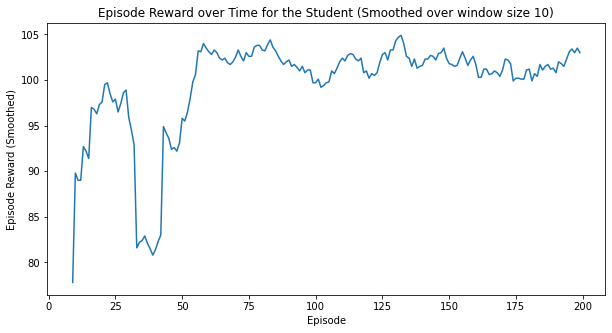

In [126]:
#figname = f'closeddoor_student_training_results_seed6_{num_episodes}_episodes.png'

smoothing_window = 10

plt.figure(figsize=(10, 5))
rewards_smoothed = pd.Series(all_rewards).rolling(smoothing_window).mean()
#rewards_smoothed = all_rewards
plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time for the Student (Smoothed over window size {})".format(smoothing_window))
#plt.savefig(figname)
plt.show(block=False)
plt.close()


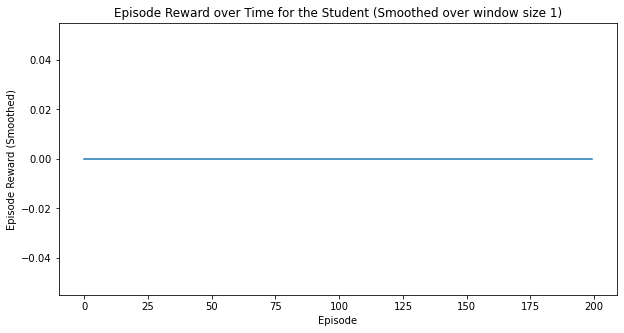

In [168]:
# plot env_reward

smoothing_window = 1

plt.figure(figsize=(10, 5))
rewards_smoothed = pd.Series(all_env_rewards).rolling(smoothing_window).mean()
plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time for the Student (Smoothed over window size {})".format(smoothing_window))
#plt.savefig(figname)
plt.show(block=False)
plt.close()

In [137]:
"""Evaluate student's performance after Q-learning"""

total_epochs, total_reward = 0, 0
episodes = 100


for _ in range(episodes):
    env = sample_env()
    teacher = env.agents[0].pos
    student = env.agents[1].pos
    teacher_dir = env.agents[0].dir
    student_dir = env.agents[1].dir
    #door_state = int(env.grid.get(3,1).state == env.grid.get(3,1).states.open)
    door_state = int(env.grid.get(3,4).state == env.grid.get(3,4).states.open) #diff door loc
    state = student[1] * 6 * 4 * 2 + student[0] * 4 * 2 + student_dir * 2 + door_state

    epochs, reward = 0, 0

    done = False

    while not done:
        action_student = np.random.choice(
            np.where(q_table_student[state] == np.max(q_table_student[state]))[0])  # Exploit learned values

        next_obs, reward, done, info = env.step([6, action_student])
        student = env.agents[1].pos
        student_dir = env.agents[1].dir
        #door_state = int(env.grid.get(3,1).state == env.grid.get(3,1).states.open)
        door_state = int(env.grid.get(3,4).state == env.grid.get(3,4).states.open) #diff door loc
        state = student[1] * 6 * 4 * 2 + student[0] * 4 * 2 + student_dir * 2 + door_state
        epochs += 1
        
        if reward[1] > 0:
            break

    total_epochs += epochs
    total_reward += reward[1]

print(f"Results after {episodes} episodes:")
print(f"Average time steps per episode: {total_epochs / episodes}")
print(f"Average reward per episode: {total_reward / episodes}")


Results after 100 episodes:
Average time steps per episode: 250.0
Average reward per episode: 0.0


In [ ]:
# Plot reward: mean +- std

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed2_teacher.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed4_teacher.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_teacher.npy')

print(seed2.shape)


In [ ]:

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed2_teacher_opendoor.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed4_teacher_opendoor.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_teacher_opendoor.npy')

print(seed2.shape)

In [ ]:
# Plot reward: mean +- std

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed2_student.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed4_student.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_student.npy')

print(seed2.shape)


In [ ]:

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed2_student_opendoor_sameloc.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed4_student_opendoor_sameloc.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_student_opendoor_sameloc.npy')

print(seed2.shape)

In [ ]:
# epsilon .1 vs .3 vs .01

# 1/ Epsilon .1

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed2_student_epsi1_opendoor_diffloc.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed4_student_epsi1_opendoor_diffloc.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_student_epsi1_opendoor_diffloc.npy')




In [ ]:
# 2/ Epsilon .3

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed2_student_epsi3_opendoor_diffloc.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed4_student_epsi3_opendoor_diffloc.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_student_epsi3_opendoor_diffloc.npy')



In [ ]:
# 3/ Epsilon .01

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed2_student_epsi01_opendoor_diffloc.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed4_student_epsi01_opendoor_diffloc.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_student_epsi01_opendoor_diffloc.npy')


In [ ]:
# 3b/ Epsilon .01 + env_reward

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/env_reward_seed2_student_epsi01_opendoor_diffloc.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/env_reward_seed4_student_epsi01_opendoor_diffloc.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/env_reward_seed6_student_epsi01_opendoor_diffloc.npy')





In [151]:
# 3b/ Epsilon .1 + env_reward

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/env_reward_seed2_student_epsi1_opendoor_diffloc.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/env_reward_seed4_student_epsi1_opendoor_diffloc.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/env_reward_seed6_student_epsi1_opendoor_diffloc.npy')



In [ ]:
# Plot sparse learning

seed2 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed2_student_sparselearning.npy')
seed4 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed4_student_sparselearning.npy')
seed6 = np.load('/home/yseult/PycharmProjects/BMMproject/marlgrid-master/all_reward_seed6_student_sparselearning.npy')




In [152]:
smoothing_window = 10

rewards_smoothed_seed2 = pd.Series(seed2).rolling(smoothing_window).mean()
rewards_smoothed_seed4 = pd.Series(seed4).rolling(smoothing_window).mean()
rewards_smoothed_seed6 = pd.Series(seed6).rolling(smoothing_window).mean()

#print(rewards_smoothed_seed2)

In [153]:
seed_all = np.vstack((seed2, seed4, seed6))

print(seed_all.shape)

mu1 = seed_all.mean(axis=0)
sigma1 = seed_all.std(axis=0)


smoothing_window = 10

mu1_smoothed = pd.Series(mu1).rolling(smoothing_window).mean()
sigma1_smoothed = pd.Series(sigma1).rolling(smoothing_window).mean()

print(mu1_smoothed.shape)


(3, 200)
(200,)


(200,) (200,) (200,)


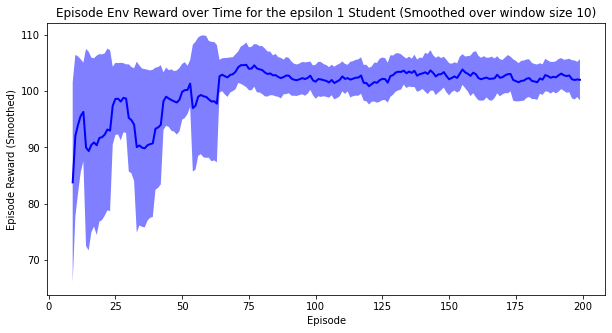

In [155]:
# plot it!
t = np.arange(200)
print(t.shape, mu1.shape, sigma1.shape)

figname = f'opendoor_student_training_epsi1_env_reward_results_3seeds_{num_episodes}_episodes.png'

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(t, mu1_smoothed, lw=2, color='blue')
ax.fill_between(t, mu1_smoothed+sigma1_smoothed, mu1_smoothed-sigma1_smoothed, facecolor='blue', alpha=0.5)
ax.set_title("Episode Env Reward over Time for the epsilon 1 Student (Smoothed over window size {})".format(smoothing_window))
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward (Smoothed)')
plt.savefig(figname)


In [ ]:
#rewards_smoothed = all_rewards
plt.figure(figsize=(10, 5))

plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time for the Student (Smoothed over window size {})".format(smoothing_window))
#plt.savefig(figname)
plt.show(block=False)
plt.close()

In [ ]:
Nsteps, Nwalkers = 100, 250
t = np.arange(Nsteps)

# an (Nsteps x Nwalkers) array of random walk steps
S1 = 0.002 + 0.01*np.random.randn(Nsteps, Nwalkers)

# an (Nsteps x Nwalkers) array of random walker positions
X1 = S1.cumsum(axis=0)


# Nsteps length arrays empirical means and standard deviations of both
# populations over time
mu1 = X1.mean(axis=1)
sigma1 = X1.std(axis=1)

print(t.shape, mu1.shape, sigma1.shape)


# plot it!
fig, ax = plt.subplots(1)
ax.plot(t, mu1, lw=2, label='mean population 1', color='blue')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.set_title(r'random walkers empirical $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='upper left')
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward (Smoothed)')


In [ ]:
        #if action_student != action_teacher:
        #    proba = random.random()
        #    if proba > 0.3:
        #        reward = -1
        #    else:
        #        reward = 1
        #else:
        #    reward = 1    
        
        #else:
        #    reward = 0